## SARSA 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gym
%matplotlib inline
import cv2

def preprocess(image):
    def_h = 84
    def_w = 84
    img = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
    img = cv2.resize(img, (def_h, def_w))
    img = np.expand_dims(img, axis=2)
    return img

def preprocess_tensor(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], tensor.shape[1], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        for j in xrange(tensor.shape[1]):
            img = 0.299*tensor[i,j,:,:,0] + 0.587*tensor[i,j,:,:,1] + 0.114*tensor[i,j,:,:,2]
            tnsr[i,j,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

def preprocess_tensor4(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        img = 0.299*tensor[i,:,:,0] + 0.587*tensor[i,:,:,1] + 0.114*tensor[i,:,:,2]
        tnsr[i,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

### Game parameters

In [8]:
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"
GAME_TITLE = 'MsPacman-v0'
N_PARALLEL_GAMES = 16
replay_seq_len = 64

atari = gym.make(GAME_TITLE)
atari.reset()
n_actions = atari.action_space.n
observation_shape = (None,) + (84, 84, 1)
action_names = ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [9]:
observation_shape

(None, 84, 84, 1)

In [10]:
del atari

### Observations

In [11]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer


observation_layer = InputLayer(observation_shape, name="images input")
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

### Memory layer

In [13]:
from agentnet.memory import WindowAugmentation
window_size = 4

prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")

window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")

memory_dict = {window:prev_window}

### Policy

In [14]:
from lasagne.layers import ExpressionLayer, DenseLayer

window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])

nn = lasagne.layers.Conv2DLayer(window_max, num_filters=16, filter_size=(8, 8), stride=(4, 4))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.BatchNormLayer(nn)

### Resolver

In [15]:
from agentnet.resolver import EpsilonGreedyResolver

q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")
resolver = EpsilonGreedyResolver(q_eval,name="resolver")

### Putting it together

In [17]:
from agentnet.agent import Agent
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)

weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 QEvaluator.W,
 QEvaluator.b]

### Step function

In [18]:
applier_fun = agent.get_react_function()

def step(observation, prev_memories = 'zeros', batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""

    if prev_memories == 'zeros':
        prev_memories = agent.get_zeros_like_memory(batch_size=batch_size)
    
    obs = preprocess_tensor4(np.array(observation))
    if len(np.array(prev_memories).shape) == 5:
        res = applier_fun(obs, *[prev_memories])
    else:
        res = applier_fun(obs, *prev_memories)
    
    action = res[0]
    memories = res[1:]
    return action, memories[0]

### Environment, pool and all other stuff

In [19]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, n_games=N_PARALLEL_GAMES, make_env=GAME_TITLE, agent_step=step)

[2017-05-24 01:20:19,711] Making new env: MsPacman-v0
[2017-05-24 01:20:19,969] Making new env: MsPacman-v0
[2017-05-24 01:20:20,144] Making new env: MsPacman-v0
[2017-05-24 01:20:20,318] Making new env: MsPacman-v0
[2017-05-24 01:20:20,492] Making new env: MsPacman-v0
[2017-05-24 01:20:20,666] Making new env: MsPacman-v0
[2017-05-24 01:20:20,832] Making new env: MsPacman-v0
[2017-05-24 01:20:20,998] Making new env: MsPacman-v0
[2017-05-24 01:20:21,166] Making new env: MsPacman-v0
[2017-05-24 01:20:21,329] Making new env: MsPacman-v0
[2017-05-24 01:20:21,498] Making new env: MsPacman-v0
[2017-05-24 01:20:21,662] Making new env: MsPacman-v0
[2017-05-24 01:20:21,824] Making new env: MsPacman-v0
[2017-05-24 01:20:21,993] Making new env: MsPacman-v0
[2017-05-24 01:20:22,161] Making new env: MsPacman-v0
[2017-05-24 01:20:22,323] Making new env: MsPacman-v0


In [20]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


[['NOOP' 'DOWNRIGHT' 'RIGHT' 'UP' 'RIGHT']
 ['NOOP' 'DOWN' 'RIGHT' 'DOWNLEFT' 'NOOP']
 ['RIGHT' 'RIGHT' 'RIGHT' 'DOWNLEFT' 'RIGHT']]
CPU times: user 732 ms, sys: 88 ms, total: 820 ms
Wall time: 815 ms


In [23]:
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(n_steps=n_steps)
    observation_tensor = preprocess_tensor(observation_tensor)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
update_pool(env,pool,replay_seq_len)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


### Loss

In [25]:
from agentnet.learning import sarsa
from lasagne.regularization import regularize_network_params, l2

#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)

scaled_reward_seq = env.rewards
elwise_mse_loss = sarsa.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        n_steps=10,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()
reg_l2 = regularize_network_params(resolver,l2)*10**-4
loss = mse_loss + reg_l2

updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

mean_session_reward = env.rewards.sum(axis=1).mean()

In [31]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

### Training

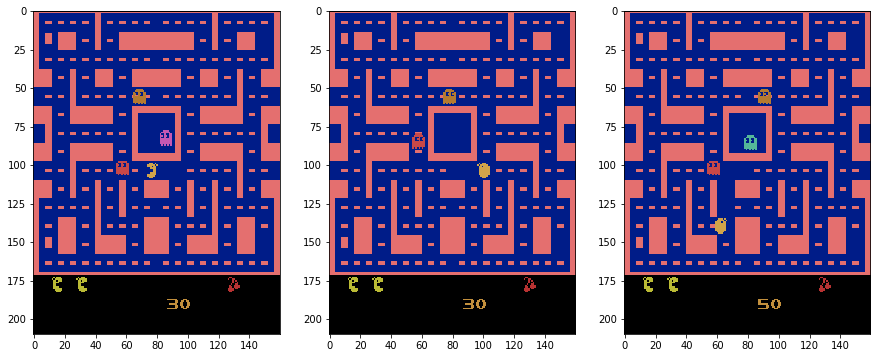

In [35]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    
#visualize untrained network performance (which is mostly random)
display_sessions()

In [38]:
import os
from agentnet.display import Metrics

score_log = Metrics()
epoch_counter = 1
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


epoch 10,loss 45.78596, epsilon 0.49552, rewards: ( e-greedy 3.12500, greedy 3.68750) 
rec 45.604 reg 0.182
epoch 20,loss 58.08410, epsilon 0.49109, rewards: ( e-greedy 6.06250, greedy 8.25625) 
rec 57.828 reg 0.256
epoch 30,loss 71.59127, epsilon 0.48670, rewards: ( e-greedy 8.76875, greedy 11.99312) 
rec 71.288 reg 0.303
epoch 40,loss 614.77222, epsilon 0.48236, rewards: ( e-greedy 13.51688, greedy 16.16881) 
rec 614.435 reg 0.337
epoch 50,loss 338.67481, epsilon 0.47805, rewards: ( e-greedy 17.47769, greedy 18.67693) 
rec 338.315 reg 0.359
epoch 60,loss 73.57171, epsilon 0.47379, rewards: ( e-greedy 19.47992, greedy 20.93424) 
rec 73.199 reg 0.373
epoch 70,loss 82.96105, epsilon 0.46958, rewards: ( e-greedy 22.28193, greedy 21.77831) 
rec 82.580 reg 0.381
epoch 80,loss 86.05841, epsilon 0.46540, rewards: ( e-greedy 22.92873, greedy 26.85048) 
rec 85.672 reg 0.386
epoch 90,loss 389.80326, epsilon 0.46127, rewards: ( e-greedy 25.32336, greedy 25.85293) 
rec 389.407 reg 0.396
epoch 100

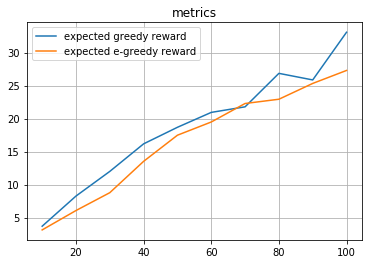

Random session examples


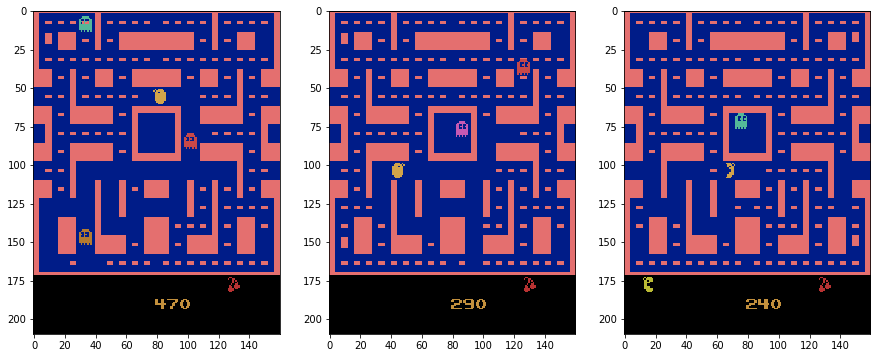

epoch 110,loss 461.13786, epsilon 0.45313, rewards: ( e-greedy 29.37442, greedy 36.08463) 
rec 460.695 reg 0.443
epoch 120,loss 98.67826, epsilon 0.44911, rewards: ( e-greedy 29.06198, greedy 36.53866) 
rec 98.207 reg 0.472
epoch 130,loss 333.29310, epsilon 0.44514, rewards: ( e-greedy 30.78078, greedy 36.44730) 
rec 332.794 reg 0.499
epoch 140,loss 76.13498, epsilon 0.44121, rewards: ( e-greedy 29.70270, greedy 35.74007) 
rec 75.613 reg 0.522
epoch 150,loss 289.77023, epsilon 0.43732, rewards: ( e-greedy 31.23243, greedy 35.10356) 
rec 289.235 reg 0.536
epoch 160,loss 90.43098, epsilon 0.43346, rewards: ( e-greedy 32.42169, greedy 38.15571) 
rec 89.886 reg 0.545
epoch 170,loss 69.06889, epsilon 0.42965, rewards: ( e-greedy 31.11702, greedy 37.71513) 
rec 68.515 reg 0.554
epoch 180,loss 118.34450, epsilon 0.42587, rewards: ( e-greedy 31.63032, greedy 37.50612) 
rec 117.783 reg 0.562
epoch 190,loss 80.40479, epsilon 0.42213, rewards: ( e-greedy 30.77979, greedy 36.75551) 
rec 79.838 reg

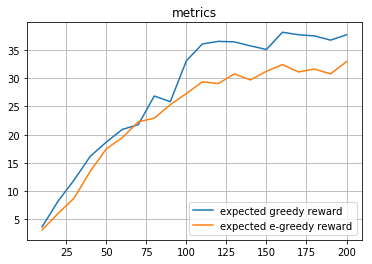

Random session examples


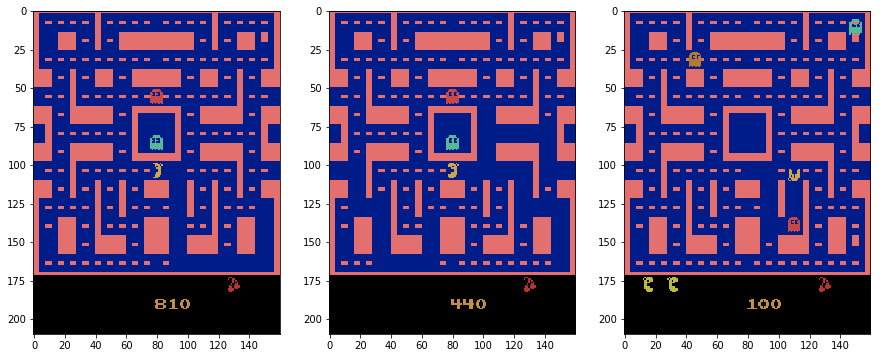

epoch 210,loss 88.62356, epsilon 0.41476, rewards: ( e-greedy 34.59413, greedy 37.43446) 
rec 88.049 reg 0.575
epoch 220,loss 1092.70710, epsilon 0.41113, rewards: ( e-greedy 35.63471, greedy 38.19102) 
rec 1092.122 reg 0.585
epoch 230,loss 105.33624, epsilon 0.40754, rewards: ( e-greedy 36.38374, greedy 36.68441) 
rec 104.743 reg 0.593
epoch 240,loss 493.57248, epsilon 0.40398, rewards: ( e-greedy 39.87037, greedy 36.70347) 
rec 492.966 reg 0.607
epoch 250,loss 132.21086, epsilon 0.40046, rewards: ( e-greedy 39.38333, greedy 36.84563) 
rec 131.584 reg 0.627
epoch 260,loss 608.13090, epsilon 0.39697, rewards: ( e-greedy 40.57000, greedy 39.47356) 
rec 607.473 reg 0.658
epoch 270,loss 286.99493, epsilon 0.39352, rewards: ( e-greedy 41.57550, greedy 39.83871) 
rec 286.317 reg 0.678
epoch 280,loss 105.50831, epsilon 0.39010, rewards: ( e-greedy 39.91795, greedy 39.91734) 
rec 104.821 reg 0.688
epoch 290,loss 413.36595, epsilon 0.38672, rewards: ( e-greedy 39.92615, greedy 41.98810) 
rec 4

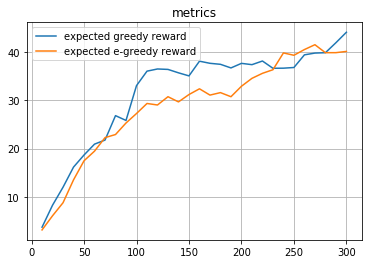

Random session examples


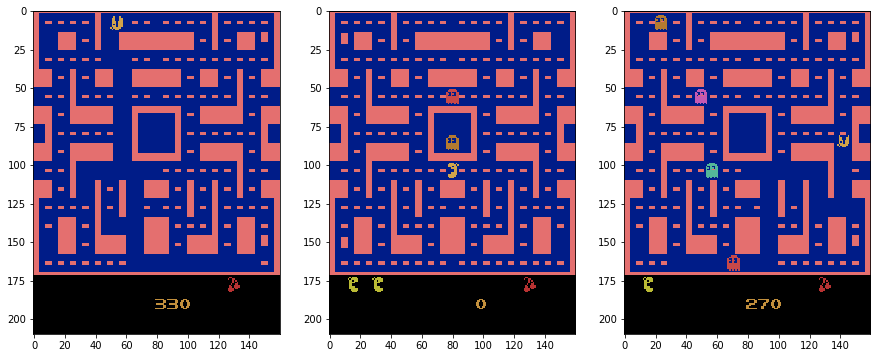

epoch 310,loss 356.64160, epsilon 0.38005, rewards: ( e-greedy 41.79018, greedy 43.37286) 
rec 355.942 reg 0.699
epoch 320,loss 216.53571, epsilon 0.37677, rewards: ( e-greedy 45.04867, greedy 41.97308) 
rec 215.832 reg 0.704
epoch 330,loss 102.50476, epsilon 0.37352, rewards: ( e-greedy 45.35630, greedy 45.90077) 
rec 101.800 reg 0.705
epoch 340,loss 243.01118, epsilon 0.37030, rewards: ( e-greedy 44.50817, greedy 51.37319) 
rec 242.306 reg 0.705
epoch 350,loss 413.95564, epsilon 0.36711, rewards: ( e-greedy 45.30735, greedy 51.17337) 
rec 413.248 reg 0.708
epoch 360,loss 124.18372, epsilon 0.36395, rewards: ( e-greedy 44.40162, greedy 52.24354) 
rec 123.469 reg 0.715
epoch 370,loss 110.47854, epsilon 0.36083, rewards: ( e-greedy 43.14896, greedy 56.45668) 
rec 109.754 reg 0.724
epoch 380,loss 1106.76758, epsilon 0.35774, rewards: ( e-greedy 47.27156, greedy 54.18601) 
rec 1106.031 reg 0.737
epoch 390,loss 126.49330, epsilon 0.35468, rewards: ( e-greedy 46.54440, greedy 51.82991) 
rec

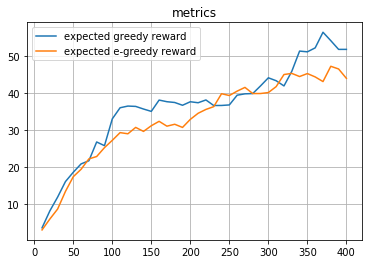

Random session examples


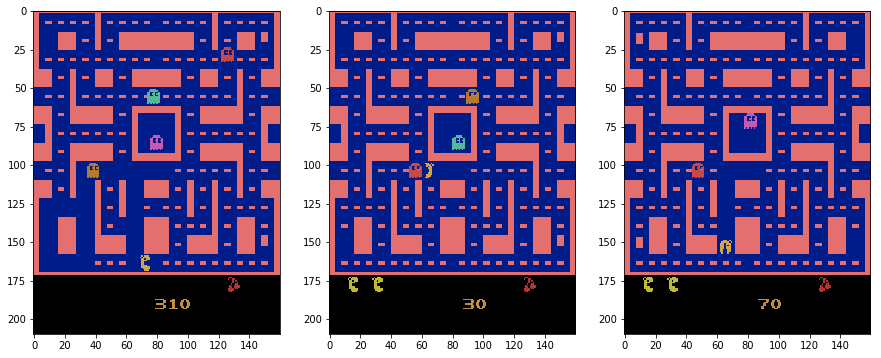

epoch 410,loss 280.72257, epsilon 0.34864, rewards: ( e-greedy 42.55097, greedy 53.33848) 
rec 279.966 reg 0.757
epoch 420,loss 103.04950, epsilon 0.34567, rewards: ( e-greedy 43.04587, greedy 50.06713) 
rec 102.283 reg 0.766
epoch 430,loss 99.39476, epsilon 0.34273, rewards: ( e-greedy 41.86628, greedy 50.68542) 
rec 98.617 reg 0.778
epoch 440,loss 377.87229, epsilon 0.33982, rewards: ( e-greedy 43.36716, greedy 54.61688) 
rec 377.087 reg 0.786
epoch 450,loss 501.75080, epsilon 0.33693, rewards: ( e-greedy 43.53044, greedy 56.71769) 
rec 500.959 reg 0.792
epoch 460,loss 96.74866, epsilon 0.33408, rewards: ( e-greedy 41.92740, greedy 58.23342) 
rec 95.941 reg 0.807
epoch 470,loss 96.99622, epsilon 0.33125, rewards: ( e-greedy 40.17216, greedy 60.03508) 
rec 96.173 reg 0.823
epoch 480,loss 1788.95533, epsilon 0.32845, rewards: ( e-greedy 42.59244, greedy 57.78157) 
rec 1788.122 reg 0.833
epoch 490,loss 1305.09537, epsilon 0.32568, rewards: ( e-greedy 44.27070, greedy 57.50341) 
rec 1304

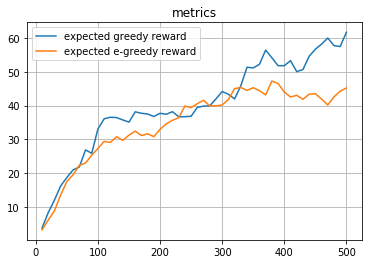

Random session examples


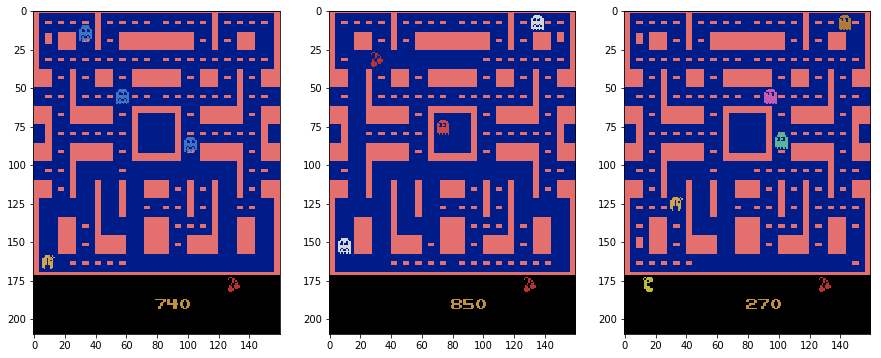

epoch 510,loss 984.48558, epsilon 0.32022, rewards: ( e-greedy 46.69676, greedy 58.70276) 
rec 983.636 reg 0.849
epoch 520,loss 237.53463, epsilon 0.31753, rewards: ( e-greedy 47.15209, greedy 55.45749) 
rec 236.680 reg 0.855
epoch 530,loss 1815.35026, epsilon 0.31487, rewards: ( e-greedy 49.68688, greedy 56.72424) 
rec 1814.492 reg 0.858
epoch 540,loss 106.88424, epsilon 0.31224, rewards: ( e-greedy 47.53069, greedy 54.67682) 
rec 106.023 reg 0.861
epoch 550,loss 1118.40338, epsilon 0.30963, rewards: ( e-greedy 51.84012, greedy 56.20913) 
rec 1117.529 reg 0.874
epoch 560,loss 111.46011, epsilon 0.30704, rewards: ( e-greedy 51.40611, greedy 55.08822) 
rec 110.577 reg 0.884
epoch 570,loss 122.27936, epsilon 0.30449, rewards: ( e-greedy 47.20300, greedy 56.07940) 
rec 121.377 reg 0.902
epoch 580,loss 95.68763, epsilon 0.30195, rewards: ( e-greedy 44.29520, greedy 54.28396) 
rec 94.766 reg 0.921
epoch 590,loss 1568.92435, epsilon 0.29945, rewards: ( e-greedy 46.24068, greedy 55.98056) 
re

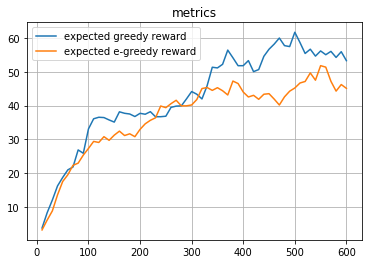

Random session examples


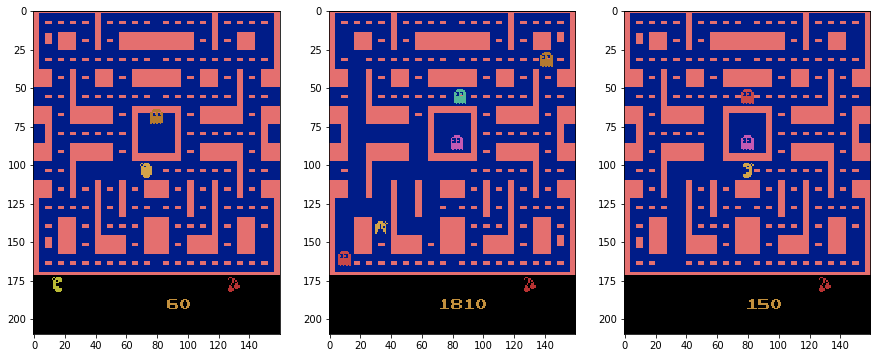

epoch 610,loss 432.98704, epsilon 0.29451, rewards: ( e-greedy 44.54245, greedy 48.86301) 
rec 432.022 reg 0.965
epoch 620,loss 104.96168, epsilon 0.29207, rewards: ( e-greedy 43.90071, greedy 49.28921) 
rec 103.988 reg 0.974
epoch 630,loss 97.58448, epsilon 0.28967, rewards: ( e-greedy 42.13563, greedy 47.98528) 
rec 96.601 reg 0.984
epoch 640,loss 956.47647, epsilon 0.28728, rewards: ( e-greedy 45.73457, greedy 47.74926) 
rec 955.482 reg 0.994
epoch 650,loss 5483.39885, epsilon 0.28492, rewards: ( e-greedy 51.72361, greedy 47.22433) 
rec 5482.394 reg 1.005
epoch 660,loss 161.76961, epsilon 0.28258, rewards: ( e-greedy 48.98875, greedy 46.00190) 
rec 160.754 reg 1.015
epoch 670,loss 1928.02437, epsilon 0.28027, rewards: ( e-greedy 51.96488, greedy 44.58921) 
rec 1926.997 reg 1.028
epoch 680,loss 135.40780, epsilon 0.27798, rewards: ( e-greedy 50.95589, greedy 47.69279) 
rec 134.364 reg 1.044
epoch 690,loss 120.18843, epsilon 0.27571, rewards: ( e-greedy 48.86030, greedy 47.61101) 
rec

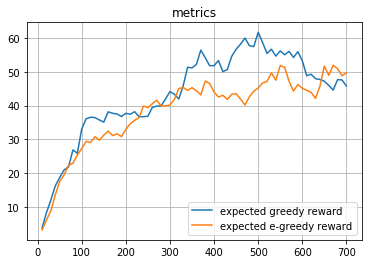

Random session examples


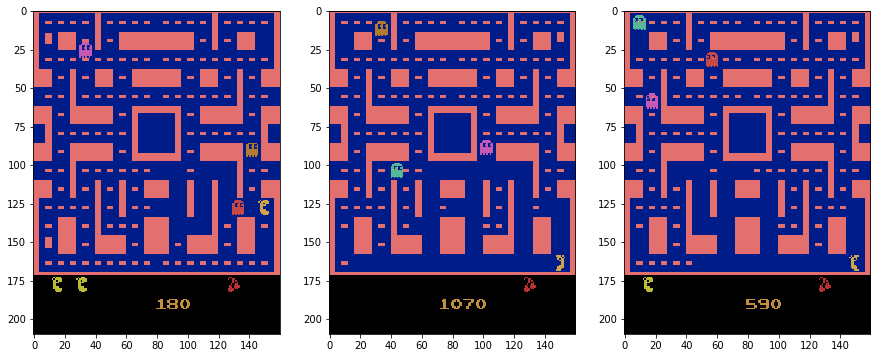

epoch 710,loss 339.70917, epsilon 0.27124, rewards: ( e-greedy 49.87684, greedy 46.08367) 
rec 338.649 reg 1.060
epoch 720,loss 135.53134, epsilon 0.26904, rewards: ( e-greedy 48.20166, greedy 44.72530) 
rec 134.464 reg 1.067
epoch 730,loss 135.84896, epsilon 0.26686, rewards: ( e-greedy 47.13149, greedy 47.31527) 
rec 134.776 reg 1.073
epoch 740,loss 361.27099, epsilon 0.26470, rewards: ( e-greedy 50.16834, greedy 48.52124) 
rec 360.194 reg 1.077
epoch 750,loss 118.29830, epsilon 0.26256, rewards: ( e-greedy 48.27651, greedy 46.60662) 
rec 117.211 reg 1.087
epoch 760,loss 89.79894, epsilon 0.26045, rewards: ( e-greedy 46.38636, greedy 46.32096) 
rec 88.704 reg 1.095
epoch 770,loss 87.23993, epsilon 0.25836, rewards: ( e-greedy 45.81022, greedy 48.87636) 
rec 86.142 reg 1.098
epoch 780,loss 265.37101, epsilon 0.25628, rewards: ( e-greedy 49.35420, greedy 48.73873) 
rec 264.274 reg 1.097
epoch 790,loss 460.55793, epsilon 0.25423, rewards: ( e-greedy 52.10628, greedy 48.80235) 
rec 459.4

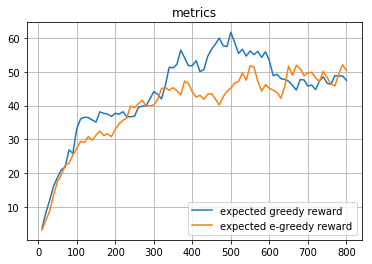

Random session examples


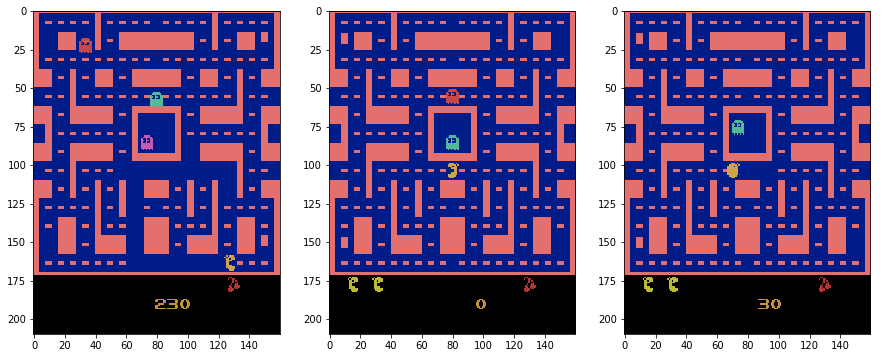

epoch 810,loss 175.43783, epsilon 0.25019, rewards: ( e-greedy 49.85609, greedy 48.79866) 
rec 174.334 reg 1.104
epoch 820,loss 342.67422, epsilon 0.24819, rewards: ( e-greedy 48.37048, greedy 45.79379) 
rec 341.562 reg 1.112
epoch 830,loss 110.35327, epsilon 0.24622, rewards: ( e-greedy 46.65843, greedy 42.65191) 
rec 109.232 reg 1.121
epoch 840,loss 197.41229, epsilon 0.24427, rewards: ( e-greedy 47.11759, greedy 42.44922) 
rec 196.284 reg 1.128
epoch 850,loss 153.34491, epsilon 0.24234, rewards: ( e-greedy 45.15583, greedy 40.64180) 
rec 152.207 reg 1.138
epoch 860,loss 141.30095, epsilon 0.24042, rewards: ( e-greedy 46.26525, greedy 39.51512) 
rec 140.157 reg 1.144
epoch 870,loss 405.36341, epsilon 0.23853, rewards: ( e-greedy 47.63872, greedy 38.93861) 
rec 404.218 reg 1.146
epoch 880,loss 1152.54409, epsilon 0.23665, rewards: ( e-greedy 50.74985, greedy 40.04475) 
rec 1151.395 reg 1.149
epoch 890,loss 965.00190, epsilon 0.23480, rewards: ( e-greedy 50.79986, greedy 39.72777) 
rec

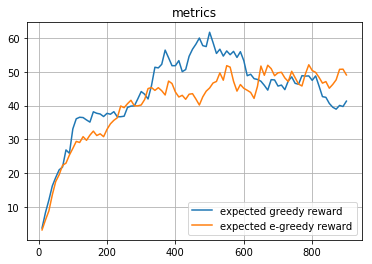

Random session examples


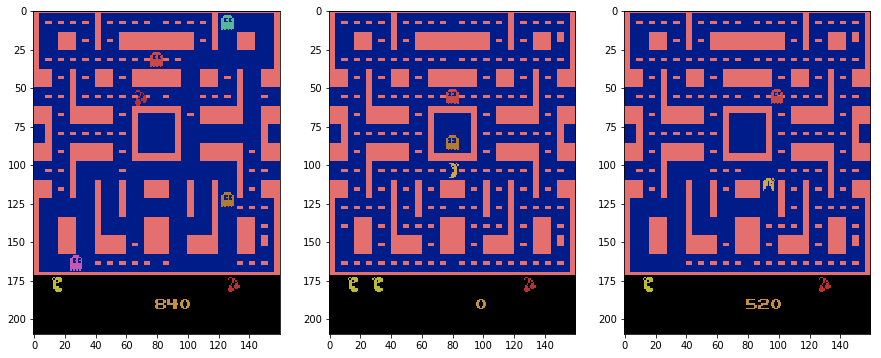

epoch 910,loss 195.63952, epsilon 0.23114, rewards: ( e-greedy 48.18539, greedy 44.37324) 
rec 194.460 reg 1.179
epoch 920,loss 407.19146, epsilon 0.22933, rewards: ( e-greedy 50.11685, greedy 45.93592) 
rec 406.010 reg 1.182
epoch 930,loss 398.36388, epsilon 0.22755, rewards: ( e-greedy 49.79267, greedy 44.90483) 
rec 397.180 reg 1.184
epoch 940,loss 760.99227, epsilon 0.22578, rewards: ( e-greedy 53.87590, greedy 44.66435) 
rec 759.807 reg 1.186
epoch 950,loss 263.49636, epsilon 0.22403, rewards: ( e-greedy 53.42581, greedy 44.51041) 
rec 262.308 reg 1.188
epoch 960,loss 230.09178, epsilon 0.22230, rewards: ( e-greedy 52.39573, greedy 43.18437) 
rec 228.896 reg 1.195
epoch 970,loss 187.48642, epsilon 0.22059, rewards: ( e-greedy 51.53116, greedy 44.92843) 
rec 186.275 reg 1.211
epoch 980,loss 138.47849, epsilon 0.21889, rewards: ( e-greedy 48.37804, greedy 44.49809) 
rec 137.250 reg 1.229
epoch 990,loss 1202.30308, epsilon 0.21721, rewards: ( e-greedy 52.91524, greedy 45.67328) 
rec 

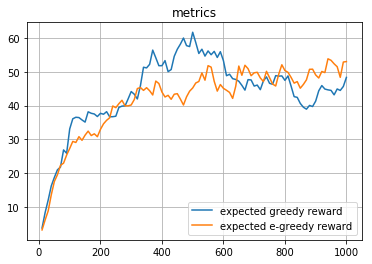

Random session examples


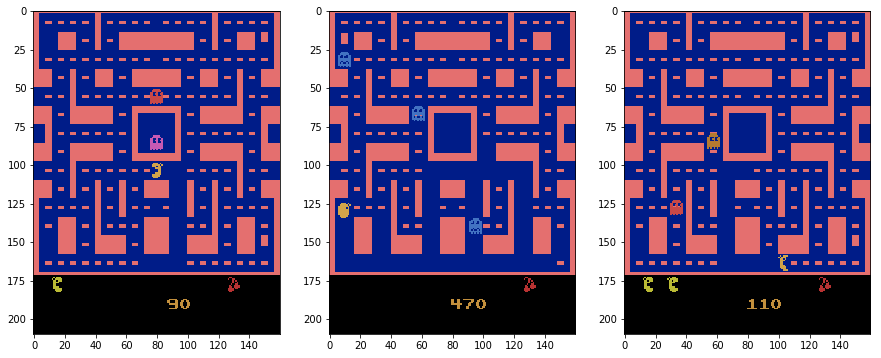

[2017-05-24 01:52:12,800] Making new env: MsPacman-v0
[2017-05-24 01:52:12,962] Clearing 11 monitor files from previous run (because force=True was provided)
[2017-05-24 01:52:12,971] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.0.6682.video000000.mp4
[2017-05-24 01:52:14,480] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.0.6682.video000001.mp4


Episode finished after 663 timesteps, rw = 220.0
Episode finished after 617 timesteps, rw = 250.0
Episode finished after 655 timesteps, rw = 260.0
Episode finished after 614 timesteps, rw = 340.0
Episode finished after 732 timesteps, rw = 240.0
Episode finished after 639 timesteps, rw = 280.0
Episode finished after 598 timesteps, rw = 260.0


[2017-05-24 01:52:22,064] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.0.6682.video000008.mp4


Episode finished after 688 timesteps, rw = 340.0
Episode finished after 624 timesteps, rw = 360.0
Episode finished after 537 timesteps, rw = 290.0
Episode finished after 661 timesteps, rw = 290.0
Episode finished after 892 timesteps, rw = 340.0
Episode finished after 873 timesteps, rw = 280.0
Episode finished after 555 timesteps, rw = 200.0
Episode finished after 620 timesteps, rw = 300.0
Episode finished after 602 timesteps, rw = 340.0
Episode finished after 698 timesteps, rw = 310.0
Episode finished after 596 timesteps, rw = 220.0
Episode finished after 660 timesteps, rw = 270.0


[2017-05-24 01:52:35,134] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 704 timesteps, rw = 270.0
Mean 283.0, Var 1961.0
epoch 1010,loss 187.68191, epsilon 0.21390, rewards: ( e-greedy 53.19259, greedy 47.70786) 
rec 186.270 reg 1.412
epoch 1020,loss 371.20765, epsilon 0.21227, rewards: ( e-greedy 54.12333, greedy 44.93707) 
rec 369.757 reg 1.450
epoch 1030,loss 1915.85032, epsilon 0.21065, rewards: ( e-greedy 57.14850, greedy 46.25586) 
rec 1914.386 reg 1.464
epoch 1040,loss 420.62498, epsilon 0.20905, rewards: ( e-greedy 59.62115, greedy 51.19278) 
rec 419.152 reg 1.473
epoch 1050,loss 852.20151, epsilon 0.20747, rewards: ( e-greedy 61.22153, greedy 49.63600) 
rec 850.724 reg 1.478
epoch 1060,loss 111.03749, epsilon 0.20591, rewards: ( e-greedy 58.59938, greedy 50.10990) 
rec 109.553 reg 1.484
epoch 1070,loss 105.92128, epsilon 0.20435, rewards: ( e-greedy 55.73944, greedy 48.22391) 
rec 104.434 reg 1.487
epoch 1390,loss 1476.78741, epsilon 0.16208, rewards: ( e-greedy 64.44712, greedy 64.95420) 
rec 1475.080 reg 1.708
epoch 1400,l

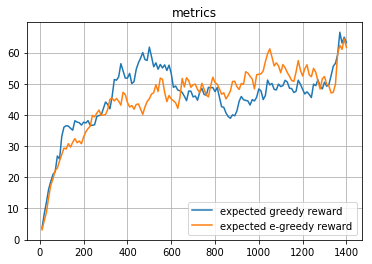

Random session examples


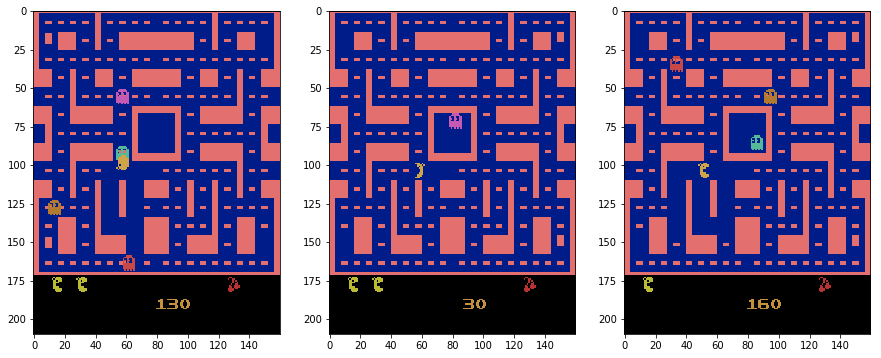

epoch 1410,loss 437.21630, epsilon 0.15986, rewards: ( e-greedy 63.45842, greedy 69.82540) 
rec 435.473 reg 1.743
epoch 1420,loss 151.54001, epsilon 0.15877, rewards: ( e-greedy 61.73757, greedy 70.78036) 
rec 149.786 reg 1.754
epoch 1430,loss 755.35654, epsilon 0.15769, rewards: ( e-greedy 64.31382, greedy 72.63982) 
rec 753.583 reg 1.774
epoch 1440,loss 170.78911, epsilon 0.15662, rewards: ( e-greedy 63.25744, greedy 77.00084) 
rec 168.970 reg 1.819
epoch 1450,loss 129.26197, epsilon 0.15556, rewards: ( e-greedy 61.43169, greedy 76.11326) 
rec 127.408 reg 1.854
epoch 1460,loss 183.72058, epsilon 0.15451, rewards: ( e-greedy 58.91352, greedy 72.12693) 
rec 181.841 reg 1.880
epoch 1470,loss 1284.38701, epsilon 0.15347, rewards: ( e-greedy 60.70967, greedy 74.35174) 
rec 1282.479 reg 1.908
epoch 1480,loss 204.79172, epsilon 0.15244, rewards: ( e-greedy 57.57620, greedy 68.91657) 
rec 202.860 reg 1.932
epoch 1490,loss 303.88637, epsilon 0.15142, rewards: ( e-greedy 58.63108, greedy 70.89

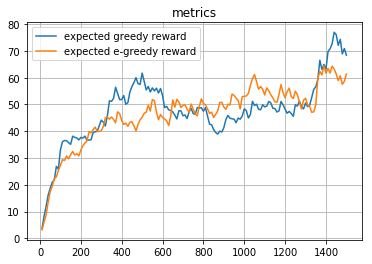

Random session examples


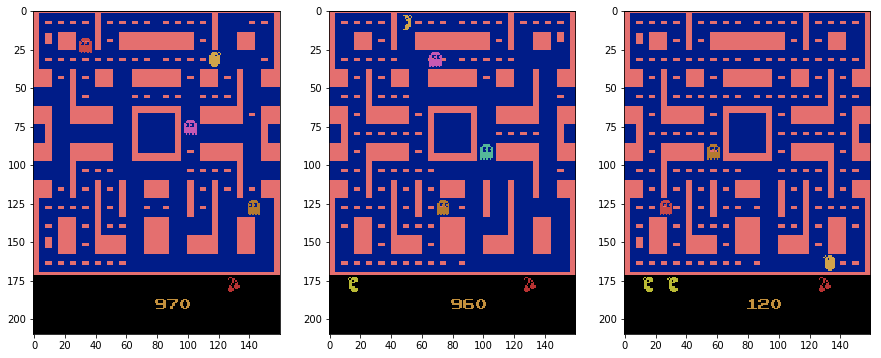

epoch 1510,loss 295.53962, epsilon 0.14941, rewards: ( e-greedy 63.62868, greedy 65.90393) 
rec 293.582 reg 1.958
epoch 1520,loss 146.57405, epsilon 0.14842, rewards: ( e-greedy 62.64081, greedy 66.62603) 
rec 144.621 reg 1.953
epoch 1530,loss 253.54060, epsilon 0.14744, rewards: ( e-greedy 62.18923, greedy 64.65093) 
rec 251.594 reg 1.946
epoch 1540,loss 971.91344, epsilon 0.14647, rewards: ( e-greedy 62.03281, greedy 62.49834) 
rec 969.976 reg 1.937
epoch 1550,loss 1074.48545, epsilon 0.14551, rewards: ( e-greedy 64.57953, greedy 61.12350) 
rec 1072.557 reg 1.929
epoch 1560,loss 254.63247, epsilon 0.14456, rewards: ( e-greedy 63.18407, greedy 62.19865) 
rec 252.713 reg 1.920
epoch 1570,loss 144.75309, epsilon 0.14362, rewards: ( e-greedy 61.74067, greedy 59.79129) 
rec 142.841 reg 1.912
epoch 1580,loss 400.61320, epsilon 0.14269, rewards: ( e-greedy 62.50410, greedy 61.37466) 
rec 398.702 reg 1.911
epoch 1590,loss 321.86112, epsilon 0.14177, rewards: ( e-greedy 62.75369, greedy 60.11

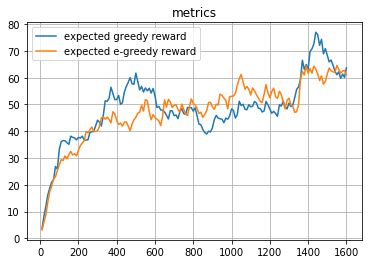

Random session examples


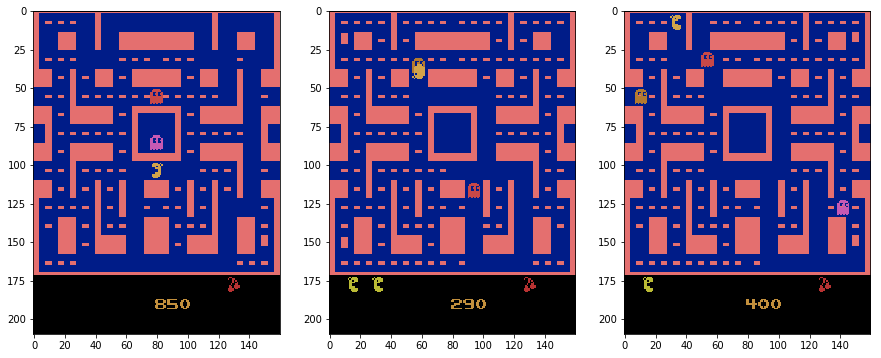

epoch 1610,loss 606.53163, epsilon 0.13995, rewards: ( e-greedy 61.42424, greedy 63.60338) 
rec 604.617 reg 1.914
epoch 1620,loss 191.21705, epsilon 0.13905, rewards: ( e-greedy 59.59431, greedy 61.36804) 
rec 189.298 reg 1.919
epoch 1630,loss 1670.14104, epsilon 0.13817, rewards: ( e-greedy 60.38488, greedy 62.54373) 
rec 1668.216 reg 1.925
epoch 1640,loss 652.67057, epsilon 0.13729, rewards: ( e-greedy 62.09639, greedy 63.10186) 
rec 650.745 reg 1.926
epoch 1650,loss 1308.59392, epsilon 0.13642, rewards: ( e-greedy 66.82426, greedy 59.66668) 
rec 1306.660 reg 1.934
epoch 1660,loss 328.24394, epsilon 0.13556, rewards: ( e-greedy 68.07933, greedy 60.57501) 
rec 326.301 reg 1.943
epoch 1670,loss 417.78664, epsilon 0.13471, rewards: ( e-greedy 66.27140, greedy 56.58001) 
rec 415.841 reg 1.945
epoch 1680,loss 159.44958, epsilon 0.13387, rewards: ( e-greedy 62.83176, greedy 54.42201) 
rec 157.502 reg 1.947
epoch 1690,loss 704.46489, epsilon 0.13303, rewards: ( e-greedy 65.29858, greedy 55.

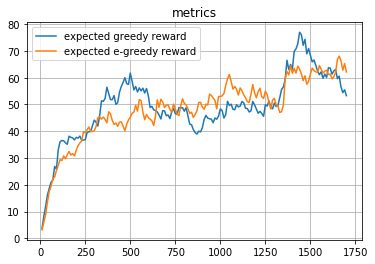

Random session examples


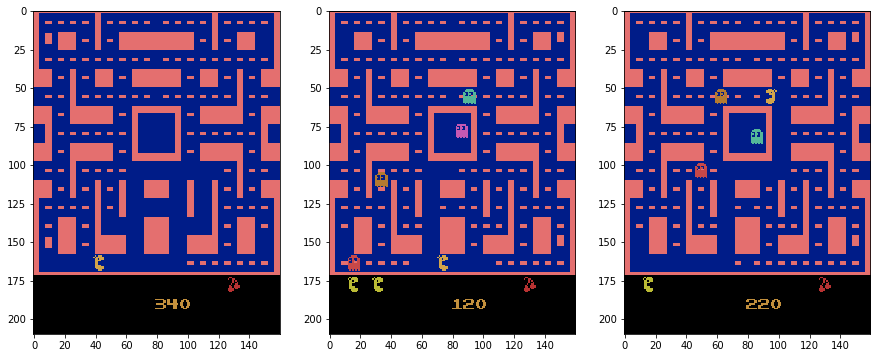

epoch 1710,loss 161.13565, epsilon 0.13139, rewards: ( e-greedy 59.80435, greedy 52.22614) 
rec 159.193 reg 1.942
epoch 1720,loss 185.24999, epsilon 0.13058, rewards: ( e-greedy 57.88642, greedy 57.87853) 
rec 183.296 reg 1.954
epoch 1730,loss 940.03100, epsilon 0.12978, rewards: ( e-greedy 60.09777, greedy 63.15318) 
rec 938.069 reg 1.962
epoch 1740,loss 617.71077, epsilon 0.12898, rewards: ( e-greedy 63.90050, greedy 60.40036) 
rec 615.742 reg 1.968
epoch 1750,loss 463.20261, epsilon 0.12820, rewards: ( e-greedy 62.88545, greedy 59.29782) 
rec 461.230 reg 1.972
epoch 1760,loss 350.67617, epsilon 0.12742, rewards: ( e-greedy 63.59690, greedy 60.36804) 
rec 348.700 reg 1.976
epoch 1770,loss 190.04887, epsilon 0.12665, rewards: ( e-greedy 61.29971, greedy 60.76874) 
rec 188.064 reg 1.985
epoch 1780,loss 1550.75992, epsilon 0.12589, rewards: ( e-greedy 59.29474, greedy 56.75436) 
rec 1548.762 reg 1.998
epoch 1790,loss 391.87520, epsilon 0.12513, rewards: ( e-greedy 60.36527, greedy 57.01

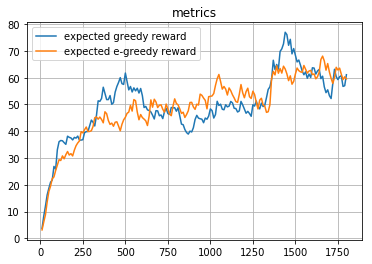

Random session examples


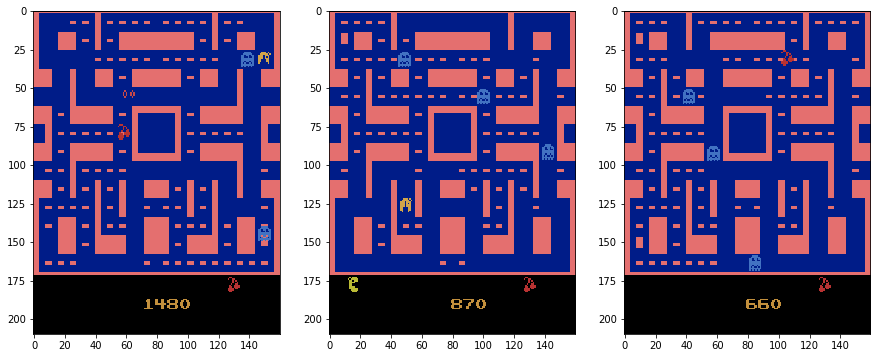

epoch 1810,loss 1558.30742, epsilon 0.12364, rewards: ( e-greedy 60.99587, greedy 63.63956) 
rec 1556.299 reg 2.008
epoch 1820,loss 1206.80261, epsilon 0.12291, rewards: ( e-greedy 65.52128, greedy 69.58810) 
rec 1204.783 reg 2.019
epoch 1830,loss 169.22386, epsilon 0.12219, rewards: ( e-greedy 63.59415, greedy 69.56679) 
rec 167.185 reg 2.039
epoch 1840,loss 144.37532, epsilon 0.12147, rewards: ( e-greedy 62.04724, greedy 70.98511) 
rec 142.319 reg 2.057
epoch 1850,loss 347.11048, epsilon 0.12076, rewards: ( e-greedy 63.03001, greedy 70.13660) 
rec 345.045 reg 2.066
epoch 1860,loss 540.23883, epsilon 0.12005, rewards: ( e-greedy 62.10201, greedy 68.37294) 
rec 538.171 reg 2.068
epoch 1870,loss 3231.48933, epsilon 0.11936, rewards: ( e-greedy 76.39181, greedy 71.59815) 
rec 3229.424 reg 2.065
epoch 1880,loss 492.60806, epsilon 0.11867, rewards: ( e-greedy 73.50263, greedy 68.31333) 
rec 490.534 reg 2.074
epoch 1890,loss 188.29682, epsilon 0.11798, rewards: ( e-greedy 71.40237, greedy 6

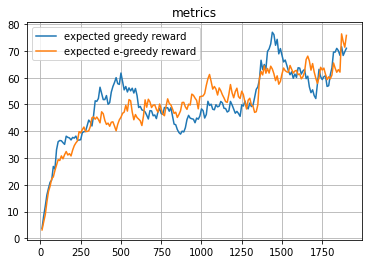

Random session examples


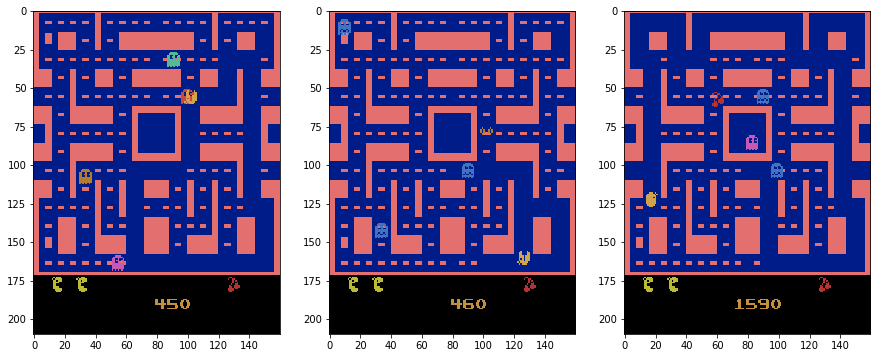

epoch 1910,loss 382.27559, epsilon 0.11664, rewards: ( e-greedy 72.61717, greedy 75.65792) 
rec 380.156 reg 2.120
epoch 1920,loss 543.85896, epsilon 0.11597, rewards: ( e-greedy 73.35545, greedy 75.40463) 
rec 541.724 reg 2.135
epoch 1930,loss 484.28887, epsilon 0.11532, rewards: ( e-greedy 71.20741, greedy 76.67666) 
rec 482.145 reg 2.144
epoch 1940,loss 138.67131, epsilon 0.11467, rewards: ( e-greedy 66.83666, greedy 75.44650) 
rec 136.521 reg 2.150
epoch 1950,loss 996.53302, epsilon 0.11402, rewards: ( e-greedy 66.59050, greedy 72.83935) 
rec 994.372 reg 2.161
epoch 1960,loss 146.02615, epsilon 0.11339, rewards: ( e-greedy 64.43145, greedy 72.55541) 
rec 143.849 reg 2.177
epoch 1970,loss 199.50782, epsilon 0.11276, rewards: ( e-greedy 62.61330, greedy 74.29987) 
rec 197.317 reg 2.191
epoch 1980,loss 590.28453, epsilon 0.11213, rewards: ( e-greedy 62.97697, greedy 72.24488) 
rec 588.085 reg 2.199
epoch 1990,loss 241.68724, epsilon 0.11151, rewards: ( e-greedy 63.92928, greedy 72.1454

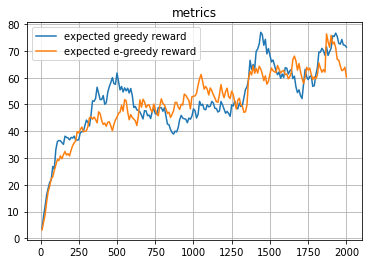

Random session examples


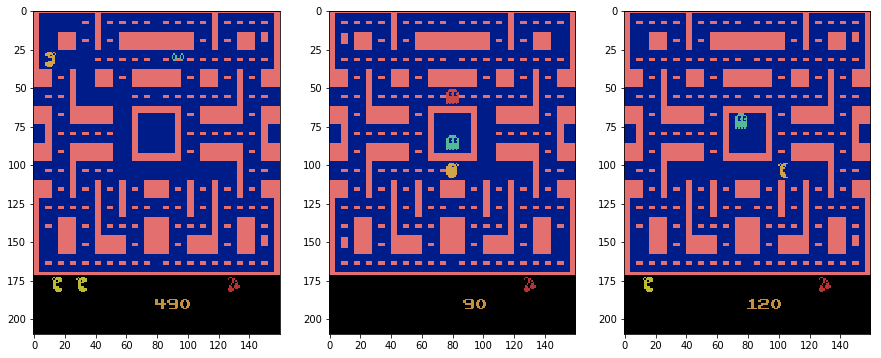

[2017-05-24 02:18:07,261] Making new env: MsPacman-v0
[2017-05-24 02:18:07,425] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 02:18:07,434] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.1.6682.video000000.mp4
[2017-05-24 02:18:09,275] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.1.6682.video000001.mp4


Episode finished after 853 timesteps, rw = 380.0
Episode finished after 729 timesteps, rw = 180.0
Episode finished after 820 timesteps, rw = 370.0
Episode finished after 709 timesteps, rw = 210.0
Episode finished after 909 timesteps, rw = 380.0
Episode finished after 891 timesteps, rw = 450.0
Episode finished after 900 timesteps, rw = 190.0


[2017-05-24 02:18:18,490] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.1.6682.video000008.mp4


Episode finished after 634 timesteps, rw = 140.0
Episode finished after 971 timesteps, rw = 410.0
Episode finished after 725 timesteps, rw = 380.0
Episode finished after 452 timesteps, rw = 60.0
Episode finished after 948 timesteps, rw = 390.0
Episode finished after 922 timesteps, rw = 180.0
Episode finished after 631 timesteps, rw = 400.0
Episode finished after 795 timesteps, rw = 180.0
Episode finished after 856 timesteps, rw = 180.0
Episode finished after 926 timesteps, rw = 180.0
Episode finished after 731 timesteps, rw = 1580.0
Episode finished after 566 timesteps, rw = 180.0


[2017-05-24 02:18:33,963] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 984 timesteps, rw = 590.0
Mean 350.5, Var 96904.75
epoch 2010,loss 5188.52282, epsilon 0.11029, rewards: ( e-greedy 70.19521, greedy 67.66277) 
rec 5186.290 reg 2.233
epoch 2020,loss 123.27150, epsilon 0.10969, rewards: ( e-greedy 67.73819, greedy 69.20899) 
rec 121.025 reg 2.246
epoch 2030,loss 233.90111, epsilon 0.10910, rewards: ( e-greedy 67.33937, greedy 67.10059) 
rec 231.647 reg 2.254
epoch 2040,loss 455.10694, epsilon 0.10851, rewards: ( e-greedy 68.04294, greedy 65.26553) 
rec 452.848 reg 2.259
epoch 2050,loss 1324.32566, epsilon 0.10793, rewards: ( e-greedy 69.98864, greedy 64.98898) 
rec 1322.038 reg 2.288
epoch 2060,loss 328.81918, epsilon 0.10735, rewards: ( e-greedy 70.92728, greedy 63.92758) 
rec 326.479 reg 2.340
epoch 2070,loss 182.37979, epsilon 0.10678, rewards: ( e-greedy 69.08455, greedy 61.53482) 
rec 180.011 reg 2.369
epoch 2080,loss 169.16100, epsilon 0.10622, rewards: ( e-greedy 67.61360, greedy 58.69384) 
rec 166.765 reg 2.396
epoch 2090

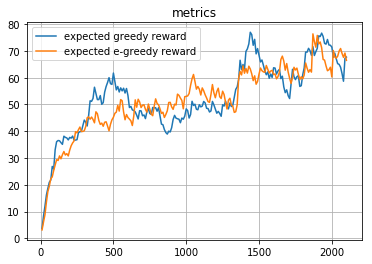

Random session examples


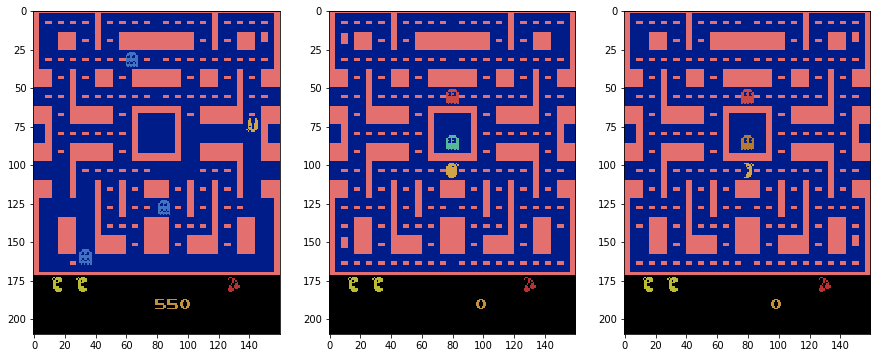

epoch 2110,loss 546.38151, epsilon 0.10456, rewards: ( e-greedy 67.59281, greedy 64.38844) 
rec 543.915 reg 2.466
epoch 2120,loss 655.72839, epsilon 0.10401, rewards: ( e-greedy 69.20853, greedy 64.07459) 
rec 653.249 reg 2.479
epoch 2130,loss 184.09325, epsilon 0.10348, rewards: ( e-greedy 64.60018, greedy 62.22963) 
rec 181.591 reg 2.502
epoch 2140,loss 209.09990, epsilon 0.10294, rewards: ( e-greedy 61.51516, greedy 59.13167) 
rec 206.576 reg 2.524
epoch 2150,loss 351.16424, epsilon 0.10242, rewards: ( e-greedy 63.98864, greedy 65.71850) 
rec 348.633 reg 2.531
epoch 2160,loss 149.18851, epsilon 0.10190, rewards: ( e-greedy 60.27728, greedy 64.27165) 
rec 146.657 reg 2.531
epoch 2170,loss 297.88863, epsilon 0.10138, rewards: ( e-greedy 58.49955, greedy 59.28199) 
rec 295.356 reg 2.533
epoch 2180,loss 235.54673, epsilon 0.10087, rewards: ( e-greedy 56.96210, greedy 60.47879) 
rec 232.997 reg 2.550
epoch 2190,loss 259.92788, epsilon 0.10036, rewards: ( e-greedy 59.20339, greedy 59.8684

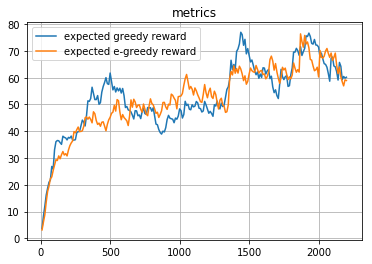

Random session examples


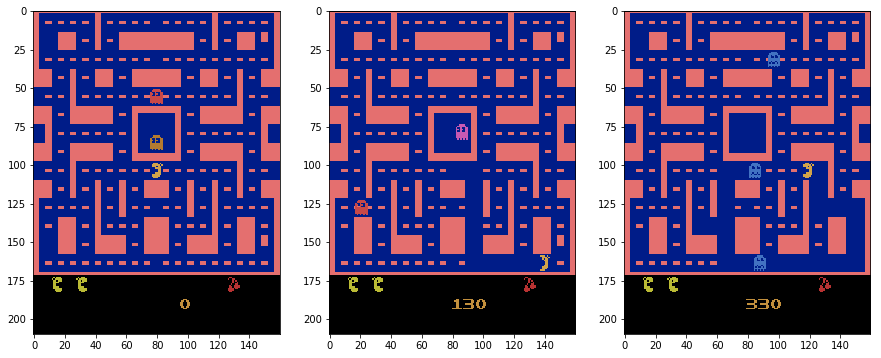

epoch 2210,loss 1140.66683, epsilon 0.09937, rewards: ( e-greedy 62.19849, greedy 58.98716) 
rec 1138.098 reg 2.568
epoch 2220,loss 1377.74632, epsilon 0.09887, rewards: ( e-greedy 66.60364, greedy 66.65095) 
rec 1375.170 reg 2.576
epoch 2230,loss 262.95415, epsilon 0.09839, rewards: ( e-greedy 65.44328, greedy 65.42335) 
rec 260.375 reg 2.579
epoch 2240,loss 514.99429, epsilon 0.09791, rewards: ( e-greedy 65.33645, greedy 72.56852) 
rec 512.407 reg 2.587
epoch 2250,loss 297.68650, epsilon 0.09743, rewards: ( e-greedy 63.11531, greedy 71.43666) 
rec 295.086 reg 2.600
epoch 2260,loss 355.52616, epsilon 0.09696, rewards: ( e-greedy 62.55378, greedy 68.48050) 
rec 352.905 reg 2.621
epoch 2270,loss 473.02565, epsilon 0.09649, rewards: ( e-greedy 66.73590, greedy 68.00745) 
rec 470.374 reg 2.652
epoch 2280,loss 2588.37181, epsilon 0.09603, rewards: ( e-greedy 72.43731, greedy 66.33170) 
rec 2585.703 reg 2.669
epoch 2290,loss 255.80504, epsilon 0.09557, rewards: ( e-greedy 72.13108, greedy 6

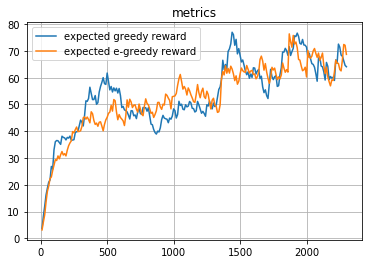

Random session examples


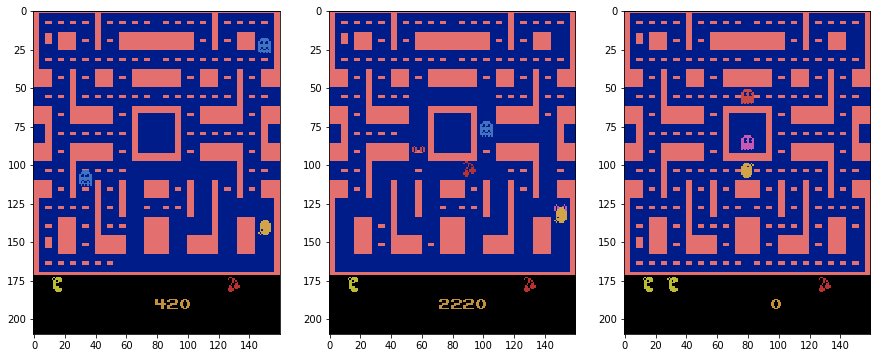

epoch 2310,loss 335.80631, epsilon 0.09467, rewards: ( e-greedy 70.35742, greedy 62.44894) 
rec 333.115 reg 2.691
epoch 2320,loss 721.92056, epsilon 0.09422, rewards: ( e-greedy 70.69668, greedy 61.89154) 
rec 719.236 reg 2.685
epoch 2330,loss 547.66050, epsilon 0.09378, rewards: ( e-greedy 70.62701, greedy 63.45239) 
rec 544.984 reg 2.677
epoch 2340,loss 554.78055, epsilon 0.09335, rewards: ( e-greedy 70.93931, greedy 65.60715) 
rec 552.109 reg 2.672
epoch 2350,loss 1007.54374, epsilon 0.09292, rewards: ( e-greedy 76.03288, greedy 67.60893) 
rec 1004.877 reg 2.667
epoch 2360,loss 597.78904, epsilon 0.09249, rewards: ( e-greedy 74.36709, greedy 70.78554) 
rec 595.123 reg 2.666
epoch 2370,loss 233.14204, epsilon 0.09207, rewards: ( e-greedy 73.18038, greedy 69.51949) 
rec 230.469 reg 2.673
epoch 2380,loss 679.31181, epsilon 0.09165, rewards: ( e-greedy 73.17484, greedy 70.06754) 
rec 676.634 reg 2.678
epoch 2390,loss 1377.25136, epsilon 0.09123, rewards: ( e-greedy 74.79486, greedy 72.6

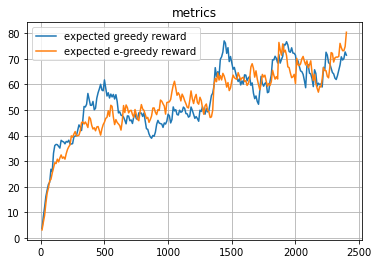

Random session examples


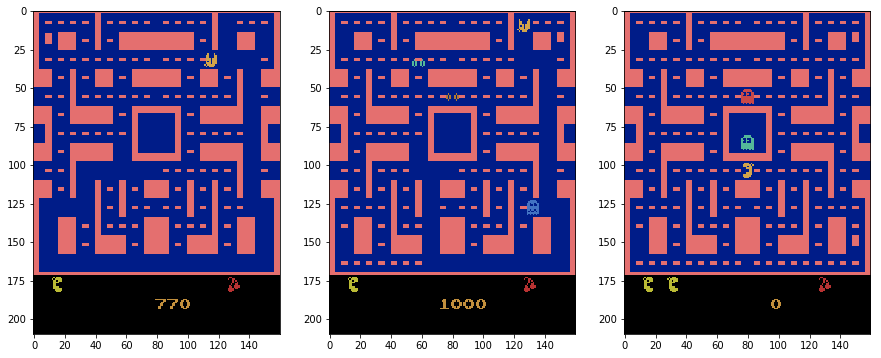

epoch 2410,loss 191.22775, epsilon 0.09042, rewards: ( e-greedy 77.96509, greedy 73.52549) 
rec 188.522 reg 2.705
epoch 2420,loss 875.94386, epsilon 0.09001, rewards: ( e-greedy 81.73108, greedy 72.17294) 
rec 873.221 reg 2.723
epoch 2430,loss 259.32979, epsilon 0.08962, rewards: ( e-greedy 76.37047, greedy 68.83064) 
rec 256.585 reg 2.744
epoch 2440,loss 1813.21961, epsilon 0.08922, rewards: ( e-greedy 78.67092, greedy 66.01008) 
rec 1810.455 reg 2.765
epoch 2450,loss 209.44860, epsilon 0.08883, rewards: ( e-greedy 76.61633, greedy 70.53407) 
rec 206.666 reg 2.782
epoch 2460,loss 3807.55339, epsilon 0.08845, rewards: ( e-greedy 79.89220, greedy 70.98066) 
rec 3804.762 reg 2.791
epoch 2470,loss 282.59929, epsilon 0.08806, rewards: ( e-greedy 79.96548, greedy 78.13260) 
rec 279.799 reg 2.800
epoch 2480,loss 1525.25292, epsilon 0.08768, rewards: ( e-greedy 77.96893, greedy 75.38184) 
rec 1522.434 reg 2.819
epoch 2490,loss 890.10026, epsilon 0.08731, rewards: ( e-greedy 75.85954, greedy 7

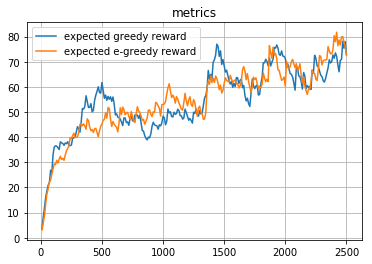

Random session examples


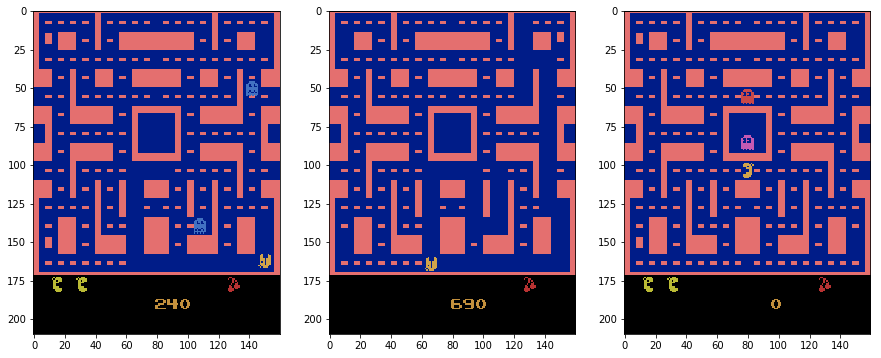

epoch 2510,loss 501.69125, epsilon 0.08657, rewards: ( e-greedy 69.32748, greedy 73.62398) 
rec 498.842 reg 2.849
epoch 2520,loss 2244.45743, epsilon 0.08621, rewards: ( e-greedy 75.01973, greedy 69.51159) 
rec 2241.596 reg 2.861
epoch 2530,loss 1073.14382, epsilon 0.08585, rewards: ( e-greedy 78.64275, greedy 70.56043) 
rec 1070.277 reg 2.867
epoch 2540,loss 277.21913, epsilon 0.08549, rewards: ( e-greedy 78.27848, greedy 69.81688) 
rec 274.352 reg 2.867
epoch 2550,loss 320.75811, epsilon 0.08514, rewards: ( e-greedy 77.51313, greedy 70.83520) 
rec 317.884 reg 2.874
epoch 2560,loss 475.66467, epsilon 0.08479, rewards: ( e-greedy 75.44932, greedy 70.81418) 
rec 472.776 reg 2.889
epoch 2570,loss 217.31306, epsilon 0.08444, rewards: ( e-greedy 73.59189, greedy 71.04526) 
rec 214.416 reg 2.897
epoch 2580,loss 186.76922, epsilon 0.08410, rewards: ( e-greedy 70.79520, greedy 71.19073) 
rec 183.864 reg 2.905
epoch 2590,loss 1216.23818, epsilon 0.08376, rewards: ( e-greedy 75.27818, greedy 76

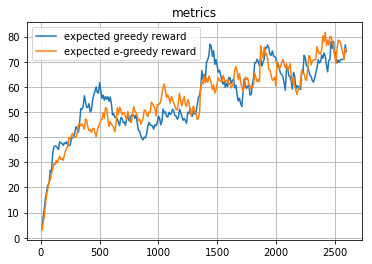

Random session examples


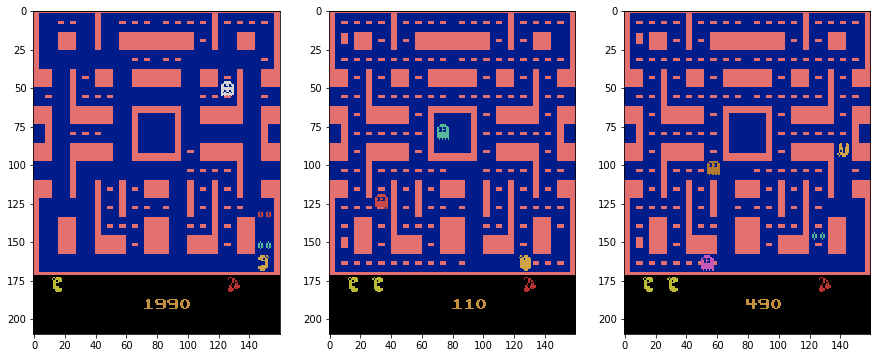

epoch 2610,loss 3472.71187, epsilon 0.08309, rewards: ( e-greedy 87.91282, greedy 76.61867) 
rec 3469.806 reg 2.905
epoch 2620,loss 230.39533, epsilon 0.08276, rewards: ( e-greedy 84.74654, greedy 78.14430) 
rec 227.488 reg 2.908
epoch 2630,loss 395.38079, epsilon 0.08244, rewards: ( e-greedy 83.95939, greedy 80.01737) 
rec 392.476 reg 2.905
epoch 2640,loss 1047.09144, epsilon 0.08211, rewards: ( e-greedy 85.18845, greedy 76.01564) 
rec 1044.191 reg 2.901
epoch 2650,loss 1169.23479, epsilon 0.08179, rewards: ( e-greedy 83.85710, greedy 76.22657) 
rec 1166.332 reg 2.903
epoch 2660,loss 168.33493, epsilon 0.08148, rewards: ( e-greedy 78.47139, greedy 72.60391) 
rec 165.434 reg 2.901
epoch 2670,loss 229.09025, epsilon 0.08116, rewards: ( e-greedy 75.68675, greedy 73.03102) 
rec 226.181 reg 2.910
epoch 2680,loss 227.96361, epsilon 0.08085, rewards: ( e-greedy 71.80558, greedy 74.54042) 
rec 225.047 reg 2.917
epoch 2690,loss 172.72533, epsilon 0.08055, rewards: ( e-greedy 69.06252, greedy 7

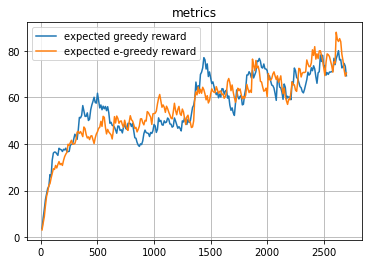

Random session examples


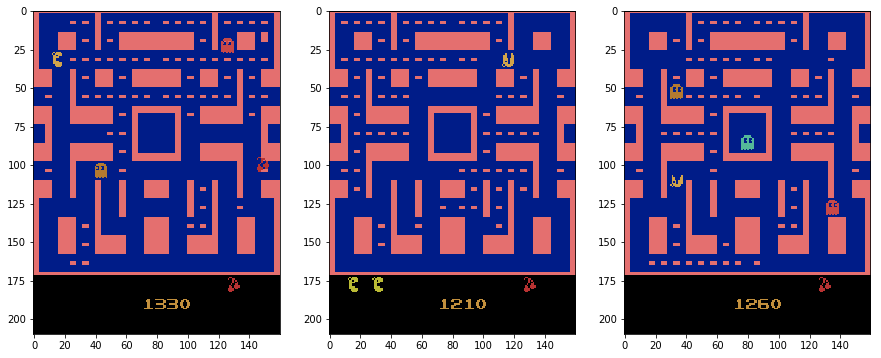

epoch 2710,loss 394.90477, epsilon 0.07994, rewards: ( e-greedy 67.80314, greedy 67.51497) 
rec 391.962 reg 2.943
epoch 2720,loss 262.85282, epsilon 0.07964, rewards: ( e-greedy 65.27283, greedy 63.95097) 
rec 259.884 reg 2.969
epoch 2730,loss 1958.57400, epsilon 0.07935, rewards: ( e-greedy 68.30804, greedy 63.30587) 
rec 1955.597 reg 2.977
epoch 2740,loss 213.55487, epsilon 0.07906, rewards: ( e-greedy 66.97724, greedy 64.03779) 
rec 210.576 reg 2.979
epoch 2750,loss 220.89223, epsilon 0.07877, rewards: ( e-greedy 66.59202, greedy 63.32151) 
rec 217.900 reg 2.992
epoch 2760,loss 191.01182, epsilon 0.07848, rewards: ( e-greedy 64.62031, greedy 62.36436) 
rec 188.012 reg 2.999
epoch 2770,loss 1888.01790, epsilon 0.07820, rewards: ( e-greedy 68.65828, greedy 62.19042) 
rec 1885.011 reg 3.007
epoch 2780,loss 1278.02510, epsilon 0.07792, rewards: ( e-greedy 69.60495, greedy 58.53388) 
rec 1275.005 reg 3.020
epoch 2790,loss 607.21139, epsilon 0.07764, rewards: ( e-greedy 69.83196, greedy 6

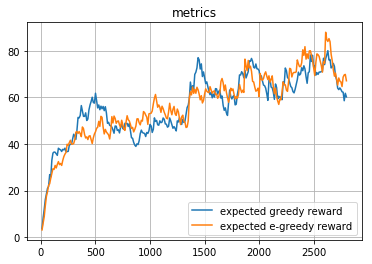

Random session examples


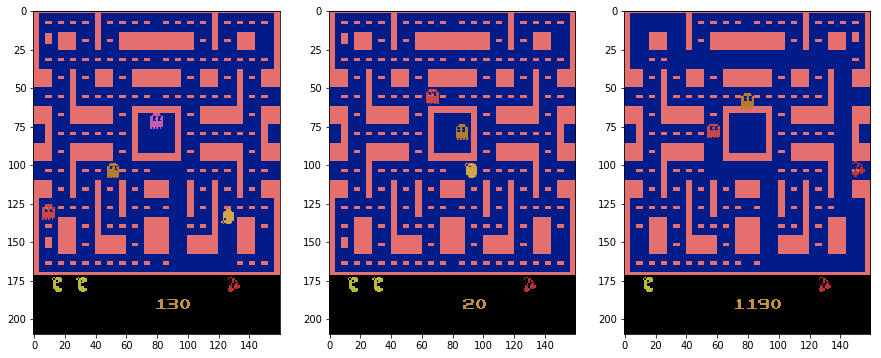

epoch 2810,loss 337.47554, epsilon 0.07709, rewards: ( e-greedy 68.01389, greedy 58.61182) 
rec 334.437 reg 3.039
epoch 2820,loss 224.22256, epsilon 0.07682, rewards: ( e-greedy 64.83750, greedy 58.31314) 
rec 221.185 reg 3.038
epoch 2830,loss 580.14590, epsilon 0.07656, rewards: ( e-greedy 65.47875, greedy 56.91933) 
rec 577.109 reg 3.036
epoch 2840,loss 213.70009, epsilon 0.07629, rewards: ( e-greedy 63.30587, greedy 55.53989) 
rec 210.668 reg 3.032
epoch 2850,loss 190.89761, epsilon 0.07603, rewards: ( e-greedy 60.60029, greedy 53.73590) 
rec 187.863 reg 3.035
epoch 2860,loss 357.41017, epsilon 0.07577, rewards: ( e-greedy 61.72776, greedy 53.17481) 
rec 354.373 reg 3.037
epoch 2870,loss 598.42193, epsilon 0.07551, rewards: ( e-greedy 62.92998, greedy 52.79483) 
rec 595.376 reg 3.046
epoch 2880,loss 812.33342, epsilon 0.07526, rewards: ( e-greedy 63.13698, greedy 52.45285) 
rec 809.276 reg 3.058
epoch 2890,loss 2984.34338, epsilon 0.07501, rewards: ( e-greedy 72.51079, greedy 54.332

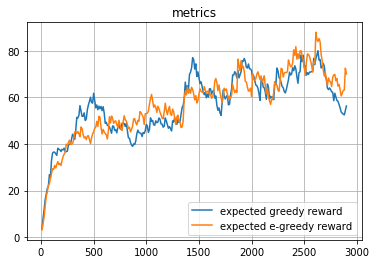

Random session examples


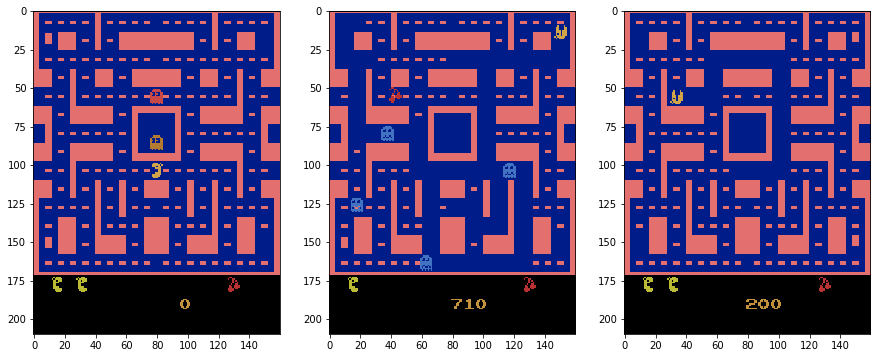

epoch 2910,loss 1038.32437, epsilon 0.07451, rewards: ( e-greedy 70.62749, greedy 55.64688) 
rec 1035.253 reg 3.071
epoch 2920,loss 203.51209, epsilon 0.07427, rewards: ( e-greedy 69.56474, greedy 60.58219) 
rec 200.446 reg 3.066
epoch 2930,loss 485.40437, epsilon 0.07403, rewards: ( e-greedy 69.04576, greedy 59.33647) 
rec 482.342 reg 3.063
epoch 2940,loss 244.11686, epsilon 0.07379, rewards: ( e-greedy 67.57869, greedy 58.27782) 
rec 241.058 reg 3.059
epoch 2950,loss 214.44042, epsilon 0.07355, rewards: ( e-greedy 65.00832, greedy 57.45004) 
rec 211.379 reg 3.062
epoch 2960,loss 555.00681, epsilon 0.07332, rewards: ( e-greedy 66.13249, greedy 59.26754) 
rec 551.947 reg 3.059
epoch 2970,loss 1435.33985, epsilon 0.07309, rewards: ( e-greedy 68.26924, greedy 58.34078) 
rec 1432.276 reg 3.064
epoch 2980,loss 692.33398, epsilon 0.07286, rewards: ( e-greedy 70.00481, greedy 61.00670) 
rec 689.266 reg 3.068
epoch 2990,loss 497.06597, epsilon 0.07263, rewards: ( e-greedy 69.12933, greedy 62.

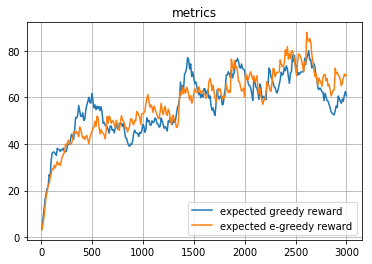

Random session examples


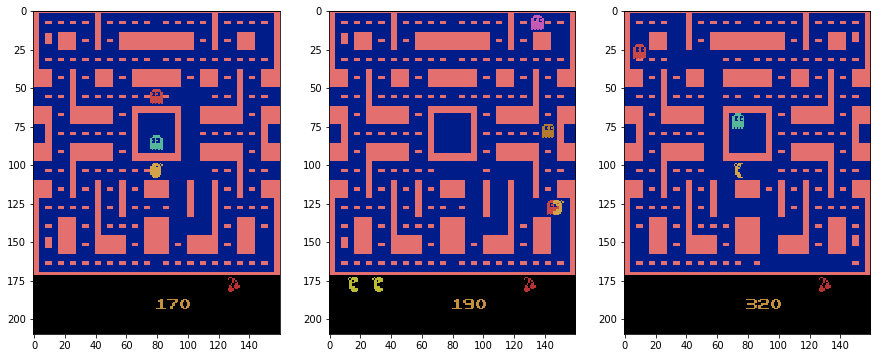

[2017-05-24 02:43:43,692] Making new env: MsPacman-v0
[2017-05-24 02:43:43,861] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 02:43:43,871] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.2.6682.video000000.mp4
[2017-05-24 02:43:45,730] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.2.6682.video000001.mp4


Episode finished after 839 timesteps, rw = 500.0
Episode finished after 668 timesteps, rw = 410.0
Episode finished after 531 timesteps, rw = 400.0
Episode finished after 366 timesteps, rw = 160.0
Episode finished after 461 timesteps, rw = 230.0
Episode finished after 625 timesteps, rw = 430.0
Episode finished after 500 timesteps, rw = 210.0


[2017-05-24 02:43:52,553] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.2.6682.video000008.mp4


Episode finished after 849 timesteps, rw = 470.0
Episode finished after 783 timesteps, rw = 440.0
Episode finished after 505 timesteps, rw = 210.0
Episode finished after 510 timesteps, rw = 210.0
Episode finished after 632 timesteps, rw = 480.0
Episode finished after 751 timesteps, rw = 500.0
Episode finished after 503 timesteps, rw = 300.0
Episode finished after 1071 timesteps, rw = 480.0
Episode finished after 605 timesteps, rw = 400.0
Episode finished after 464 timesteps, rw = 330.0
Episode finished after 496 timesteps, rw = 300.0
Episode finished after 630 timesteps, rw = 460.0


[2017-05-24 02:44:05,602] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 928 timesteps, rw = 470.0
Mean 369.5, Var 12494.75
epoch 3010,loss 231.87135, epsilon 0.07218, rewards: ( e-greedy 66.32601, greedy 64.08764) 
rec 228.816 reg 3.055
epoch 3020,loss 611.99248, epsilon 0.07196, rewards: ( e-greedy 71.50591, greedy 70.67887) 
rec 608.929 reg 3.064
epoch 3030,loss 306.98358, epsilon 0.07174, rewards: ( e-greedy 70.04282, greedy 70.17349) 
rec 303.907 reg 3.077
epoch 3040,loss 349.18139, epsilon 0.07153, rewards: ( e-greedy 68.97604, greedy 66.59364) 
rec 346.091 reg 3.090
epoch 3050,loss 207.48542, epsilon 0.07131, rewards: ( e-greedy 65.01593, greedy 67.68427) 
rec 204.389 reg 3.096
epoch 3060,loss 566.04912, epsilon 0.07110, rewards: ( e-greedy 66.76434, greedy 68.16585) 
rec 562.955 reg 3.094
epoch 3070,loss 3411.23285, epsilon 0.07089, rewards: ( e-greedy 73.46291, greedy 67.59926) 
rec 3408.138 reg 3.095
epoch 3080,loss 308.66249, epsilon 0.07068, rewards: ( e-greedy 72.49161, greedy 65.77684) 
rec 305.567 reg 3.095
epoch 3090,l

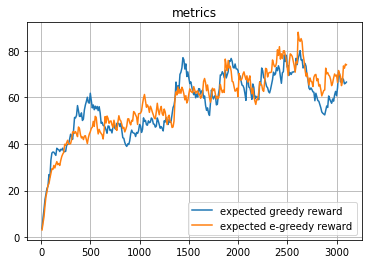

Random session examples


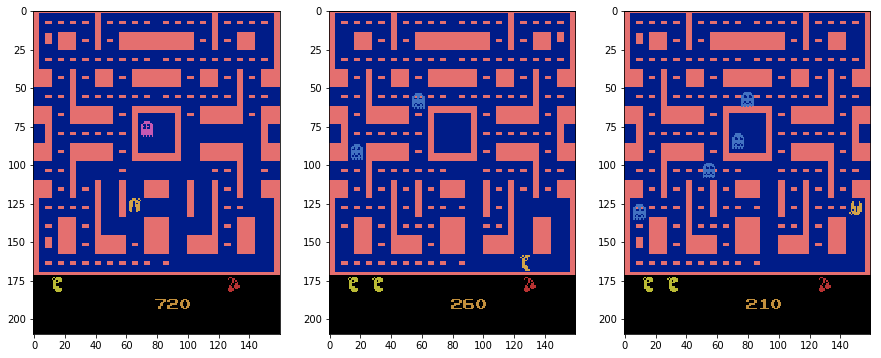

epoch 3110,loss 244.75945, epsilon 0.07007, rewards: ( e-greedy 70.73639, greedy 71.88194) 
rec 241.655 reg 3.104
epoch 3120,loss 367.52370, epsilon 0.06987, rewards: ( e-greedy 69.03775, greedy 73.00624) 
rec 364.398 reg 3.126
epoch 3130,loss 1137.30637, epsilon 0.06967, rewards: ( e-greedy 72.07147, greedy 72.20562) 
rec 1134.160 reg 3.146
epoch 3140,loss 396.09415, epsilon 0.06948, rewards: ( e-greedy 69.30183, greedy 68.23506) 
rec 392.920 reg 3.174
epoch 3150,loss 265.01204, epsilon 0.06928, rewards: ( e-greedy 68.80914, greedy 70.03655) 
rec 261.825 reg 3.187
epoch 3160,loss 174.05628, epsilon 0.06909, rewards: ( e-greedy 66.99073, greedy 67.59540) 
rec 170.870 reg 3.186
epoch 3170,loss 297.75985, epsilon 0.06890, rewards: ( e-greedy 63.47916, greedy 63.39836) 
rec 294.568 reg 3.192
epoch 3180,loss 350.72868, epsilon 0.06871, rewards: ( e-greedy 63.44374, greedy 63.62102) 
rec 347.527 reg 3.202
epoch 3190,loss 443.88707, epsilon 0.06853, rewards: ( e-greedy 63.53687, greedy 65.00

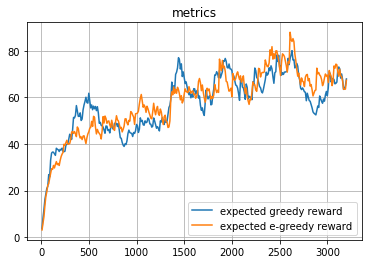

Random session examples


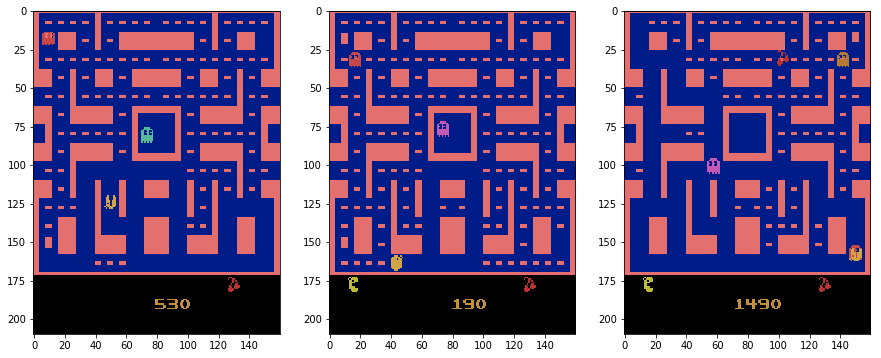

epoch 3210,loss 8964.04921, epsilon 0.06816, rewards: ( e-greedy 85.45236, greedy 71.84472) 
rec 8960.823 reg 3.226
epoch 3220,loss 231.53279, epsilon 0.06798, rewards: ( e-greedy 81.34463, greedy 70.34775) 
rec 228.300 reg 3.233
epoch 3230,loss 1264.04465, epsilon 0.06780, rewards: ( e-greedy 81.64766, greedy 70.00048) 
rec 1260.809 reg 3.235
epoch 3240,loss 854.30077, epsilon 0.06762, rewards: ( e-greedy 83.48290, greedy 90.37543) 
rec 851.066 reg 3.235
epoch 3250,loss 1438.32314, epsilon 0.06745, rewards: ( e-greedy 83.19711, greedy 88.15039) 
rec 1435.073 reg 3.250
epoch 3260,loss 408.73931, epsilon 0.06727, rewards: ( e-greedy 81.93990, greedy 86.21035) 
rec 405.464 reg 3.275
epoch 3270,loss 345.29714, epsilon 0.06710, rewards: ( e-greedy 79.80841, greedy 87.02681) 
rec 341.999 reg 3.298
epoch 3280,loss 576.90857, epsilon 0.06693, rewards: ( e-greedy 78.51507, greedy 88.01163) 
rec 573.563 reg 3.345
epoch 3290,loss 498.61874, epsilon 0.06676, rewards: ( e-greedy 74.78856, greedy 8

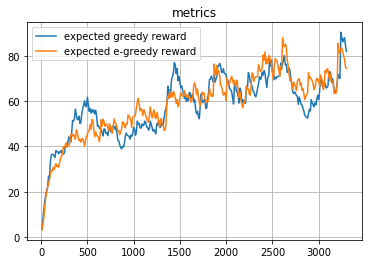

Random session examples


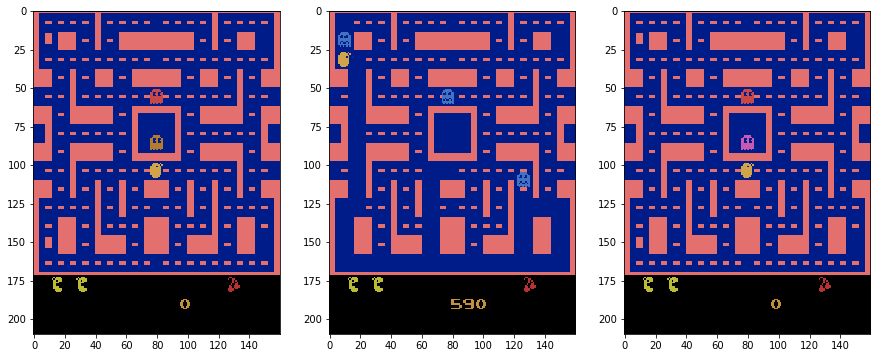

epoch 3310,loss 230.29353, epsilon 0.06643, rewards: ( e-greedy 70.54748, greedy 81.43298) 
rec 226.858 reg 3.435
epoch 3320,loss 379.16712, epsilon 0.06627, rewards: ( e-greedy 68.36773, greedy 78.85218) 
rec 375.711 reg 3.456
epoch 3330,loss 306.55730, epsilon 0.06611, rewards: ( e-greedy 66.96846, greedy 75.90446) 
rec 303.073 reg 3.485
epoch 3340,loss 211.87755, epsilon 0.06595, rewards: ( e-greedy 62.70912, greedy 74.00152) 
rec 208.380 reg 3.497
epoch 3350,loss 1303.68035, epsilon 0.06579, rewards: ( e-greedy 65.81320, greedy 74.10137) 
rec 1300.168 reg 3.512
epoch 3360,loss 295.19861, epsilon 0.06563, rewards: ( e-greedy 67.16938, greedy 72.19123) 
rec 291.680 reg 3.519
epoch 3370,loss 836.58952, epsilon 0.06548, rewards: ( e-greedy 65.70245, greedy 67.34711) 
rec 833.055 reg 3.535
epoch 3380,loss 516.04185, epsilon 0.06532, rewards: ( e-greedy 65.44470, greedy 65.61240) 
rec 512.485 reg 3.557
epoch 3390,loss 656.27319, epsilon 0.06517, rewards: ( e-greedy 66.46273, greedy 68.30

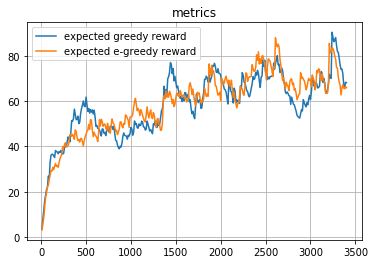

Random session examples


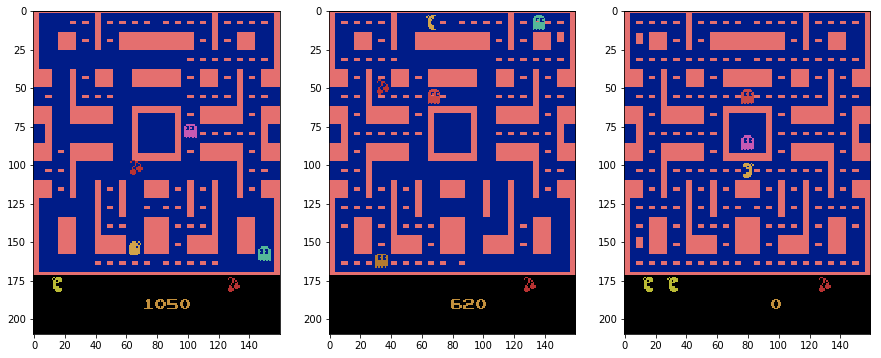

epoch 3410,loss 945.62529, epsilon 0.06487, rewards: ( e-greedy 70.22856, greedy 73.09269) 
rec 942.026 reg 3.600
epoch 3420,loss 589.79149, epsilon 0.06472, rewards: ( e-greedy 72.70571, greedy 73.28342) 
rec 586.175 reg 3.617
epoch 3430,loss 288.54957, epsilon 0.06457, rewards: ( e-greedy 70.87263, greedy 71.14258) 
rec 284.919 reg 3.630
epoch 3440,loss 1964.02780, epsilon 0.06443, rewards: ( e-greedy 75.53537, greedy 78.15332) 
rec 1960.391 reg 3.637
epoch 3450,loss 746.63145, epsilon 0.06429, rewards: ( e-greedy 80.10683, greedy 76.90049) 
rec 742.993 reg 3.638
epoch 3460,loss 1733.62920, epsilon 0.06414, rewards: ( e-greedy 80.47115, greedy 75.14794) 
rec 1729.978 reg 3.651
epoch 3470,loss 300.43446, epsilon 0.06400, rewards: ( e-greedy 76.61154, greedy 72.82064) 
rec 296.763 reg 3.672
epoch 3480,loss 225.85001, epsilon 0.06386, rewards: ( e-greedy 74.63788, greedy 76.72608) 
rec 222.171 reg 3.679
epoch 3490,loss 218.04220, epsilon 0.06373, rewards: ( e-greedy 72.54909, greedy 74.

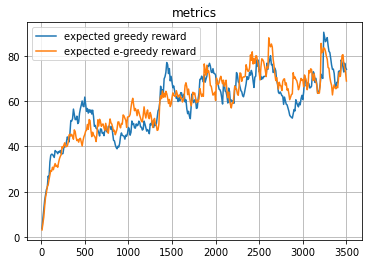

Random session examples


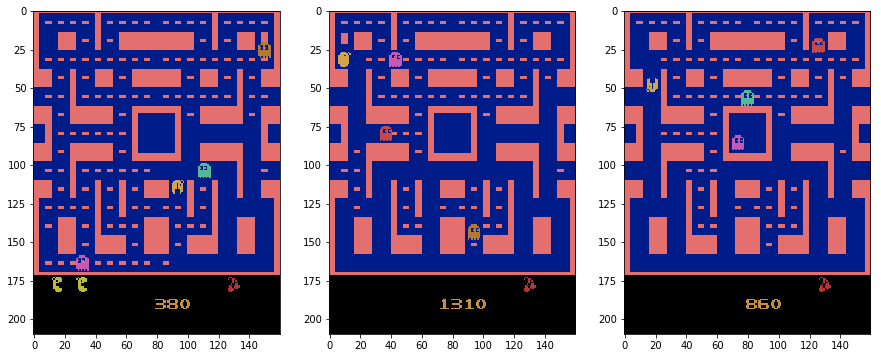

epoch 3510,loss 541.59702, epsilon 0.06345, rewards: ( e-greedy 68.22102, greedy 74.24019) 
rec 537.858 reg 3.739
epoch 3520,loss 240.52904, epsilon 0.06332, rewards: ( e-greedy 67.27391, greedy 74.56617) 
rec 236.787 reg 3.742
epoch 3530,loss 221.51796, epsilon 0.06319, rewards: ( e-greedy 65.48402, greedy 72.60955) 
rec 217.762 reg 3.756
epoch 3540,loss 698.39225, epsilon 0.06306, rewards: ( e-greedy 66.81062, greedy 71.91110) 
rec 694.623 reg 3.769
epoch 3550,loss 347.90063, epsilon 0.06293, rewards: ( e-greedy 67.94206, greedy 71.96999) 
rec 344.123 reg 3.778
epoch 3560,loss 527.30597, epsilon 0.06280, rewards: ( e-greedy 70.58535, greedy 74.46049) 
rec 523.523 reg 3.783
epoch 3570,loss 197.55194, epsilon 0.06267, rewards: ( e-greedy 67.46432, greedy 71.88944) 
rec 193.772 reg 3.780
epoch 3580,loss 332.87770, epsilon 0.06254, rewards: ( e-greedy 67.78039, greedy 72.07550) 
rec 329.105 reg 3.773
epoch 3590,loss 170.36907, epsilon 0.06242, rewards: ( e-greedy 65.43985, greedy 70.0554

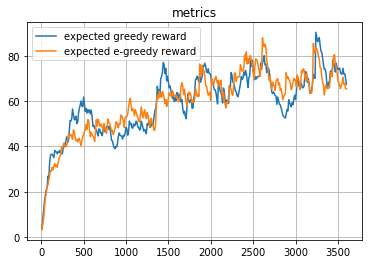

Random session examples


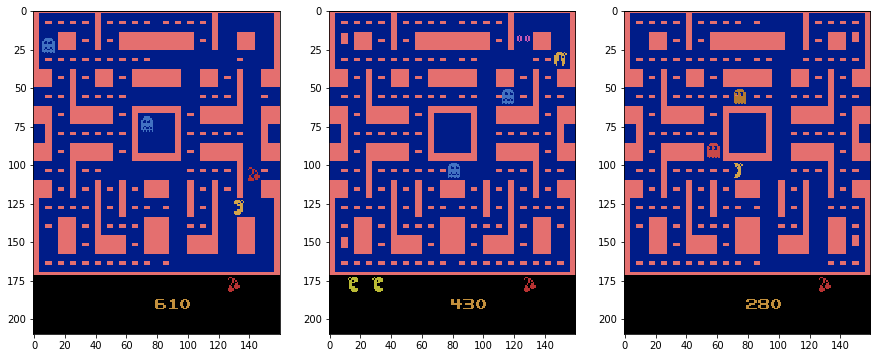

epoch 3610,loss 778.48516, epsilon 0.06217, rewards: ( e-greedy 68.30003, greedy 71.12616) 
rec 774.732 reg 3.753
epoch 3620,loss 775.68541, epsilon 0.06205, rewards: ( e-greedy 70.34502, greedy 75.57604) 
rec 771.936 reg 3.749
epoch 3630,loss 504.31985, epsilon 0.06193, rewards: ( e-greedy 70.18552, greedy 75.20594) 
rec 500.569 reg 3.751
epoch 3640,loss 356.81143, epsilon 0.06181, rewards: ( e-greedy 68.85447, greedy 70.87285) 
rec 353.053 reg 3.759
epoch 3650,loss 212.33532, epsilon 0.06170, rewards: ( e-greedy 67.40652, greedy 72.91056) 
rec 208.572 reg 3.763
epoch 3660,loss 1832.26894, epsilon 0.06158, rewards: ( e-greedy 71.35337, greedy 74.55701) 
rec 1828.507 reg 3.762
epoch 3670,loss 255.62986, epsilon 0.06146, rewards: ( e-greedy 70.15553, greedy 78.10131) 
rec 251.854 reg 3.776
epoch 3680,loss 624.52075, epsilon 0.06135, rewards: ( e-greedy 70.82748, greedy 76.79117) 
rec 620.731 reg 3.790
epoch 3690,loss 844.13416, epsilon 0.06124, rewards: ( e-greedy 75.86973, greedy 78.11

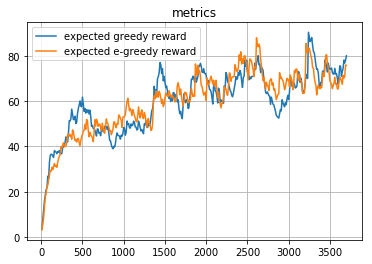

Random session examples


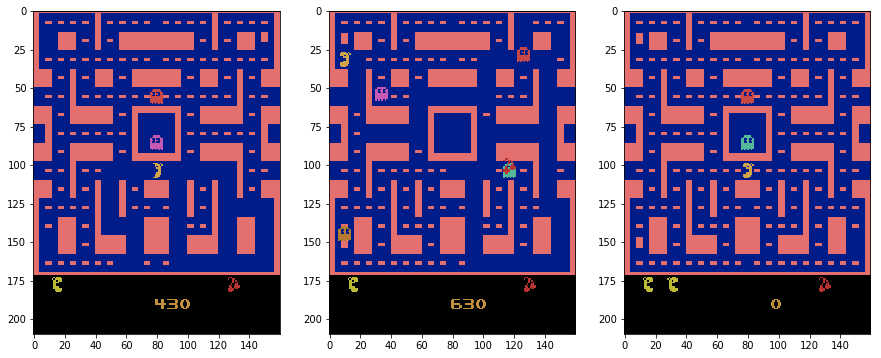

epoch 3710,loss 1039.43283, epsilon 0.06101, rewards: ( e-greedy 76.57948, greedy 80.36452) 
rec 1035.626 reg 3.807
epoch 3720,loss 2026.53483, epsilon 0.06091, rewards: ( e-greedy 79.85903, greedy 78.45306) 
rec 2022.711 reg 3.823
epoch 3730,loss 603.78478, epsilon 0.06080, rewards: ( e-greedy 80.37313, greedy 76.73276) 
rec 599.932 reg 3.853
epoch 3740,loss 307.95175, epsilon 0.06069, rewards: ( e-greedy 75.39832, greedy 78.24698) 
rec 304.063 reg 3.888
epoch 3750,loss 451.81236, epsilon 0.06058, rewards: ( e-greedy 76.10849, greedy 77.17228) 
rec 447.905 reg 3.907
epoch 3760,loss 439.20050, epsilon 0.06048, rewards: ( e-greedy 78.12264, greedy 77.58006) 
rec 435.285 reg 3.915
epoch 3770,loss 1444.23373, epsilon 0.06037, rewards: ( e-greedy 81.81037, greedy 79.57205) 
rec 1440.319 reg 3.915
epoch 3780,loss 255.63313, epsilon 0.06027, rewards: ( e-greedy 77.44184, greedy 77.61485) 
rec 251.718 reg 3.915
epoch 3790,loss 168.97606, epsilon 0.06017, rewards: ( e-greedy 72.26015, greedy 7

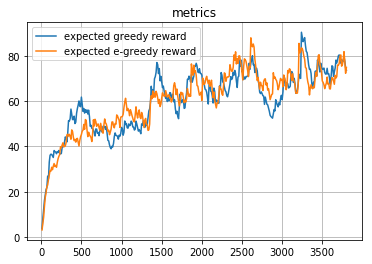

Random session examples


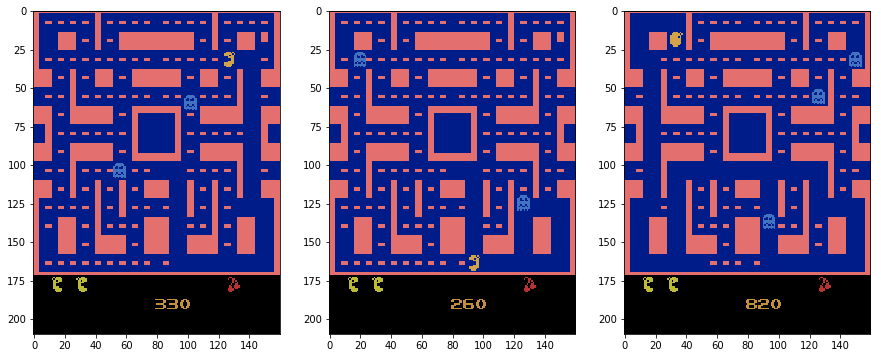

epoch 3810,loss 506.82158, epsilon 0.05997, rewards: ( e-greedy 70.23697, greedy 70.83560) 
rec 502.907 reg 3.915
epoch 3820,loss 3508.21606, epsilon 0.05987, rewards: ( e-greedy 74.46328, greedy 70.68954) 
rec 3504.300 reg 3.916
epoch 3830,loss 614.96821, epsilon 0.05977, rewards: ( e-greedy 73.51695, greedy 72.62058) 
rec 611.050 reg 3.918
epoch 3840,loss 258.17773, epsilon 0.05967, rewards: ( e-greedy 73.54025, greedy 74.42103) 
rec 254.257 reg 3.921
epoch 3850,loss 1440.72187, epsilon 0.05958, rewards: ( e-greedy 73.93623, greedy 71.85392) 
rec 1436.791 reg 3.931
epoch 3860,loss 525.41684, epsilon 0.05948, rewards: ( e-greedy 76.60511, greedy 79.16853) 
rec 521.475 reg 3.942
epoch 3870,loss 4347.62936, epsilon 0.05939, rewards: ( e-greedy 87.81960, greedy 76.18918) 
rec 4343.680 reg 3.949
epoch 3880,loss 252.18815, epsilon 0.05929, rewards: ( e-greedy 82.03764, greedy 75.82026) 
rec 248.224 reg 3.964
epoch 3890,loss 341.73613, epsilon 0.05920, rewards: ( e-greedy 78.77137, greedy 7

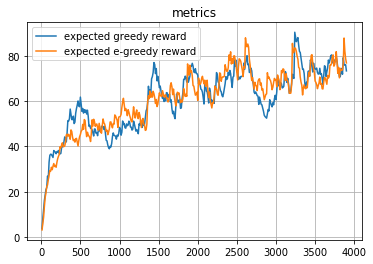

Random session examples


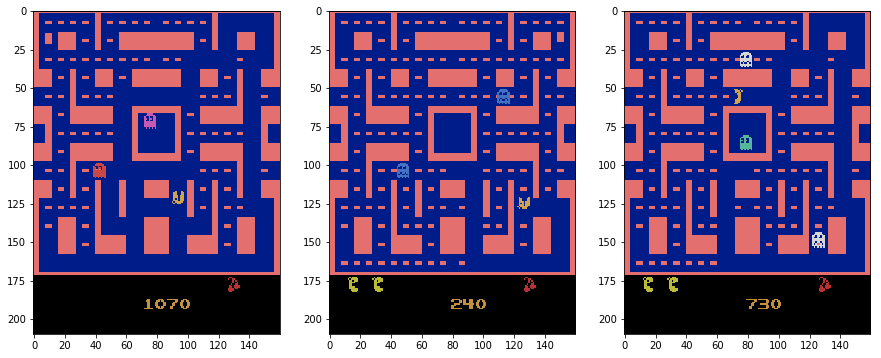

epoch 3910,loss 687.41522, epsilon 0.05902, rewards: ( e-greedy 77.64856, greedy 78.42609) 
rec 683.413 reg 4.002
epoch 3920,loss 269.34877, epsilon 0.05893, rewards: ( e-greedy 75.88371, greedy 75.52098) 
rec 265.345 reg 4.004
epoch 3930,loss 579.30078, epsilon 0.05884, rewards: ( e-greedy 74.48283, greedy 71.59389) 
rec 575.301 reg 4.000
epoch 3940,loss 286.67447, epsilon 0.05875, rewards: ( e-greedy 72.47205, greedy 68.37200) 
rec 282.675 reg 4.000
epoch 3950,loss 272.18228, epsilon 0.05866, rewards: ( e-greedy 70.28735, greedy 72.78480) 
rec 268.186 reg 3.997
epoch 3960,loss 550.85376, epsilon 0.05858, rewards: ( e-greedy 71.25861, greedy 73.63132) 
rec 546.854 reg 3.999
epoch 3970,loss 1415.79823, epsilon 0.05849, rewards: ( e-greedy 74.00775, greedy 74.51819) 
rec 1411.795 reg 4.003
epoch 3980,loss 2392.69049, epsilon 0.05841, rewards: ( e-greedy 78.10698, greedy 77.56637) 
rec 2388.685 reg 4.006
epoch 3990,loss 602.01479, epsilon 0.05832, rewards: ( e-greedy 76.98378, greedy 79.

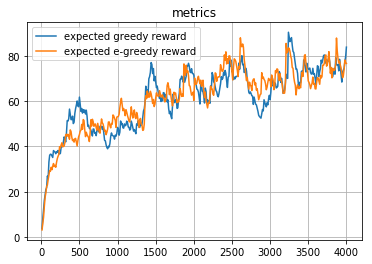

Random session examples


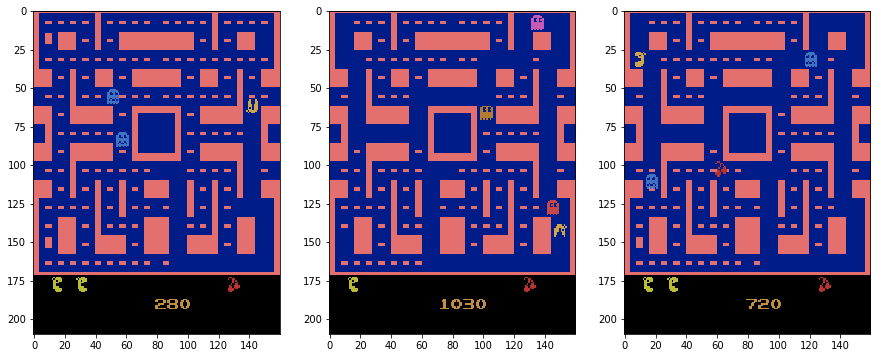

[2017-05-24 03:09:22,449] Making new env: MsPacman-v0
[2017-05-24 03:09:22,619] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 03:09:22,628] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.3.6682.video000000.mp4
[2017-05-24 03:09:24,747] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.3.6682.video000001.mp4


Episode finished after 1004 timesteps, rw = 440.0
Episode finished after 1035 timesteps, rw = 440.0
Episode finished after 879 timesteps, rw = 240.0
Episode finished after 1007 timesteps, rw = 240.0
Episode finished after 899 timesteps, rw = 280.0
Episode finished after 926 timesteps, rw = 440.0
Episode finished after 1051 timesteps, rw = 440.0


[2017-05-24 03:09:35,673] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.3.6682.video000008.mp4


Episode finished after 824 timesteps, rw = 240.0
Episode finished after 913 timesteps, rw = 850.0
Episode finished after 797 timesteps, rw = 860.0
Episode finished after 928 timesteps, rw = 440.0
Episode finished after 879 timesteps, rw = 440.0
Episode finished after 1061 timesteps, rw = 250.0
Episode finished after 821 timesteps, rw = 440.0
Episode finished after 951 timesteps, rw = 440.0
Episode finished after 968 timesteps, rw = 630.0
Episode finished after 821 timesteps, rw = 920.0
Episode finished after 800 timesteps, rw = 440.0
Episode finished after 878 timesteps, rw = 320.0


[2017-05-24 03:09:53,455] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 1103 timesteps, rw = 240.0
Mean 451.5, Var 42222.75
epoch 4010,loss 5874.88867, epsilon 0.05816, rewards: ( e-greedy 87.18811, greedy 83.59963) 
rec 5870.895 reg 3.994
epoch 4020,loss 1245.47092, epsilon 0.05808, rewards: ( e-greedy 84.40680, greedy 79.67717) 
rec 1241.448 reg 4.023
epoch 4030,loss 229.64292, epsilon 0.05800, rewards: ( e-greedy 79.71612, greedy 74.89695) 
rec 225.574 reg 4.069
epoch 4040,loss 524.81447, epsilon 0.05792, rewards: ( e-greedy 79.05701, greedy 72.09476) 
rec 520.712 reg 4.102
epoch 4050,loss 199.67573, epsilon 0.05784, rewards: ( e-greedy 77.33881, greedy 72.82278) 
rec 195.557 reg 4.119
epoch 4060,loss 217.15564, epsilon 0.05776, rewards: ( e-greedy 72.22993, greedy 69.22800) 
rec 213.030 reg 4.126
epoch 4070,loss 413.11687, epsilon 0.05768, rewards: ( e-greedy 72.00693, greedy 71.43020) 
rec 408.993 reg 4.124
epoch 4080,loss 598.67942, epsilon 0.05761, rewards: ( e-greedy 72.93124, greedy 76.22468) 
rec 594.555 reg 4.125
epoch 409

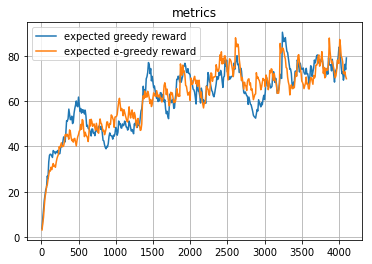

Random session examples


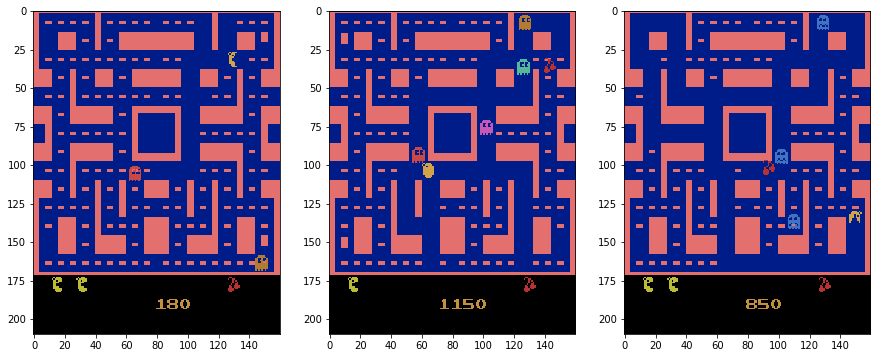

epoch 4110,loss 554.91560, epsilon 0.05738, rewards: ( e-greedy 71.68812, greedy 76.80842) 
rec 550.780 reg 4.136
epoch 4120,loss 693.48670, epsilon 0.05731, rewards: ( e-greedy 71.01931, greedy 76.94008) 
rec 689.356 reg 4.131
epoch 4130,loss 1159.79997, epsilon 0.05724, rewards: ( e-greedy 73.41738, greedy 79.99607) 
rec 1155.672 reg 4.128
epoch 4140,loss 527.20563, epsilon 0.05717, rewards: ( e-greedy 71.63814, greedy 78.55896) 
rec 523.065 reg 4.141
epoch 4150,loss 548.79837, epsilon 0.05709, rewards: ( e-greedy 70.53683, greedy 79.07807) 
rec 544.648 reg 4.151
epoch 4160,loss 3148.93067, epsilon 0.05702, rewards: ( e-greedy 73.42065, greedy 76.92026) 
rec 3144.775 reg 4.155
epoch 4170,loss 253.58176, epsilon 0.05695, rewards: ( e-greedy 72.14108, greedy 75.72823) 
rec 249.412 reg 4.170
epoch 4180,loss 486.63557, epsilon 0.05688, rewards: ( e-greedy 73.30197, greedy 77.53041) 
rec 482.426 reg 4.210
epoch 4190,loss 1781.73576, epsilon 0.05682, rewards: ( e-greedy 75.90928, greedy 80

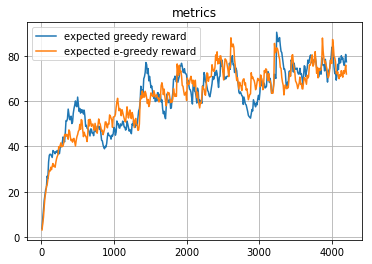

Random session examples


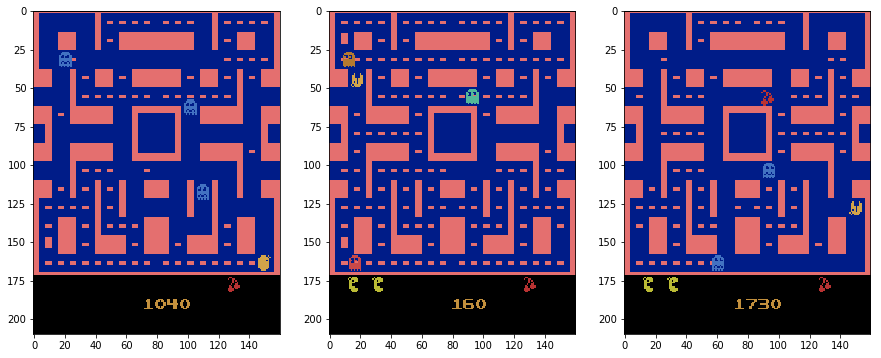

epoch 4210,loss 619.33034, epsilon 0.05668, rewards: ( e-greedy 74.06151, greedy 74.98404) 
rec 615.011 reg 4.319
epoch 4220,loss 1058.97266, epsilon 0.05661, rewards: ( e-greedy 75.90536, greedy 75.04814) 
rec 1054.637 reg 4.336
epoch 4230,loss 863.46033, epsilon 0.05655, rewards: ( e-greedy 76.75233, greedy 74.91833) 
rec 859.123 reg 4.338
epoch 4240,loss 1876.39431, epsilon 0.05648, rewards: ( e-greedy 81.32709, greedy 77.48899) 
rec 1872.061 reg 4.333
epoch 4250,loss 1423.05004, epsilon 0.05642, rewards: ( e-greedy 83.31938, greedy 75.74009) 
rec 1418.729 reg 4.322
epoch 4260,loss 263.67071, epsilon 0.05636, rewards: ( e-greedy 79.98745, greedy 73.60358) 
rec 259.365 reg 4.306
epoch 4270,loss 228.90063, epsilon 0.05629, rewards: ( e-greedy 77.61370, greedy 74.80573) 
rec 224.610 reg 4.291
epoch 4280,loss 448.37611, epsilon 0.05623, rewards: ( e-greedy 74.97733, greedy 72.45015) 
rec 444.090 reg 4.287
epoch 4290,loss 475.97059, epsilon 0.05617, rewards: ( e-greedy 77.16710, greedy 7

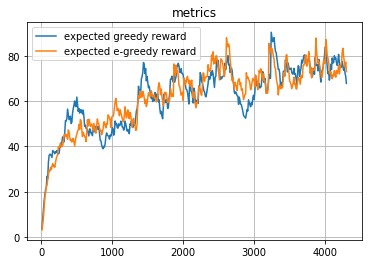

Random session examples


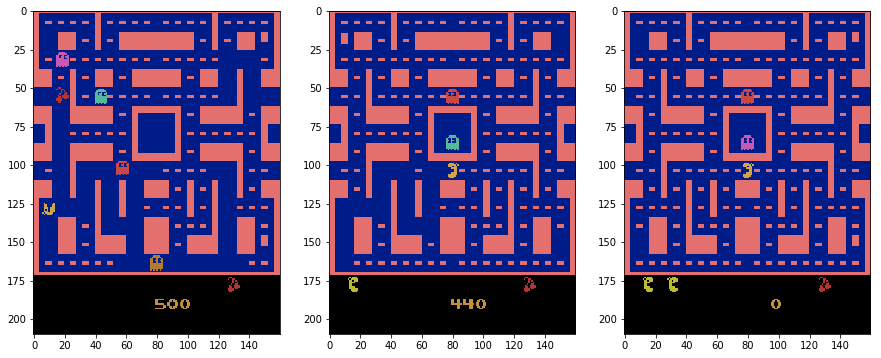

epoch 4310,loss 1799.87065, epsilon 0.05605, rewards: ( e-greedy 77.96160, greedy 66.51741) 
rec 1795.551 reg 4.319
epoch 4320,loss 486.45265, epsilon 0.05598, rewards: ( e-greedy 76.22794, greedy 70.61567) 
rec 482.127 reg 4.326
epoch 4330,loss 714.62224, epsilon 0.05593, rewards: ( e-greedy 79.04265, greedy 74.67910) 
rec 710.291 reg 4.332
epoch 4340,loss 255.79248, epsilon 0.05587, rewards: ( e-greedy 75.88838, greedy 71.08619) 
rec 251.463 reg 4.330
epoch 4350,loss 773.69618, epsilon 0.05581, rewards: ( e-greedy 76.61204, greedy 76.91507) 
rec 769.362 reg 4.334
epoch 4360,loss 586.62074, epsilon 0.05575, rewards: ( e-greedy 78.70084, greedy 72.72357) 
rec 582.290 reg 4.331
epoch 4370,loss 689.60899, epsilon 0.05569, rewards: ( e-greedy 78.20575, greedy 71.76371) 
rec 685.290 reg 4.319
epoch 4380,loss 203.53342, epsilon 0.05564, rewards: ( e-greedy 74.63518, greedy 68.71234) 
rec 199.216 reg 4.317
epoch 4390,loss 275.16920, epsilon 0.05558, rewards: ( e-greedy 71.92166, greedy 69.40

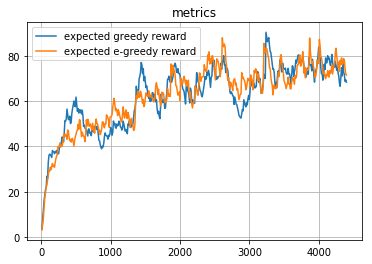

Random session examples


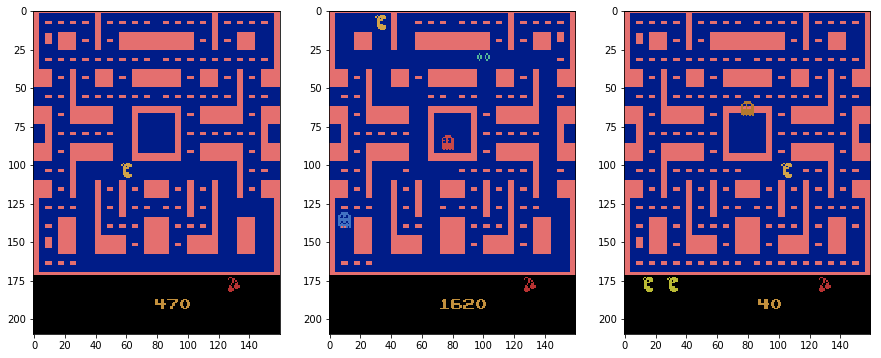

epoch 4410,loss 1031.99053, epsilon 0.05547, rewards: ( e-greedy 75.01905, greedy 76.00442) 
rec 1027.671 reg 4.320
epoch 4420,loss 1208.28706, epsilon 0.05542, rewards: ( e-greedy 76.26714, greedy 74.52898) 
rec 1203.968 reg 4.320
epoch 4430,loss 517.01748, epsilon 0.05536, rewards: ( e-greedy 76.51543, greedy 78.70108) 
rec 512.698 reg 4.319
epoch 4440,loss 339.68504, epsilon 0.05531, rewards: ( e-greedy 77.55138, greedy 82.01847) 
rec 335.366 reg 4.319
epoch 4450,loss 312.42910, epsilon 0.05526, rewards: ( e-greedy 74.35875, greedy 78.94162) 
rec 308.109 reg 4.321
epoch 4460,loss 281.94499, epsilon 0.05520, rewards: ( e-greedy 72.54787, greedy 84.35996) 
rec 277.622 reg 4.323
epoch 4470,loss 1115.50591, epsilon 0.05515, rewards: ( e-greedy 72.41808, greedy 81.61147) 
rec 1111.180 reg 4.326
epoch 4480,loss 368.29282, epsilon 0.05510, rewards: ( e-greedy 72.36378, greedy 83.70032) 
rec 363.975 reg 4.318
epoch 4490,loss 268.50452, epsilon 0.05505, rewards: ( e-greedy 69.93990, greedy 8

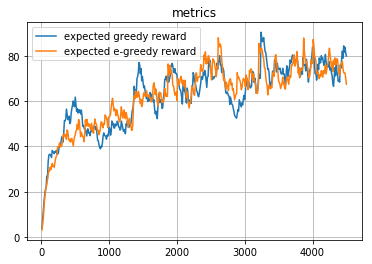

Random session examples


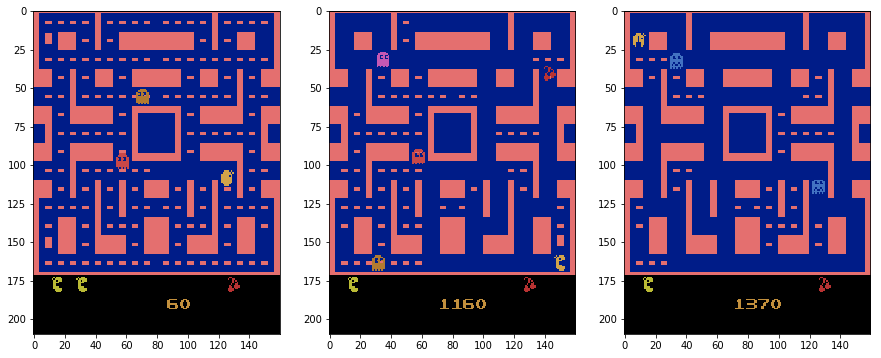

epoch 4510,loss 968.36975, epsilon 0.05495, rewards: ( e-greedy 72.95132, greedy 76.98191) 
rec 964.076 reg 4.294
epoch 4520,loss 521.25814, epsilon 0.05490, rewards: ( e-greedy 71.09369, greedy 77.59622) 
rec 516.972 reg 4.286
epoch 4530,loss 342.10345, epsilon 0.05485, rewards: ( e-greedy 70.60932, greedy 76.64910) 
rec 337.815 reg 4.289
epoch 4540,loss 431.17462, epsilon 0.05480, rewards: ( e-greedy 70.54839, greedy 76.73419) 
rec 426.873 reg 4.302
epoch 4550,loss 217.68684, epsilon 0.05476, rewards: ( e-greedy 67.18105, greedy 74.43577) 
rec 213.366 reg 4.321
epoch 4560,loss 233.41123, epsilon 0.05471, rewards: ( e-greedy 62.21294, greedy 72.49219) 
rec 229.075 reg 4.336
epoch 4570,loss 376.76089, epsilon 0.05466, rewards: ( e-greedy 64.42915, greedy 79.43047) 
rec 372.406 reg 4.355
epoch 4580,loss 972.41898, epsilon 0.05461, rewards: ( e-greedy 64.54873, greedy 74.29992) 
rec 968.050 reg 4.369
epoch 4590,loss 944.47512, epsilon 0.05457, rewards: ( e-greedy 66.90636, greedy 78.3699

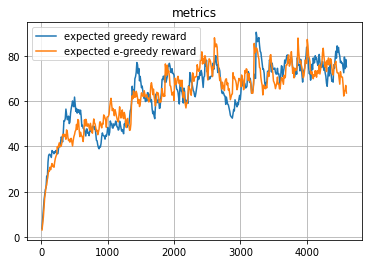

Random session examples


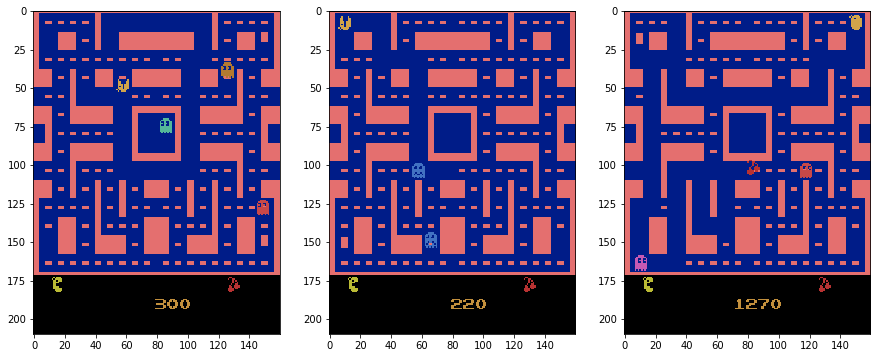

epoch 4610,loss 191.04102, epsilon 0.05448, rewards: ( e-greedy 61.92540, greedy 71.46089) 
rec 186.632 reg 4.409
epoch 4620,loss 413.98974, epsilon 0.05443, rewards: ( e-greedy 63.67036, greedy 80.62731) 
rec 409.570 reg 4.420
epoch 4630,loss 618.40591, epsilon 0.05439, rewards: ( e-greedy 63.61583, greedy 78.87707) 
rec 613.983 reg 4.423
epoch 4640,loss 230.25987, epsilon 0.05435, rewards: ( e-greedy 60.50424, greedy 78.73937) 
rec 225.843 reg 4.417
epoch 4650,loss 299.67189, epsilon 0.05430, rewards: ( e-greedy 59.39132, greedy 80.30293) 
rec 295.259 reg 4.413
epoch 4660,loss 450.21198, epsilon 0.05426, rewards: ( e-greedy 60.51469, greedy 80.46014) 
rec 445.799 reg 4.413
epoch 4670,loss 1673.54134, epsilon 0.05422, rewards: ( e-greedy 63.77572, greedy 85.35162) 
rec 1669.134 reg 4.407
epoch 4680,loss 282.30193, epsilon 0.05418, rewards: ( e-greedy 63.02315, greedy 83.12896) 
rec 277.900 reg 4.402
epoch 4690,loss 278.79716, epsilon 0.05413, rewards: ( e-greedy 61.53333, greedy 79.94

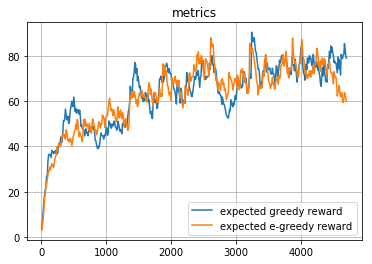

Random session examples


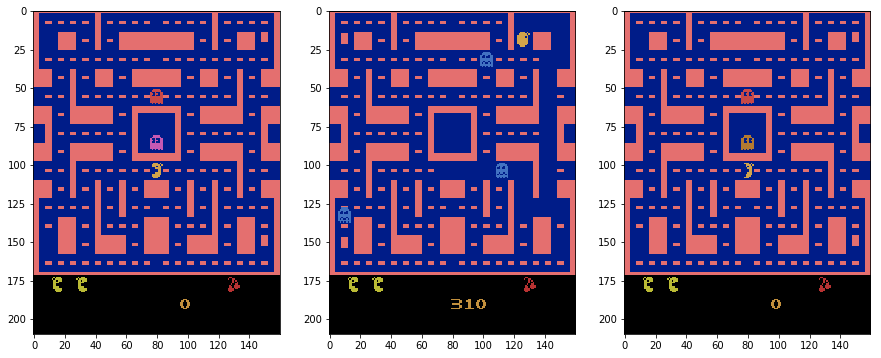

epoch 4710,loss 471.27948, epsilon 0.05405, rewards: ( e-greedy 62.69825, greedy 81.93351) 
rec 466.888 reg 4.391
epoch 4720,loss 509.65481, epsilon 0.05401, rewards: ( e-greedy 65.05342, greedy 79.36516) 
rec 505.263 reg 4.392
epoch 4730,loss 284.15390, epsilon 0.05397, rewards: ( e-greedy 62.11058, greedy 78.49115) 
rec 279.762 reg 4.391
epoch 4740,loss 1046.81200, epsilon 0.05393, rewards: ( e-greedy 64.39952, greedy 76.32953) 
rec 1042.406 reg 4.406
epoch 4750,loss 512.30367, epsilon 0.05389, rewards: ( e-greedy 65.77207, greedy 80.63408) 
rec 507.883 reg 4.420
epoch 4760,loss 304.88450, epsilon 0.05385, rewards: ( e-greedy 61.19486, greedy 75.94567) 
rec 300.415 reg 4.469
epoch 4770,loss 518.54871, epsilon 0.05382, rewards: ( e-greedy 62.01288, greedy 78.78860) 
rec 514.034 reg 4.514
epoch 4780,loss 571.81203, epsilon 0.05378, rewards: ( e-greedy 64.18659, greedy 76.53474) 
rec 567.272 reg 4.540
epoch 5030,loss 5212.61148, epsilon 0.05294, rewards: ( e-greedy 69.64861, greedy 75.9

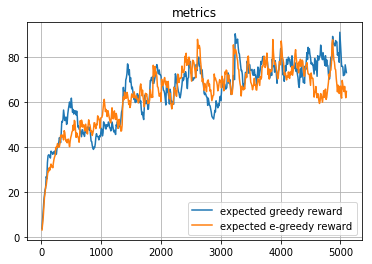

Random session examples


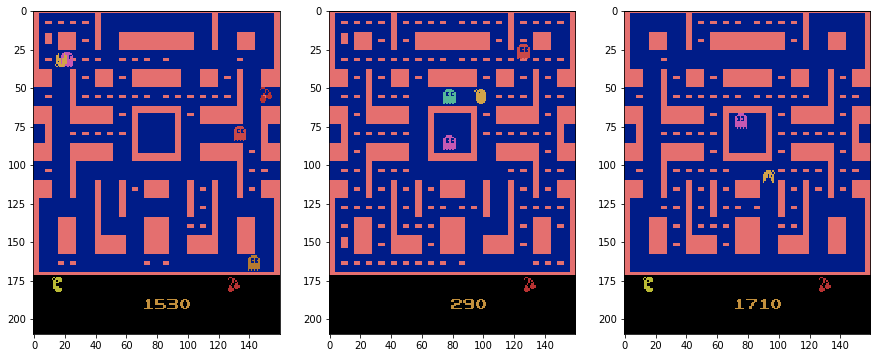

epoch 5110,loss 582.61299, epsilon 0.05272, rewards: ( e-greedy 66.21000, greedy 79.49686) 
rec 577.824 reg 4.789
epoch 5120,loss 3967.22321, epsilon 0.05269, rewards: ( e-greedy 79.15150, greedy 79.17217) 
rec 3962.432 reg 4.791
epoch 5130,loss 791.47204, epsilon 0.05266, rewards: ( e-greedy 76.11135, greedy 73.56745) 
rec 786.649 reg 4.823
epoch 5140,loss 1846.06869, epsilon 0.05264, rewards: ( e-greedy 76.37522, greedy 71.64821) 
rec 1841.224 reg 4.845
epoch 5150,loss 657.36700, epsilon 0.05261, rewards: ( e-greedy 75.55020, greedy 68.98339) 
rec 652.486 reg 4.881
epoch 5160,loss 558.60818, epsilon 0.05258, rewards: ( e-greedy 75.43268, greedy 68.08505) 
rec 553.671 reg 4.938
epoch 5170,loss 293.49093, epsilon 0.05256, rewards: ( e-greedy 72.82691, greedy 67.40154) 
rec 288.501 reg 4.990
epoch 5180,loss 539.09724, epsilon 0.05253, rewards: ( e-greedy 72.91922, greedy 66.53639) 
rec 534.067 reg 5.030
epoch 5190,loss 569.82559, epsilon 0.05251, rewards: ( e-greedy 73.00230, greedy 68.

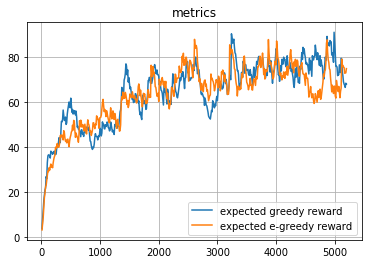

Random session examples


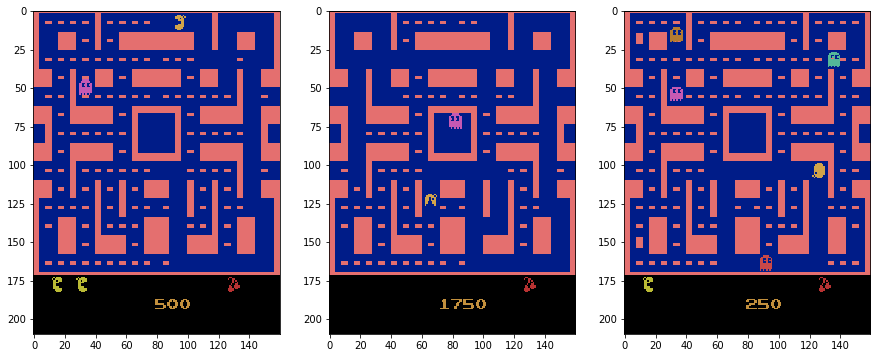

epoch 5210,loss 221.36659, epsilon 0.05246, rewards: ( e-greedy 71.65061, greedy 70.05253) 
rec 216.290 reg 5.077
epoch 5220,loss 7880.97653, epsilon 0.05243, rewards: ( e-greedy 80.86055, greedy 67.92228) 
rec 7875.904 reg 5.073
epoch 5230,loss 2961.31843, epsilon 0.05241, rewards: ( e-greedy 85.96199, greedy 68.88005) 
rec 2956.239 reg 5.080
epoch 5240,loss 386.09519, epsilon 0.05239, rewards: ( e-greedy 82.36579, greedy 72.67954) 
rec 381.013 reg 5.082
epoch 5250,loss 223.42646, epsilon 0.05236, rewards: ( e-greedy 79.37921, greedy 70.59909) 
rec 218.351 reg 5.076
epoch 5260,loss 1098.41419, epsilon 0.05234, rewards: ( e-greedy 79.25379, greedy 67.97668) 
rec 1093.347 reg 5.068
epoch 5270,loss 629.96770, epsilon 0.05231, rewards: ( e-greedy 79.01591, greedy 74.17901) 
rec 624.910 reg 5.058
epoch 5280,loss 288.58464, epsilon 0.05229, rewards: ( e-greedy 74.30182, greedy 72.88611) 
rec 283.538 reg 5.047
epoch 5290,loss 207.00647, epsilon 0.05227, rewards: ( e-greedy 70.80914, greedy 7

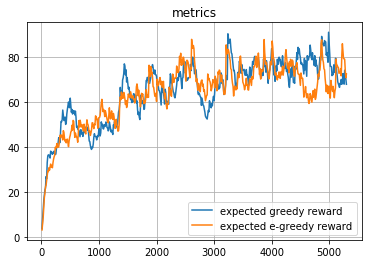

Random session examples


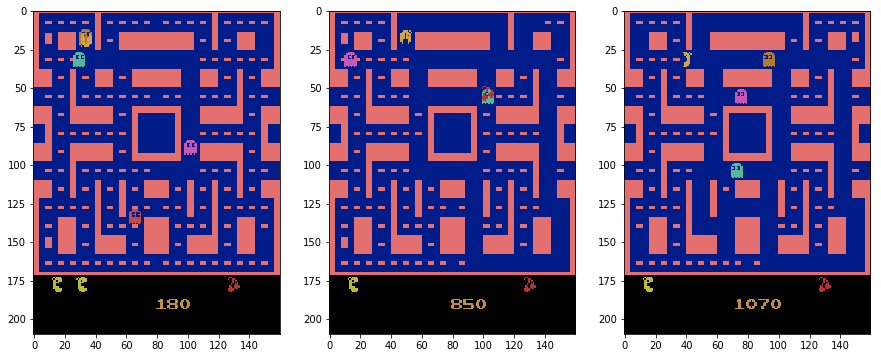

epoch 5310,loss 1379.03289, epsilon 0.05222, rewards: ( e-greedy 74.85540, greedy 69.68960) 
rec 1373.999 reg 5.033
epoch 5320,loss 1158.67188, epsilon 0.05220, rewards: ( e-greedy 76.11986, greedy 76.65814) 
rec 1153.632 reg 5.040
epoch 5330,loss 594.31754, epsilon 0.05218, rewards: ( e-greedy 77.69538, greedy 81.80483) 
rec 589.264 reg 5.053
epoch 5340,loss 881.80739, epsilon 0.05216, rewards: ( e-greedy 79.92584, greedy 82.18684) 
rec 876.743 reg 5.065
epoch 5350,loss 1616.13374, epsilon 0.05214, rewards: ( e-greedy 80.30826, greedy 80.59316) 
rec 1611.065 reg 5.069
epoch 5360,loss 1035.15536, epsilon 0.05212, rewards: ( e-greedy 83.02743, greedy 83.15884) 
rec 1030.089 reg 5.066
epoch 5370,loss 538.95547, epsilon 0.05209, rewards: ( e-greedy 82.16219, greedy 82.46796) 
rec 533.896 reg 5.059
epoch 5380,loss 319.31331, epsilon 0.05207, rewards: ( e-greedy 79.75847, greedy 80.40866) 
rec 314.255 reg 5.058
epoch 5390,loss 1016.34499, epsilon 0.05205, rewards: ( e-greedy 81.34512, greed

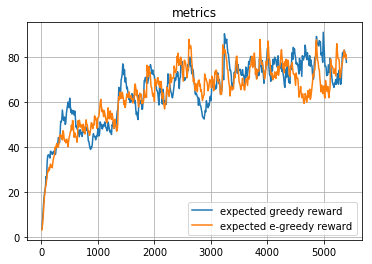

Random session examples


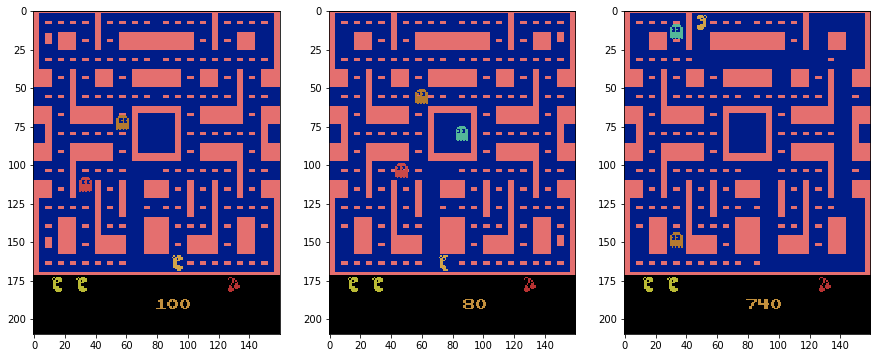

epoch 5410,loss 331.53526, epsilon 0.05201, rewards: ( e-greedy 74.02705, greedy 77.93542) 
rec 326.423 reg 5.113
epoch 5420,loss 1660.38573, epsilon 0.05199, rewards: ( e-greedy 80.37434, greedy 82.20437) 
rec 1655.257 reg 5.129
epoch 5430,loss 430.65075, epsilon 0.05197, rewards: ( e-greedy 78.08691, greedy 79.54644) 
rec 425.476 reg 5.175
epoch 5440,loss 430.63618, epsilon 0.05195, rewards: ( e-greedy 74.21572, greedy 86.46679) 
rec 425.425 reg 5.211
epoch 5450,loss 1283.39245, epsilon 0.05193, rewards: ( e-greedy 79.35665, greedy 90.94511) 
rec 1278.165 reg 5.227
epoch 5460,loss 879.25077, epsilon 0.05191, rewards: ( e-greedy 81.98348, greedy 93.60060) 
rec 874.024 reg 5.227
epoch 5470,loss 290.44816, epsilon 0.05190, rewards: ( e-greedy 81.16013, greedy 98.05304) 
rec 285.211 reg 5.238
epoch 5480,loss 255.34235, epsilon 0.05188, rewards: ( e-greedy 77.41912, greedy 93.62274) 
rec 250.101 reg 5.241
epoch 5490,loss 469.60931, epsilon 0.05186, rewards: ( e-greedy 75.80221, greedy 89.

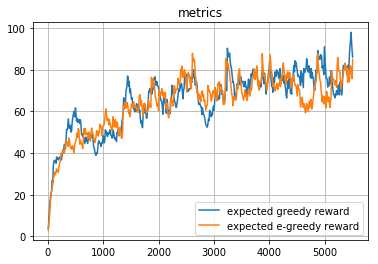

Random session examples


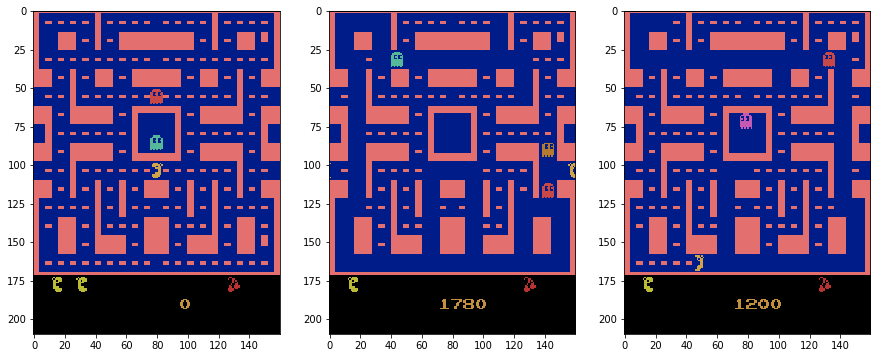

epoch 5510,loss 488.45277, epsilon 0.05182, rewards: ( e-greedy 82.28729, greedy 85.34473) 
rec 483.222 reg 5.230
epoch 5520,loss 1638.72138, epsilon 0.05180, rewards: ( e-greedy 85.93356, greedy 82.99775) 
rec 1633.499 reg 5.222
epoch 5530,loss 741.26253, epsilon 0.05178, rewards: ( e-greedy 87.15270, greedy 83.63548) 
rec 736.048 reg 5.215
epoch 5540,loss 1361.36141, epsilon 0.05177, rewards: ( e-greedy 86.12493, greedy 78.52193) 
rec 1356.158 reg 5.203
epoch 5550,loss 651.94279, epsilon 0.05175, rewards: ( e-greedy 88.94994, greedy 82.23224) 
rec 646.753 reg 5.190
epoch 5560,loss 230.32290, epsilon 0.05173, rewards: ( e-greedy 84.30495, greedy 79.32151) 
rec 225.142 reg 5.181
epoch 5570,loss 668.56660, epsilon 0.05171, rewards: ( e-greedy 84.12445, greedy 80.38936) 
rec 663.392 reg 5.175
epoch 5580,loss 1235.21453, epsilon 0.05170, rewards: ( e-greedy 86.77451, greedy 80.16293) 
rec 1230.044 reg 5.171
epoch 5590,loss 647.73253, epsilon 0.05168, rewards: ( e-greedy 85.15956, greedy 8

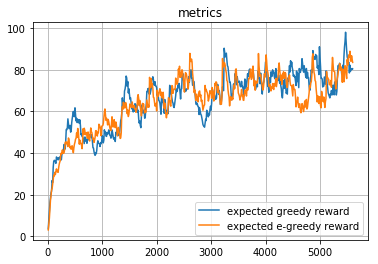

Random session examples


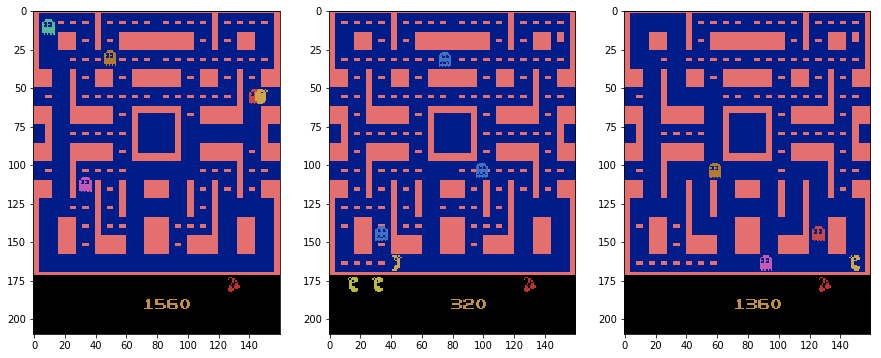

epoch 5610,loss 375.97201, epsilon 0.05165, rewards: ( e-greedy 82.47299, greedy 81.47377) 
rec 370.802 reg 5.170
epoch 5620,loss 385.77349, epsilon 0.05163, rewards: ( e-greedy 82.16319, greedy 83.95140) 
rec 380.611 reg 5.162
epoch 5630,loss 543.11635, epsilon 0.05161, rewards: ( e-greedy 81.13437, greedy 83.86876) 
rec 537.966 reg 5.151
epoch 5640,loss 733.18647, epsilon 0.05160, rewards: ( e-greedy 79.20843, greedy 88.16938) 
rec 728.047 reg 5.139
epoch 5650,loss 1489.37489, epsilon 0.05158, rewards: ( e-greedy 79.72509, greedy 86.41494) 
rec 1484.242 reg 5.132
epoch 5660,loss 245.56138, epsilon 0.05157, rewards: ( e-greedy 75.87758, greedy 82.27345) 
rec 240.431 reg 5.130
epoch 5670,loss 281.62140, epsilon 0.05155, rewards: ( e-greedy 74.10232, greedy 86.29610) 
rec 276.501 reg 5.120
epoch 5680,loss 192.25137, epsilon 0.05154, rewards: ( e-greedy 70.44209, greedy 84.85399) 
rec 187.140 reg 5.111
epoch 5690,loss 615.21070, epsilon 0.05152, rewards: ( e-greedy 70.77288, greedy 86.11

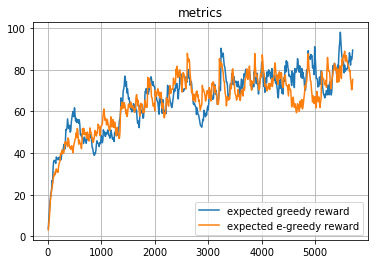

Random session examples


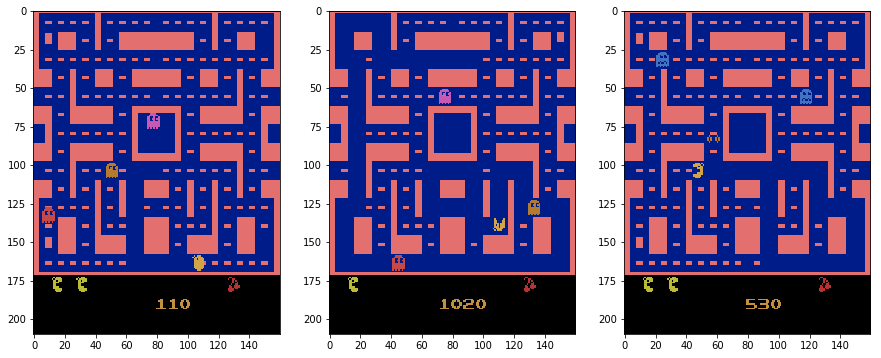

epoch 5710,loss 1688.56423, epsilon 0.05149, rewards: ( e-greedy 81.84478, greedy 87.93106) 
rec 1683.482 reg 5.082
epoch 5720,loss 5427.57704, epsilon 0.05148, rewards: ( e-greedy 88.22281, greedy 87.63795) 
rec 5422.500 reg 5.077
epoch 5730,loss 291.57401, epsilon 0.05146, rewards: ( e-greedy 82.90053, greedy 82.43666) 
rec 286.494 reg 5.080
epoch 5740,loss 501.09601, epsilon 0.05145, rewards: ( e-greedy 81.67297, greedy 84.13049) 
rec 496.015 reg 5.081
epoch 5750,loss 227.13872, epsilon 0.05143, rewards: ( e-greedy 76.94318, greedy 84.09244) 
rec 222.049 reg 5.090
epoch 5760,loss 7594.33170, epsilon 0.05142, rewards: ( e-greedy 86.62386, greedy 93.80820) 
rec 7589.241 reg 5.090
epoch 5770,loss 338.12740, epsilon 0.05140, rewards: ( e-greedy 80.89897, greedy 86.86488) 
rec 333.026 reg 5.101
epoch 5780,loss 368.86411, epsilon 0.05139, rewards: ( e-greedy 78.30908, greedy 86.36589) 
rec 363.751 reg 5.113
epoch 5790,loss 594.77757, epsilon 0.05138, rewards: ( e-greedy 79.72817, greedy 9

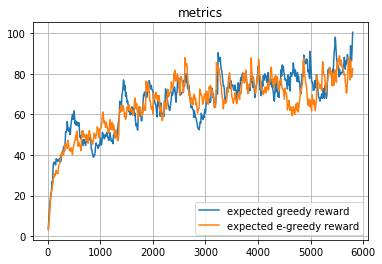

Random session examples


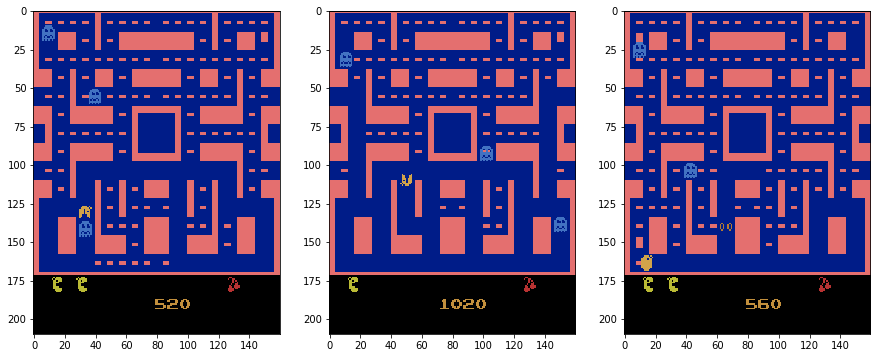

epoch 5810,loss 447.28812, epsilon 0.05135, rewards: ( e-greedy 78.06732, greedy 92.91074) 
rec 442.165 reg 5.123
epoch 5820,loss 1729.38268, epsilon 0.05134, rewards: ( e-greedy 78.63558, greedy 91.68216) 
rec 1724.263 reg 5.120
epoch 5830,loss 206.53614, epsilon 0.05132, rewards: ( e-greedy 75.52203, greedy 90.13895) 
rec 201.425 reg 5.111
epoch 5840,loss 563.83932, epsilon 0.05131, rewards: ( e-greedy 76.53232, greedy 88.06255) 
rec 558.738 reg 5.101
epoch 5850,loss 330.82192, epsilon 0.05130, rewards: ( e-greedy 76.62909, greedy 91.69380) 
rec 325.735 reg 5.087
epoch 5860,loss 627.39122, epsilon 0.05128, rewards: ( e-greedy 76.27868, greedy 89.27442) 
rec 622.316 reg 5.075
epoch 5870,loss 943.83584, epsilon 0.05127, rewards: ( e-greedy 78.40081, greedy 91.72197) 
rec 938.766 reg 5.070
epoch 5880,loss 609.70799, epsilon 0.05126, rewards: ( e-greedy 78.37323, greedy 87.48728) 
rec 604.639 reg 5.069
epoch 5890,loss 373.15680, epsilon 0.05125, rewards: ( e-greedy 78.78591, greedy 88.73

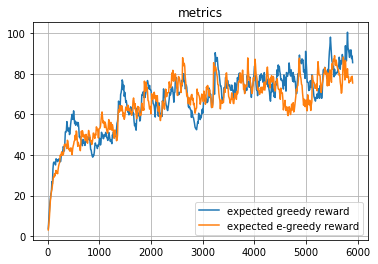

Random session examples


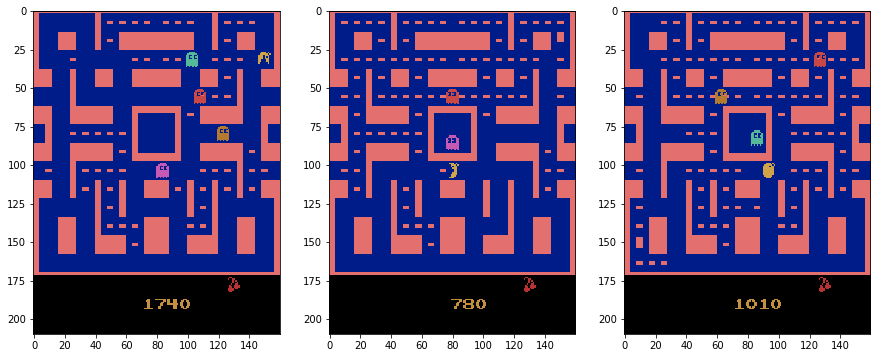

epoch 5910,loss 704.87276, epsilon 0.05122, rewards: ( e-greedy 78.17284, greedy 86.69073) 
rec 699.807 reg 5.066
epoch 5920,loss 563.19277, epsilon 0.05121, rewards: ( e-greedy 80.48055, greedy 89.77165) 
rec 558.121 reg 5.072
epoch 5930,loss 541.20609, epsilon 0.05120, rewards: ( e-greedy 79.74500, greedy 90.54449) 
rec 536.127 reg 5.079
epoch 5940,loss 385.21889, epsilon 0.05118, rewards: ( e-greedy 75.52050, greedy 85.80254) 
rec 380.128 reg 5.091
epoch 5950,loss 271.90111, epsilon 0.05117, rewards: ( e-greedy 72.34345, greedy 84.65978) 
rec 266.804 reg 5.097
epoch 5960,loss 748.55571, epsilon 0.05116, rewards: ( e-greedy 75.98410, greedy 88.88131) 
rec 743.461 reg 5.095
epoch 5970,loss 213.26124, epsilon 0.05115, rewards: ( e-greedy 72.69819, greedy 89.80568) 
rec 208.172 reg 5.089
epoch 5980,loss 562.00756, epsilon 0.05114, rewards: ( e-greedy 71.86587, greedy 91.07511) 
rec 556.920 reg 5.088
epoch 5990,loss 2887.28060, epsilon 0.05113, rewards: ( e-greedy 82.99179, greedy 105.40

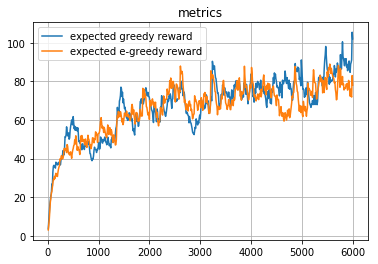

Random session examples


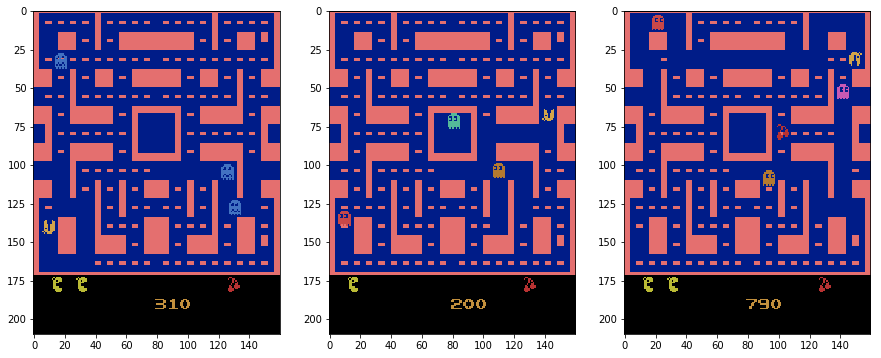

[2017-05-24 04:01:16,015] Making new env: MsPacman-v0
[2017-05-24 04:01:16,189] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 04:01:16,199] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.5.6682.video000000.mp4
[2017-05-24 04:01:17,930] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.5.6682.video000001.mp4


Episode finished after 740 timesteps, rw = 300.0
Episode finished after 501 timesteps, rw = 220.0
Episode finished after 582 timesteps, rw = 370.0
Episode finished after 1155 timesteps, rw = 520.0
Episode finished after 747 timesteps, rw = 320.0
Episode finished after 799 timesteps, rw = 340.0
Episode finished after 578 timesteps, rw = 450.0


[2017-05-24 04:01:26,320] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.5.6682.video000008.mp4


Episode finished after 579 timesteps, rw = 330.0
Episode finished after 636 timesteps, rw = 210.0
Episode finished after 581 timesteps, rw = 320.0
Episode finished after 578 timesteps, rw = 320.0
Episode finished after 734 timesteps, rw = 360.0
Episode finished after 694 timesteps, rw = 360.0
Episode finished after 550 timesteps, rw = 210.0
Episode finished after 564 timesteps, rw = 240.0
Episode finished after 570 timesteps, rw = 240.0
Episode finished after 913 timesteps, rw = 690.0
Episode finished after 646 timesteps, rw = 870.0
Episode finished after 834 timesteps, rw = 410.0


[2017-05-24 04:01:39,452] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 626 timesteps, rw = 530.0
Mean 380.5, Var 26444.75
epoch 6010,loss 1372.11435, epsilon 0.05110, rewards: ( e-greedy 83.64210, greedy 106.72813) 
rec 1367.046 reg 5.068
epoch 6020,loss 244.49188, epsilon 0.05109, rewards: ( e-greedy 82.09039, greedy 105.43032) 
rec 239.432 reg 5.060
epoch 6030,loss 5513.01172, epsilon 0.05108, rewards: ( e-greedy 90.69385, greedy 116.01228) 
rec 5507.955 reg 5.057
epoch 6040,loss 275.80117, epsilon 0.05107, rewards: ( e-greedy 87.24946, greedy 111.59856) 
rec 270.742 reg 5.059
epoch 6050,loss 817.44726, epsilon 0.05106, rewards: ( e-greedy 88.27452, greedy 111.43870) 
rec 812.385 reg 5.063
epoch 6060,loss 326.97433, epsilon 0.05105, rewards: ( e-greedy 84.25957, greedy 105.04483) 
rec 321.904 reg 5.070
epoch 6070,loss 830.01218, epsilon 0.05104, rewards: ( e-greedy 83.14611, greedy 99.54035) 
rec 824.934 reg 5.078
epoch 6080,loss 324.60703, epsilon 0.05103, rewards: ( e-greedy 78.08150, greedy 94.27381) 
rec 319.516 reg 5.091
epoc

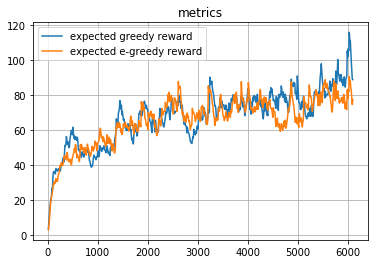

Random session examples


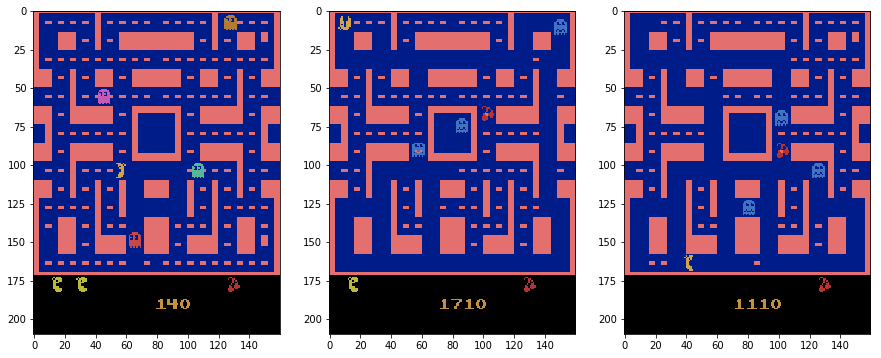

epoch 6110,loss 246.49054, epsilon 0.05100, rewards: ( e-greedy 73.53516, greedy 87.22498) 
rec 241.355 reg 5.136
epoch 6120,loss 778.88572, epsilon 0.05099, rewards: ( e-greedy 74.61915, greedy 88.37749) 
rec 773.714 reg 5.171
epoch 6130,loss 298.92877, epsilon 0.05098, rewards: ( e-greedy 73.84473, greedy 85.47724) 
rec 293.737 reg 5.192
epoch 6140,loss 1888.72519, epsilon 0.05097, rewards: ( e-greedy 74.64776, greedy 93.36701) 
rec 1883.526 reg 5.199
epoch 6150,loss 331.61875, epsilon 0.05096, rewards: ( e-greedy 73.43298, greedy 95.46781) 
rec 326.411 reg 5.208
epoch 6160,loss 213.70860, epsilon 0.05095, rewards: ( e-greedy 69.65218, greedy 94.10853) 
rec 208.502 reg 5.207
epoch 6170,loss 439.73174, epsilon 0.05094, rewards: ( e-greedy 69.31197, greedy 91.13518) 
rec 434.531 reg 5.201
epoch 6180,loss 1352.04374, epsilon 0.05093, rewards: ( e-greedy 74.38077, greedy 87.02166) 
rec 1346.852 reg 5.192
epoch 6190,loss 1705.29420, epsilon 0.05092, rewards: ( e-greedy 74.31769, greedy 83

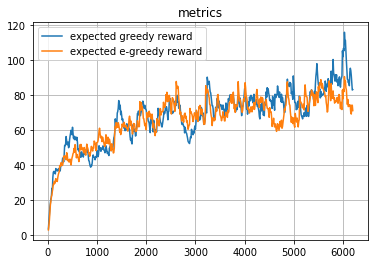

Random session examples


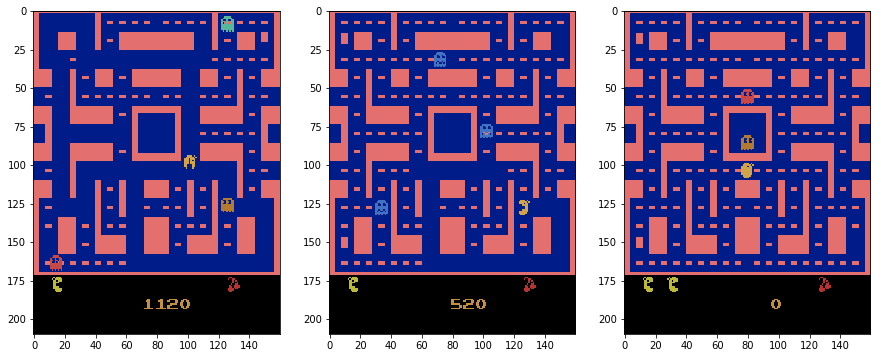

epoch 6210,loss 349.01207, epsilon 0.05090, rewards: ( e-greedy 72.94733, greedy 86.69192) 
rec 343.807 reg 5.205
epoch 6220,loss 284.89490, epsilon 0.05090, rewards: ( e-greedy 70.90260, greedy 85.21022) 
rec 279.689 reg 5.206
epoch 6230,loss 663.33881, epsilon 0.05089, rewards: ( e-greedy 72.12484, greedy 88.18920) 
rec 658.135 reg 5.203
epoch 6240,loss 615.91736, epsilon 0.05088, rewards: ( e-greedy 72.22485, greedy 88.93278) 
rec 610.715 reg 5.203
epoch 6250,loss 216.74208, epsilon 0.05087, rewards: ( e-greedy 71.87737, greedy 83.97700) 
rec 211.540 reg 5.202
epoch 6260,loss 490.94590, epsilon 0.05086, rewards: ( e-greedy 74.25213, greedy 85.70430) 
rec 485.748 reg 5.198
epoch 6270,loss 360.69972, epsilon 0.05085, rewards: ( e-greedy 74.38942, greedy 88.57137) 
rec 355.498 reg 5.202
epoch 6280,loss 462.15051, epsilon 0.05084, rewards: ( e-greedy 73.70048, greedy 85.08924) 
rec 456.939 reg 5.211
epoch 6290,loss 2039.94261, epsilon 0.05083, rewards: ( e-greedy 76.64293, greedy 88.455

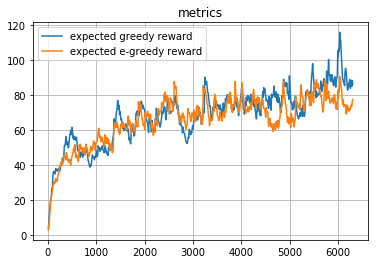

Random session examples


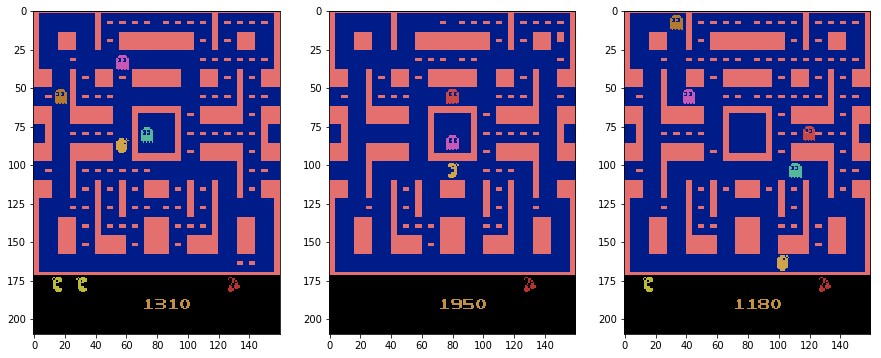

epoch 6310,loss 357.52275, epsilon 0.05082, rewards: ( e-greedy 75.84327, greedy 84.09255) 
rec 352.321 reg 5.202
epoch 6320,loss 645.39005, epsilon 0.05081, rewards: ( e-greedy 78.57145, greedy 81.24580) 
rec 640.180 reg 5.210
epoch 6330,loss 246.07662, epsilon 0.05080, rewards: ( e-greedy 73.33930, greedy 77.12122) 
rec 240.862 reg 5.215
epoch 6340,loss 1408.99146, epsilon 0.05079, rewards: ( e-greedy 76.75537, greedy 75.72160) 
rec 1403.776 reg 5.215
epoch 6350,loss 1268.85738, epsilon 0.05079, rewards: ( e-greedy 79.45483, greedy 76.64944) 
rec 1263.637 reg 5.220
epoch 6360,loss 2367.57379, epsilon 0.05078, rewards: ( e-greedy 86.69685, greedy 82.98449) 
rec 2362.330 reg 5.244
epoch 6370,loss 2183.39655, epsilon 0.05077, rewards: ( e-greedy 88.58967, greedy 83.56104) 
rec 2178.131 reg 5.266
epoch 6380,loss 345.60358, epsilon 0.05076, rewards: ( e-greedy 83.85570, greedy 83.07994) 
rec 340.329 reg 5.274
epoch 6390,loss 404.28233, epsilon 0.05076, rewards: ( e-greedy 82.65763, greedy

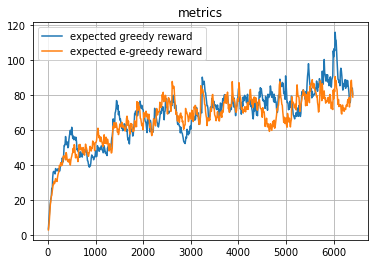

Random session examples


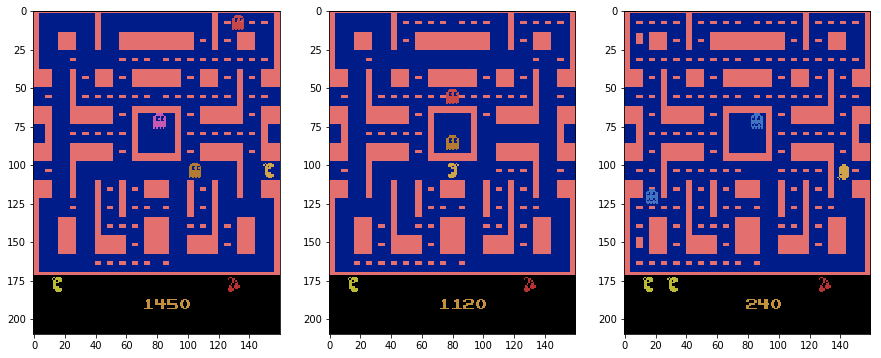

epoch 6410,loss 513.42209, epsilon 0.05074, rewards: ( e-greedy 76.99018, greedy 80.97778) 
rec 508.158 reg 5.264
epoch 6420,loss 258.83381, epsilon 0.05073, rewards: ( e-greedy 75.04116, greedy 79.63000) 
rec 253.580 reg 5.254
epoch 6430,loss 1695.13877, epsilon 0.05073, rewards: ( e-greedy 79.09955, greedy 79.16700) 
rec 1689.895 reg 5.244
epoch 6440,loss 3971.29278, epsilon 0.05072, rewards: ( e-greedy 84.50209, greedy 77.12530) 
rec 3966.055 reg 5.238
epoch 6450,loss 451.94921, epsilon 0.05071, rewards: ( e-greedy 84.92688, greedy 74.22527) 
rec 446.714 reg 5.235
epoch 6460,loss 825.68738, epsilon 0.05070, rewards: ( e-greedy 82.49669, greedy 74.17774) 
rec 820.457 reg 5.231
epoch 6470,loss 826.07318, epsilon 0.05070, rewards: ( e-greedy 83.68452, greedy 76.25997) 
rec 820.829 reg 5.245
epoch 6480,loss 286.42211, epsilon 0.05069, rewards: ( e-greedy 82.56607, greedy 81.13397) 
rec 281.164 reg 5.258
epoch 6490,loss 1111.00404, epsilon 0.05068, rewards: ( e-greedy 83.99696, greedy 81

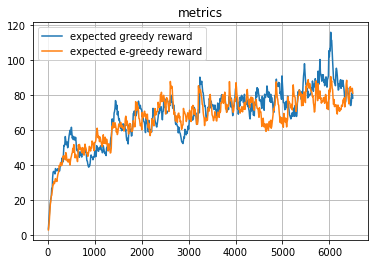

Random session examples


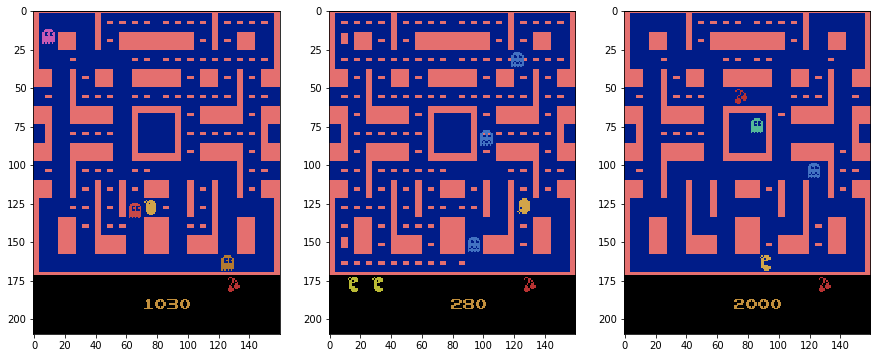

epoch 6510,loss 340.28208, epsilon 0.05067, rewards: ( e-greedy 78.03754, greedy 78.96854) 
rec 335.032 reg 5.250
epoch 6520,loss 492.05797, epsilon 0.05066, rewards: ( e-greedy 78.17129, greedy 77.44669) 
rec 486.809 reg 5.249
epoch 6530,loss 261.84053, epsilon 0.05066, rewards: ( e-greedy 74.10416, greedy 73.38952) 
rec 256.599 reg 5.242
epoch 6540,loss 1150.28567, epsilon 0.05065, rewards: ( e-greedy 77.94374, greedy 74.73807) 
rec 1145.041 reg 5.245
epoch 6550,loss 280.36160, epsilon 0.05064, rewards: ( e-greedy 75.52437, greedy 75.82676) 
rec 275.107 reg 5.255
epoch 6560,loss 765.01385, epsilon 0.05064, rewards: ( e-greedy 78.40943, greedy 74.36908) 
rec 759.745 reg 5.269
epoch 6570,loss 787.89833, epsilon 0.05063, rewards: ( e-greedy 78.56849, greedy 74.43217) 
rec 782.625 reg 5.273
epoch 6580,loss 720.28173, epsilon 0.05062, rewards: ( e-greedy 77.21164, greedy 72.86396) 
rec 715.012 reg 5.269
epoch 6590,loss 301.91723, epsilon 0.05062, rewards: ( e-greedy 75.55298, greedy 72.70

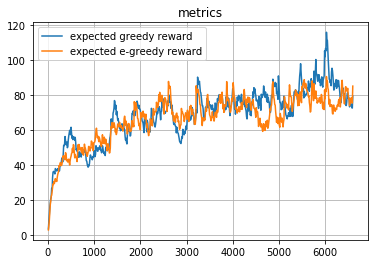

Random session examples


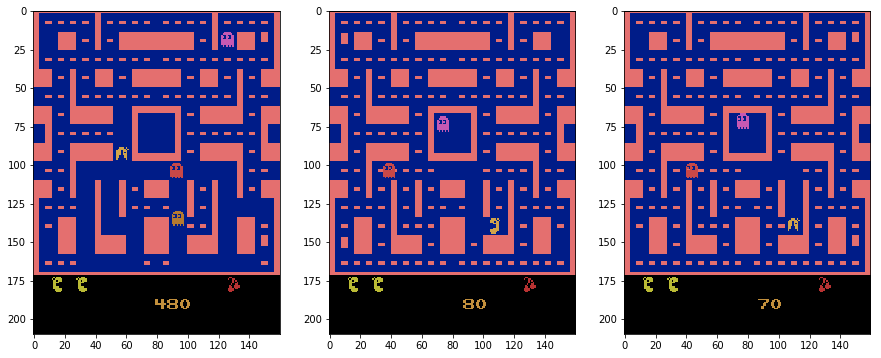

epoch 6610,loss 1825.31718, epsilon 0.05061, rewards: ( e-greedy 83.91041, greedy 75.16407) 
rec 1820.054 reg 5.263
epoch 6620,loss 477.42546, epsilon 0.05060, rewards: ( e-greedy 81.83187, greedy 84.46017) 
rec 472.144 reg 5.281
epoch 6630,loss 566.10213, epsilon 0.05059, rewards: ( e-greedy 80.96118, greedy 81.20165) 
rec 560.806 reg 5.296
epoch 6640,loss 875.47449, epsilon 0.05059, rewards: ( e-greedy 79.30256, greedy 78.08149) 
rec 870.173 reg 5.301
epoch 6650,loss 348.79370, epsilon 0.05058, rewards: ( e-greedy 76.30981, greedy 78.83584) 
rec 343.489 reg 5.305
epoch 6660,loss 294.97180, epsilon 0.05058, rewards: ( e-greedy 71.05383, greedy 76.88975) 
rec 289.655 reg 5.317
epoch 6670,loss 296.42865, epsilon 0.05057, rewards: ( e-greedy 71.51094, greedy 77.26328) 
rec 291.105 reg 5.324
epoch 6680,loss 757.81064, epsilon 0.05057, rewards: ( e-greedy 71.92235, greedy 76.28695) 
rec 752.485 reg 5.326
epoch 6690,loss 428.93796, epsilon 0.05056, rewards: ( e-greedy 71.73011, greedy 80.34

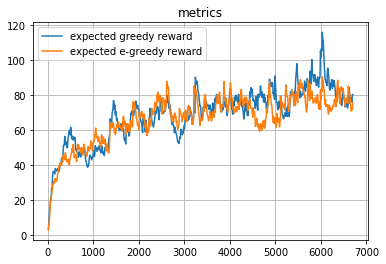

Random session examples


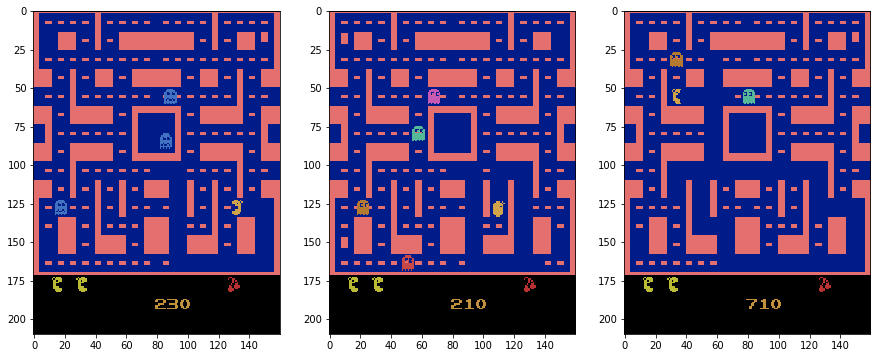

epoch 6710,loss 250.33981, epsilon 0.05055, rewards: ( e-greedy 72.11389, greedy 81.33631) 
rec 244.995 reg 5.345
epoch 6720,loss 478.34013, epsilon 0.05054, rewards: ( e-greedy 73.77750, greedy 82.95268) 
rec 472.991 reg 5.350
epoch 6730,loss 1118.40220, epsilon 0.05054, rewards: ( e-greedy 77.77475, greedy 83.15741) 
rec 1113.042 reg 5.361
epoch 6740,loss 351.24275, epsilon 0.05053, rewards: ( e-greedy 76.49728, greedy 86.46667) 
rec 345.874 reg 5.368
epoch 6750,loss 1538.93219, epsilon 0.05053, rewards: ( e-greedy 78.16005, greedy 85.57000) 
rec 1533.567 reg 5.365
epoch 6760,loss 488.83723, epsilon 0.05052, rewards: ( e-greedy 79.03155, greedy 88.32550) 
rec 483.480 reg 5.357
epoch 6770,loss 396.91188, epsilon 0.05052, rewards: ( e-greedy 77.56589, greedy 90.36795) 
rec 391.555 reg 5.356
epoch 6780,loss 518.50009, epsilon 0.05051, rewards: ( e-greedy 78.87180, greedy 92.51866) 
rec 513.128 reg 5.372
epoch 6790,loss 582.69990, epsilon 0.05051, rewards: ( e-greedy 77.85962, greedy 91.

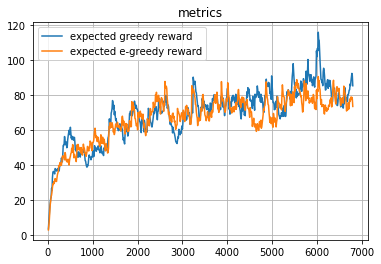

Random session examples


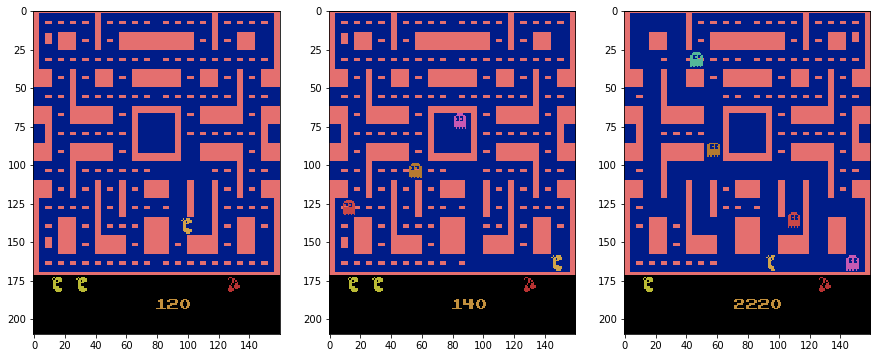

epoch 6810,loss 1020.54036, epsilon 0.05050, rewards: ( e-greedy 75.64754, greedy 80.10610) 
rec 1015.161 reg 5.379
epoch 6820,loss 544.43587, epsilon 0.05049, rewards: ( e-greedy 74.45779, greedy 78.28299) 
rec 539.056 reg 5.379
epoch 6830,loss 302.35576, epsilon 0.05049, rewards: ( e-greedy 71.19951, greedy 76.32969) 
rec 296.975 reg 5.381
epoch 6840,loss 314.07409, epsilon 0.05048, rewards: ( e-greedy 69.26706, greedy 78.63422) 
rec 308.690 reg 5.385
epoch 6850,loss 1919.91413, epsilon 0.05048, rewards: ( e-greedy 71.90285, greedy 86.39580) 
rec 1914.514 reg 5.401
epoch 6860,loss 554.34444, epsilon 0.05047, rewards: ( e-greedy 71.02507, greedy 82.00622) 
rec 548.922 reg 5.423
epoch 6870,loss 955.78799, epsilon 0.05047, rewards: ( e-greedy 74.29756, greedy 78.30560) 
rec 950.346 reg 5.442
epoch 6880,loss 470.81249, epsilon 0.05046, rewards: ( e-greedy 73.18030, greedy 82.16254) 
rec 465.359 reg 5.453
epoch 6890,loss 1768.01230, epsilon 0.05046, rewards: ( e-greedy 76.67477, greedy 78

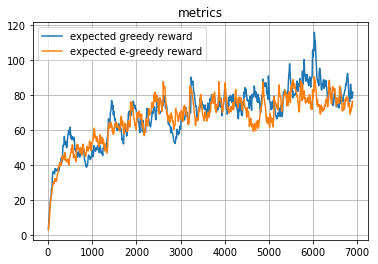

Random session examples


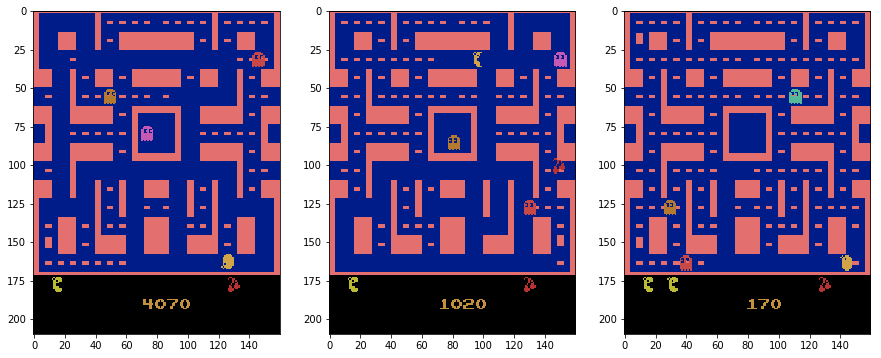

epoch 6910,loss 1216.17235, epsilon 0.05045, rewards: ( e-greedy 77.18782, greedy 78.94837) 
rec 1210.692 reg 5.481
epoch 6920,loss 462.13384, epsilon 0.05044, rewards: ( e-greedy 75.09404, greedy 77.17853) 
rec 456.648 reg 5.486
epoch 6930,loss 2391.89189, epsilon 0.05044, rewards: ( e-greedy 83.20963, greedy 82.64818) 
rec 2386.399 reg 5.493
epoch 6940,loss 1003.97182, epsilon 0.05044, rewards: ( e-greedy 87.45117, greedy 87.82086) 
rec 998.473 reg 5.499
epoch 6950,loss 796.93161, epsilon 0.05043, rewards: ( e-greedy 87.58105, greedy 86.28877) 
rec 791.434 reg 5.498
epoch 6960,loss 233.55189, epsilon 0.05043, rewards: ( e-greedy 82.13545, greedy 83.59740) 
rec 228.051 reg 5.501
epoch 6970,loss 3032.30918, epsilon 0.05042, rewards: ( e-greedy 88.29690, greedy 86.48766) 
rec 3026.806 reg 5.503
epoch 6980,loss 531.70211, epsilon 0.05042, rewards: ( e-greedy 90.59221, greedy 86.21389) 
rec 526.193 reg 5.509
epoch 6990,loss 224.08443, epsilon 0.05041, rewards: ( e-greedy 85.15799, greedy 

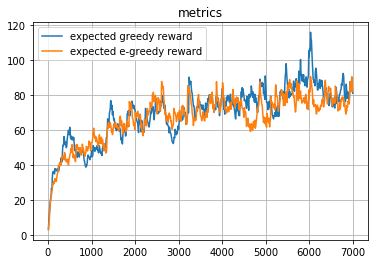

Random session examples


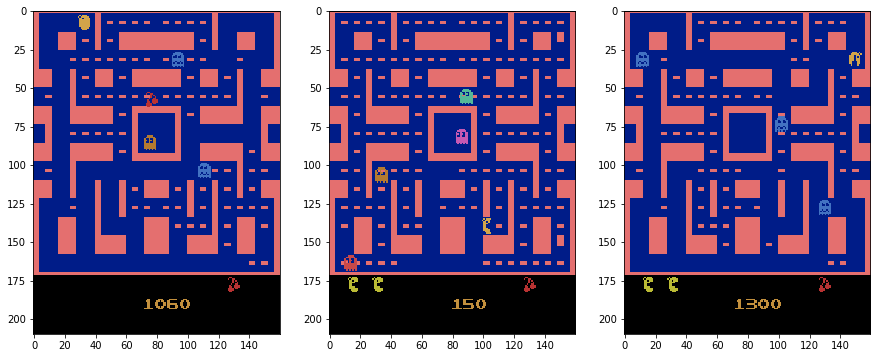

[2017-05-24 04:28:26,637] Making new env: MsPacman-v0
[2017-05-24 04:28:26,801] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 04:28:26,810] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.6.6682.video000000.mp4
[2017-05-24 04:28:28,177] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.6.6682.video000001.mp4


Episode finished after 618 timesteps, rw = 230.0
Episode finished after 693 timesteps, rw = 240.0
Episode finished after 621 timesteps, rw = 170.0
Episode finished after 582 timesteps, rw = 140.0
Episode finished after 601 timesteps, rw = 170.0
Episode finished after 682 timesteps, rw = 210.0
Episode finished after 581 timesteps, rw = 240.0


[2017-05-24 04:28:35,723] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.6.6682.video000008.mp4


Episode finished after 626 timesteps, rw = 170.0
Episode finished after 596 timesteps, rw = 240.0
Episode finished after 690 timesteps, rw = 230.0
Episode finished after 627 timesteps, rw = 250.0
Episode finished after 641 timesteps, rw = 230.0
Episode finished after 600 timesteps, rw = 220.0
Episode finished after 642 timesteps, rw = 140.0
Episode finished after 549 timesteps, rw = 240.0
Episode finished after 627 timesteps, rw = 180.0
Episode finished after 753 timesteps, rw = 210.0
Episode finished after 1330 timesteps, rw = 240.0
Episode finished after 954 timesteps, rw = 240.0


[2017-05-24 04:28:50,651] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 933 timesteps, rw = 240.0
Mean 211.5, Var 1232.75
epoch 7010,loss 671.80447, epsilon 0.05041, rewards: ( e-greedy 82.05297, greedy 80.08743) 
rec 666.270 reg 5.535
epoch 7020,loss 345.50755, epsilon 0.05040, rewards: ( e-greedy 78.53518, greedy 76.89118) 
rec 339.969 reg 5.539
epoch 7030,loss 208.57386, epsilon 0.05040, rewards: ( e-greedy 77.55666, greedy 74.51457) 
rec 203.038 reg 5.536
epoch 7040,loss 1796.90247, epsilon 0.05039, rewards: ( e-greedy 80.61349, greedy 74.75061) 
rec 1791.375 reg 5.527
epoch 7050,loss 1466.02877, epsilon 0.05039, rewards: ( e-greedy 83.17714, greedy 95.83805) 
rec 1460.506 reg 5.523
epoch 7060,loss 402.78173, epsilon 0.05039, rewards: ( e-greedy 80.73443, greedy 92.62924) 
rec 397.250 reg 5.532
epoch 7070,loss 556.23283, epsilon 0.05038, rewards: ( e-greedy 78.66099, greedy 89.49132) 
rec 550.677 reg 5.556
epoch 7080,loss 427.58511, epsilon 0.05038, rewards: ( e-greedy 76.91989, greedy 87.22969) 
rec 421.967 reg 5.618
epoch 7090,

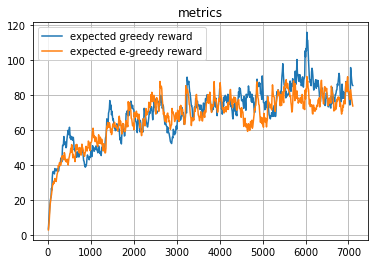

Random session examples


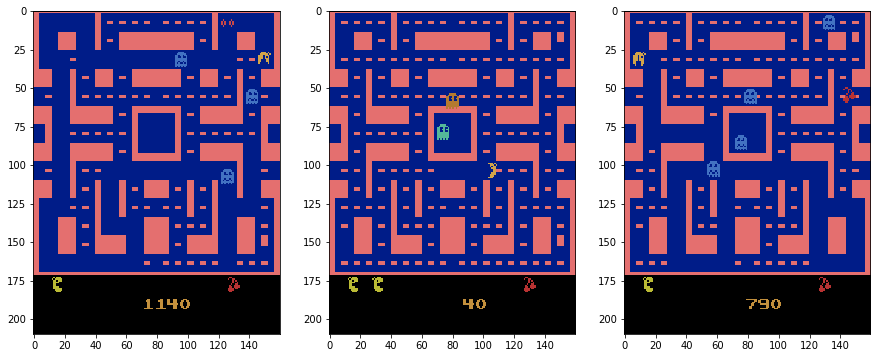

epoch 7110,loss 238.19322, epsilon 0.05037, rewards: ( e-greedy 71.13397, greedy 81.68169) 
rec 232.450 reg 5.743
epoch 7120,loss 2266.06396, epsilon 0.05036, rewards: ( e-greedy 77.77058, greedy 81.45102) 
rec 2260.313 reg 5.750
epoch 7130,loss 1935.79684, epsilon 0.05036, rewards: ( e-greedy 82.86852, greedy 80.36842) 
rec 1930.033 reg 5.764
epoch 7140,loss 773.50049, epsilon 0.05036, rewards: ( e-greedy 84.20667, greedy 78.01908) 
rec 767.727 reg 5.773
epoch 7150,loss 872.92686, epsilon 0.05035, rewards: ( e-greedy 83.66100, greedy 79.77967) 
rec 867.157 reg 5.770
epoch 7160,loss 299.57636, epsilon 0.05035, rewards: ( e-greedy 81.73240, greedy 77.11420) 
rec 293.814 reg 5.762
epoch 7170,loss 401.86658, epsilon 0.05035, rewards: ( e-greedy 81.37166, greedy 77.84028) 
rec 396.104 reg 5.763
epoch 7180,loss 833.58296, epsilon 0.05034, rewards: ( e-greedy 79.73449, greedy 75.24375) 
rec 827.818 reg 5.765
epoch 7190,loss 960.59017, epsilon 0.05034, rewards: ( e-greedy 79.01104, greedy 75.

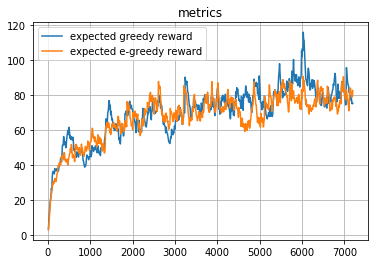

Random session examples


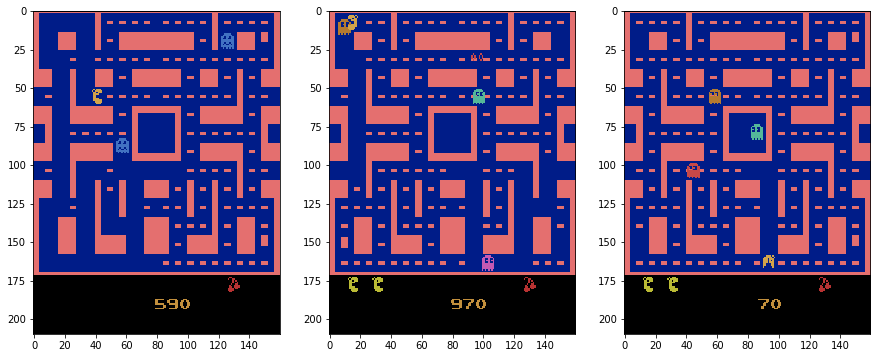

epoch 7210,loss 355.63258, epsilon 0.05033, rewards: ( e-greedy 81.39895, greedy 70.61957) 
rec 349.894 reg 5.739
epoch 7220,loss 335.68789, epsilon 0.05033, rewards: ( e-greedy 77.82155, greedy 68.12011) 
rec 329.962 reg 5.726
epoch 7230,loss 245.32114, epsilon 0.05033, rewards: ( e-greedy 76.16440, greedy 75.30810) 
rec 239.610 reg 5.711
epoch 7240,loss 251.58863, epsilon 0.05032, rewards: ( e-greedy 75.92296, greedy 79.08979) 
rec 245.889 reg 5.699
epoch 7250,loss 1946.72884, epsilon 0.05032, rewards: ( e-greedy 79.01816, greedy 77.99331) 
rec 1941.041 reg 5.688
epoch 7260,loss 291.55283, epsilon 0.05032, rewards: ( e-greedy 76.05384, greedy 80.13148) 
rec 285.864 reg 5.689
epoch 7270,loss 634.28956, epsilon 0.05031, rewards: ( e-greedy 74.57346, greedy 80.36833) 
rec 628.591 reg 5.698
epoch 7280,loss 576.54153, epsilon 0.05031, rewards: ( e-greedy 74.17861, greedy 78.08150) 
rec 570.840 reg 5.702
epoch 7290,loss 1853.98687, epsilon 0.05031, rewards: ( e-greedy 83.63575, greedy 89.5

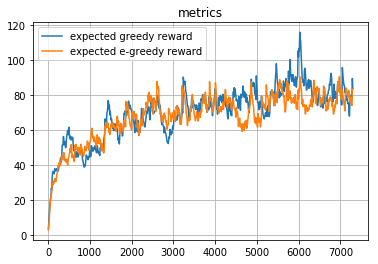

Random session examples


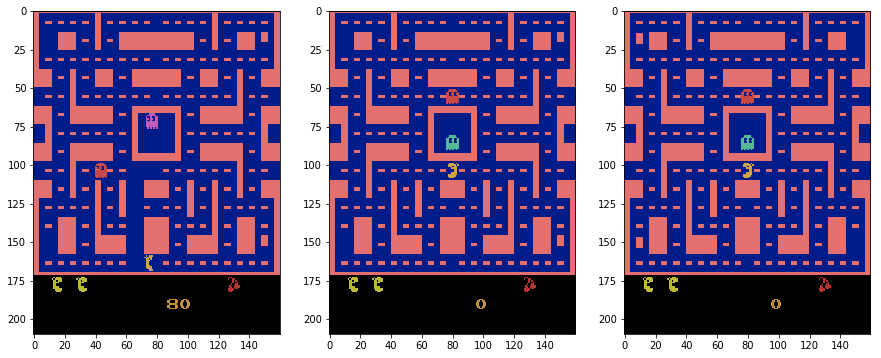

epoch 7310,loss 566.92149, epsilon 0.05030, rewards: ( e-greedy 82.16371, greedy 79.98954) 
rec 561.238 reg 5.683
epoch 7320,loss 1152.09341, epsilon 0.05030, rewards: ( e-greedy 84.07234, greedy 83.92809) 
rec 1146.420 reg 5.674
epoch 7330,loss 375.76982, epsilon 0.05030, rewards: ( e-greedy 84.54010, greedy 81.53528) 
rec 370.094 reg 5.676
epoch 7340,loss 1981.36493, epsilon 0.05029, rewards: ( e-greedy 88.83609, greedy 78.31925) 
rec 1975.682 reg 5.683
epoch 7350,loss 495.61398, epsilon 0.05029, rewards: ( e-greedy 85.57749, greedy 75.48732) 
rec 489.918 reg 5.696
epoch 7360,loss 1644.47131, epsilon 0.05029, rewards: ( e-greedy 90.08224, greedy 74.68859) 
rec 1638.753 reg 5.719
epoch 21280,loss 1812.31088, epsilon 0.05000, rewards: ( e-greedy 106.32739, greedy 85.80481) 
rec 1803.534 reg 8.777
epoch 21290,loss 654.98846, epsilon 0.05000, rewards: ( e-greedy 101.19465, greedy 83.72433) 
rec 646.206 reg 8.783
epoch 21300,loss 443.89878, epsilon 0.05000, rewards: ( e-greedy 96.82518, g

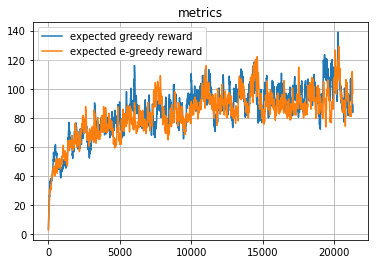

Random session examples


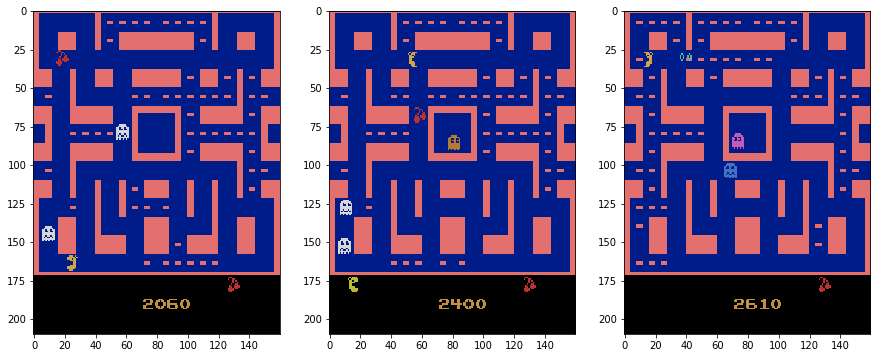

epoch 21310,loss 861.29865, epsilon 0.05000, rewards: ( e-greedy 94.01767, greedy 87.22920) 
rec 852.518 reg 8.781
epoch 21320,loss 1748.78982, epsilon 0.05000, rewards: ( e-greedy 99.24090, greedy 94.88128) 
rec 1740.013 reg 8.777
epoch 21330,loss 1765.29115, epsilon 0.05000, rewards: ( e-greedy 99.56681, greedy 99.95566) 
rec 1756.518 reg 8.773
epoch 21340,loss 565.49572, epsilon 0.05000, rewards: ( e-greedy 98.48513, greedy 97.71009) 
rec 556.727 reg 8.769
epoch 21350,loss 769.73148, epsilon 0.05000, rewards: ( e-greedy 96.94912, greedy 97.43908) 
rec 760.963 reg 8.769
epoch 21360,loss 1222.26115, epsilon 0.05000, rewards: ( e-greedy 96.12920, greedy 94.57017) 
rec 1213.495 reg 8.767
epoch 21370,loss 434.34298, epsilon 0.05000, rewards: ( e-greedy 93.26628, greedy 90.36316) 
rec 425.582 reg 8.761
epoch 21380,loss 2335.16662, epsilon 0.05000, rewards: ( e-greedy 100.56466, greedy 91.38934) 
rec 2326.411 reg 8.755
epoch 21390,loss 527.64564, epsilon 0.05000, rewards: ( e-greedy 96.258

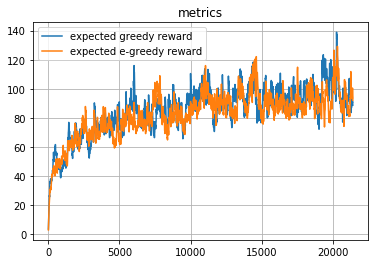

Random session examples


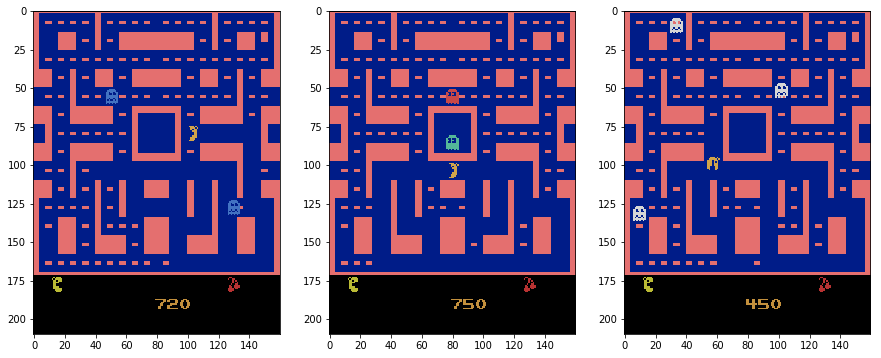

epoch 21410,loss 4540.80778, epsilon 0.05000, rewards: ( e-greedy 97.60663, greedy 92.45470) 
rec 4532.044 reg 8.764
epoch 21420,loss 2845.05388, epsilon 0.05000, rewards: ( e-greedy 101.53347, greedy 94.33423) 
rec 2836.299 reg 8.755
epoch 21430,loss 1355.89093, epsilon 0.05000, rewards: ( e-greedy 105.06762, greedy 90.21331) 
rec 1347.144 reg 8.747
epoch 21440,loss 1878.09000, epsilon 0.05000, rewards: ( e-greedy 104.06086, greedy 88.44198) 
rec 1869.348 reg 8.742
epoch 21450,loss 3583.54596, epsilon 0.05000, rewards: ( e-greedy 118.84227, greedy 99.41028) 
rec 3574.807 reg 8.739
epoch 21460,loss 602.70085, epsilon 0.05000, rewards: ( e-greedy 112.02055, greedy 99.09425) 
rec 593.957 reg 8.744
epoch 21470,loss 839.28512, epsilon 0.05000, rewards: ( e-greedy 109.50599, greedy 95.87233) 
rec 830.544 reg 8.741
epoch 21480,loss 2998.72707, epsilon 0.05000, rewards: ( e-greedy 121.99289, greedy 105.16009) 
rec 2989.983 reg 8.744
epoch 21490,loss 599.87089, epsilon 0.05000, rewards: ( e-gr

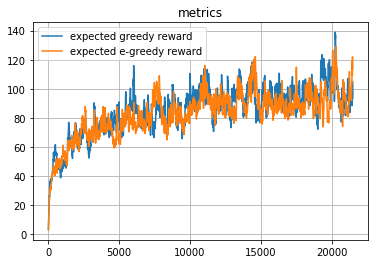

Random session examples


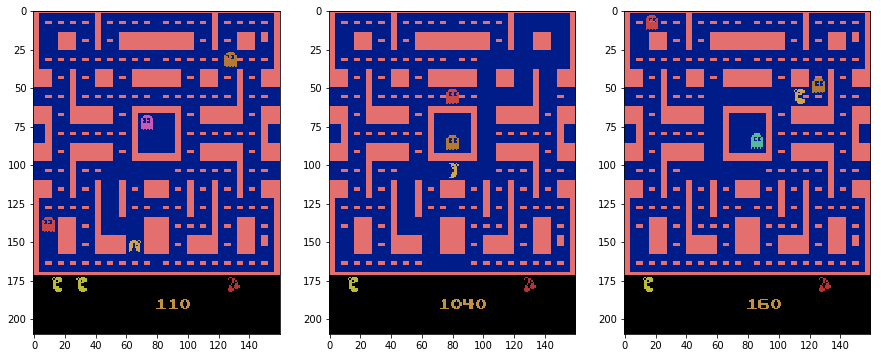

epoch 21510,loss 1083.68960, epsilon 0.05000, rewards: ( e-greedy 112.94969, greedy 99.31921) 
rec 1074.945 reg 8.745
epoch 21520,loss 516.42535, epsilon 0.05000, rewards: ( e-greedy 110.65472, greedy 107.19979) 
rec 507.684 reg 8.742
epoch 21530,loss 738.08038, epsilon 0.05000, rewards: ( e-greedy 107.52675, greedy 103.85481) 
rec 729.340 reg 8.740
epoch 21540,loss 853.44811, epsilon 0.05000, rewards: ( e-greedy 108.08658, greedy 100.59433) 
rec 844.712 reg 8.736
epoch 21550,loss 1314.54719, epsilon 0.05000, rewards: ( e-greedy 107.59042, greedy 97.22240) 
rec 1305.812 reg 8.735
epoch 21560,loss 588.86145, epsilon 0.05000, rewards: ( e-greedy 102.64388, greedy 95.43766) 
rec 580.126 reg 8.735
epoch 21570,loss 881.08179, epsilon 0.05000, rewards: ( e-greedy 101.44199, greedy 101.76889) 
rec 872.346 reg 8.736
epoch 21580,loss 7624.79034, epsilon 0.05000, rewards: ( e-greedy 109.67279, greedy 105.52950) 
rec 7616.052 reg 8.738
epoch 21590,loss 1645.27337, epsilon 0.05000, rewards: ( e-gr

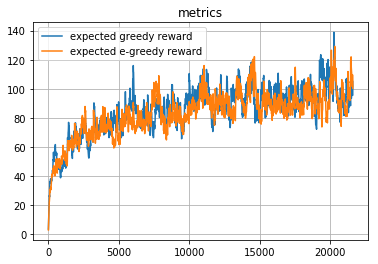

Random session examples


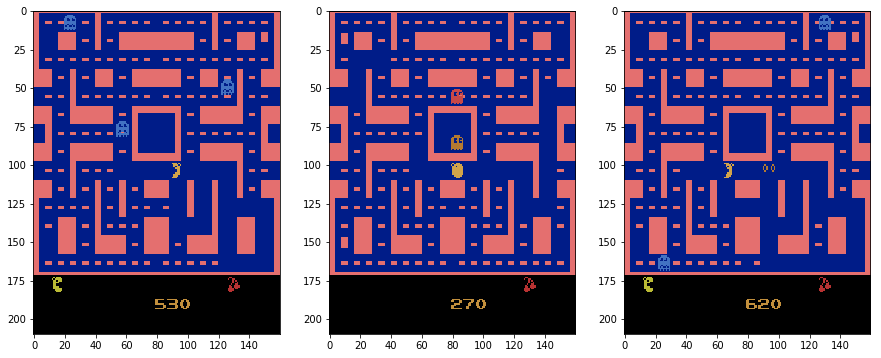

epoch 21610,loss 659.71875, epsilon 0.05000, rewards: ( e-greedy 99.44896, greedy 100.85351) 
rec 650.985 reg 8.734
epoch 21620,loss 695.52790, epsilon 0.05000, rewards: ( e-greedy 96.12907, greedy 106.14316) 
rec 686.789 reg 8.739
epoch 21630,loss 867.38201, epsilon 0.05000, rewards: ( e-greedy 94.64116, greedy 103.59134) 
rec 858.637 reg 8.745
epoch 21640,loss 690.80164, epsilon 0.05000, rewards: ( e-greedy 93.17705, greedy 104.91971) 
rec 682.059 reg 8.743
epoch 21650,loss 1933.15194, epsilon 0.05000, rewards: ( e-greedy 101.73434, greedy 109.05274) 
rec 1924.413 reg 8.739
epoch 21660,loss 2092.85426, epsilon 0.05000, rewards: ( e-greedy 106.99841, greedy 103.27246) 
rec 2084.119 reg 8.736
epoch 21670,loss 696.41964, epsilon 0.05000, rewards: ( e-greedy 104.11107, greedy 105.94522) 
rec 687.685 reg 8.735
epoch 21680,loss 678.17234, epsilon 0.05000, rewards: ( e-greedy 99.57496, greedy 105.85069) 
rec 669.439 reg 8.733
epoch 21690,loss 770.20541, epsilon 0.05000, rewards: ( e-greedy 

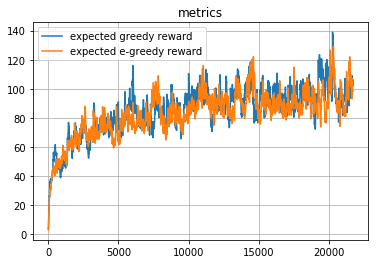

Random session examples


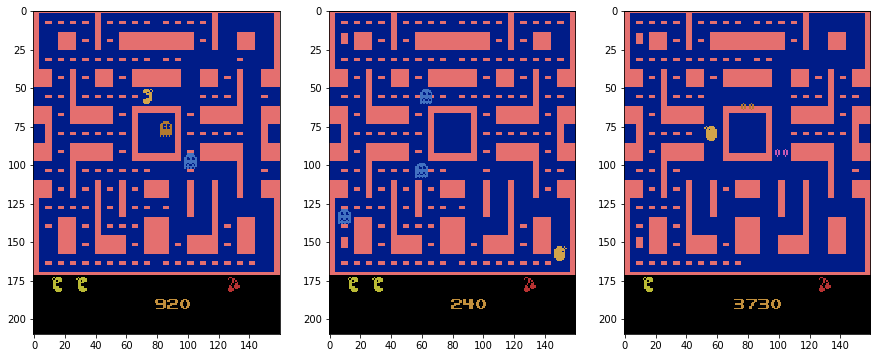

epoch 21710,loss 444.33221, epsilon 0.05000, rewards: ( e-greedy 93.87327, greedy 107.16016) 
rec 435.583 reg 8.749
epoch 21720,loss 951.35336, epsilon 0.05000, rewards: ( e-greedy 94.11094, greedy 102.94414) 
rec 942.605 reg 8.748
epoch 21730,loss 494.28313, epsilon 0.05000, rewards: ( e-greedy 90.51235, greedy 96.77473) 
rec 485.536 reg 8.747
epoch 21740,loss 6749.39812, epsilon 0.05000, rewards: ( e-greedy 102.89861, greedy 93.59725) 
rec 6740.653 reg 8.745
epoch 21750,loss 1837.60638, epsilon 0.05000, rewards: ( e-greedy 106.73375, greedy 103.42503) 
rec 1828.865 reg 8.741
epoch 21760,loss 1109.99327, epsilon 0.05000, rewards: ( e-greedy 102.56038, greedy 101.52003) 
rec 1101.249 reg 8.744
epoch 21770,loss 5013.92944, epsilon 0.05000, rewards: ( e-greedy 103.42934, greedy 100.93052) 
rec 5005.181 reg 8.748
epoch 21780,loss 2138.63971, epsilon 0.05000, rewards: ( e-greedy 103.71141, greedy 95.64997) 
rec 2129.887 reg 8.753
epoch 21790,loss 2383.11496, epsilon 0.05000, rewards: ( e-g

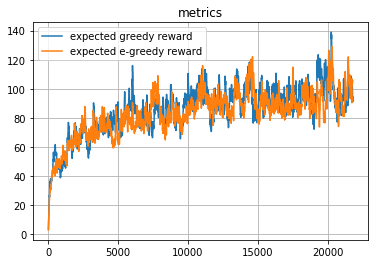

Random session examples


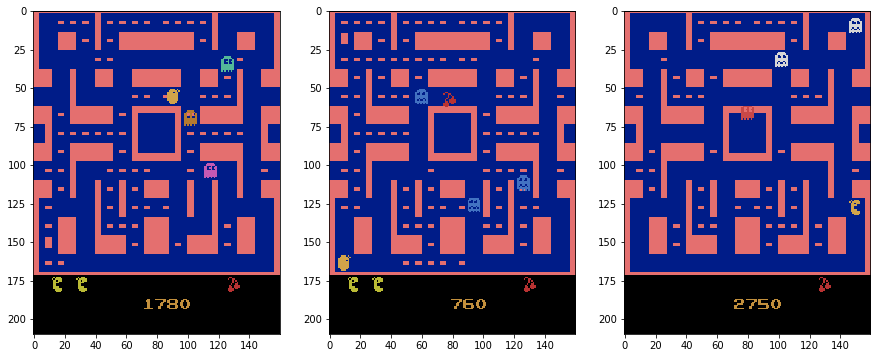

epoch 21810,loss 899.62714, epsilon 0.05000, rewards: ( e-greedy 102.92061, greedy 96.28445) 
rec 890.865 reg 8.762
epoch 21820,loss 6860.11229, epsilon 0.05000, rewards: ( e-greedy 109.94105, greedy 96.21851) 
rec 6851.340 reg 8.772
epoch 21830,loss 774.25564, epsilon 0.05000, rewards: ( e-greedy 106.13445, greedy 105.22166) 
rec 765.477 reg 8.778
epoch 21840,loss 910.59594, epsilon 0.05000, rewards: ( e-greedy 104.95850, greedy 103.13699) 
rec 901.804 reg 8.792
epoch 21850,loss 1006.24402, epsilon 0.05000, rewards: ( e-greedy 102.15015, greedy 100.69829) 
rec 997.438 reg 8.806
epoch 21860,loss 923.31777, epsilon 0.05000, rewards: ( e-greedy 100.06014, greedy 98.06596) 
rec 914.507 reg 8.810
epoch 21870,loss 389.49496, epsilon 0.05000, rewards: ( e-greedy 96.30412, greedy 94.88437) 
rec 380.685 reg 8.810
epoch 21880,loss 1032.83356, epsilon 0.05000, rewards: ( e-greedy 94.98621, greedy 96.64593) 
rec 1024.022 reg 8.811
epoch 21890,loss 758.26732, epsilon 0.05000, rewards: ( e-greedy 9

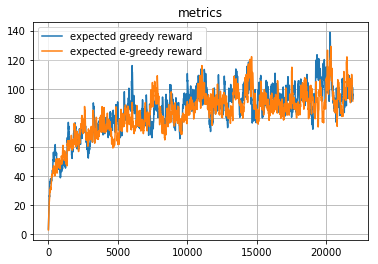

Random session examples


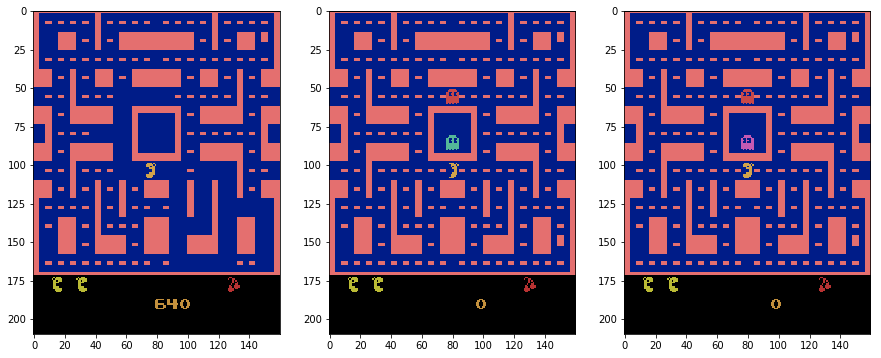

epoch 21910,loss 1607.30914, epsilon 0.05000, rewards: ( e-greedy 93.20182, greedy 105.83738) 
rec 1598.487 reg 8.823
epoch 21920,loss 2503.92581, epsilon 0.05000, rewards: ( e-greedy 96.31914, greedy 104.81614) 
rec 2495.104 reg 8.822
epoch 21930,loss 632.71396, epsilon 0.05000, rewards: ( e-greedy 90.87473, greedy 100.08453) 
rec 623.893 reg 8.821
epoch 21940,loss 2109.39213, epsilon 0.05000, rewards: ( e-greedy 95.97475, greedy 103.26358) 
rec 2100.568 reg 8.824
epoch 21950,loss 802.24101, epsilon 0.05000, rewards: ( e-greedy 95.00228, greedy 100.12472) 
rec 793.413 reg 8.828
epoch 21960,loss 1201.42753, epsilon 0.05000, rewards: ( e-greedy 94.50205, greedy 112.92475) 
rec 1192.591 reg 8.837
epoch 21970,loss 659.48839, epsilon 0.05000, rewards: ( e-greedy 91.80185, greedy 108.25727) 
rec 650.645 reg 8.843
epoch 21980,loss 838.67200, epsilon 0.05000, rewards: ( e-greedy 89.55916, greedy 119.05655) 
rec 829.820 reg 8.852
epoch 21990,loss 2046.02476, epsilon 0.05000, rewards: ( e-greed

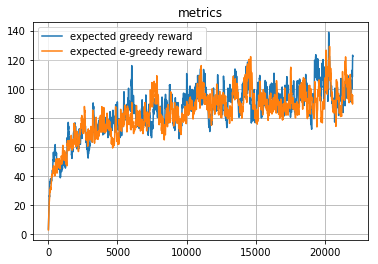

Random session examples


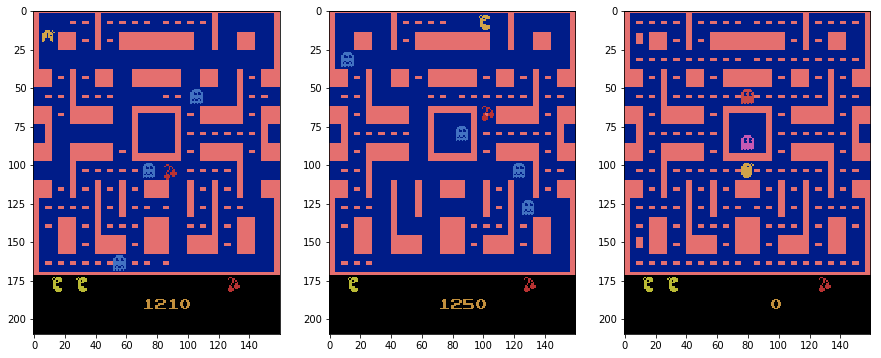

[2017-05-24 11:17:41,727] Making new env: MsPacman-v0
[2017-05-24 11:17:41,896] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 11:17:41,905] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.21.6682.video000000.mp4
[2017-05-24 11:17:43,697] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.21.6682.video000001.mp4


Episode finished after 828 timesteps, rw = 240.0
Episode finished after 606 timesteps, rw = 220.0
Episode finished after 833 timesteps, rw = 240.0
Episode finished after 624 timesteps, rw = 240.0
Episode finished after 829 timesteps, rw = 240.0
Episode finished after 634 timesteps, rw = 240.0
Episode finished after 971 timesteps, rw = 490.0


[2017-05-24 11:17:52,732] Starting new video recorder writing to /home/vishimtsev/folder/fat_videos/openaigym.video.21.6682.video000008.mp4


Episode finished after 625 timesteps, rw = 170.0
Episode finished after 612 timesteps, rw = 230.0
Episode finished after 1114 timesteps, rw = 240.0
Episode finished after 864 timesteps, rw = 240.0
Episode finished after 863 timesteps, rw = 260.0
Episode finished after 750 timesteps, rw = 300.0
Episode finished after 643 timesteps, rw = 190.0
Episode finished after 704 timesteps, rw = 210.0
Episode finished after 838 timesteps, rw = 300.0
Episode finished after 537 timesteps, rw = 240.0
Episode finished after 641 timesteps, rw = 220.0
Episode finished after 681 timesteps, rw = 300.0


[2017-05-24 11:18:08,260] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/fat_videos')


Episode finished after 682 timesteps, rw = 320.0
Mean 256.5, Var 4192.75
epoch 22010,loss 467.46728, epsilon 0.05000, rewards: ( e-greedy 89.37738, greedy 117.22722) 
rec 458.567 reg 8.900
epoch 22020,loss 808.84091, epsilon 0.05000, rewards: ( e-greedy 91.68964, greedy 118.87950) 
rec 799.935 reg 8.906
epoch 22030,loss 543.31155, epsilon 0.05000, rewards: ( e-greedy 88.39568, greedy 113.99155) 
rec 534.406 reg 8.906
epoch 22040,loss 1519.98874, epsilon 0.05000, rewards: ( e-greedy 86.18111, greedy 110.40489) 
rec 1511.090 reg 8.899
epoch 22050,loss 2165.12876, epsilon 0.05000, rewards: ( e-greedy 98.75050, greedy 122.42691) 
rec 2156.239 reg 8.889
epoch 22060,loss 419.27321, epsilon 0.05000, rewards: ( e-greedy 95.62545, greedy 124.05921) 
rec 410.386 reg 8.887
epoch 22070,loss 5624.30401, epsilon 0.05000, rewards: ( e-greedy 103.68790, greedy 122.46579) 
rec 5615.417 reg 8.887
epoch 22080,loss 804.48933, epsilon 0.05000, rewards: ( e-greedy 99.00661, greedy 119.15671) 
rec 795.595 re

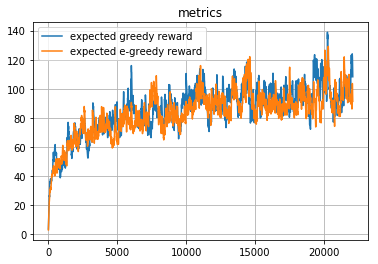

Random session examples


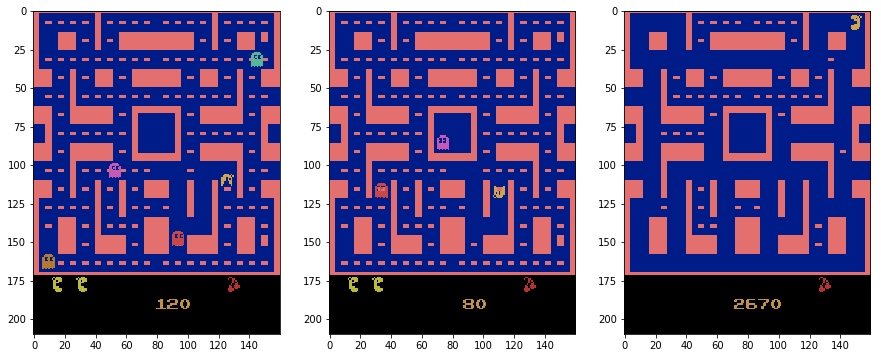

epoch 22110,loss 712.18146, epsilon 0.05000, rewards: ( e-greedy 89.35207, greedy 105.74087) 
rec 703.261 reg 8.920
epoch 22120,loss 958.33494, epsilon 0.05000, rewards: ( e-greedy 89.54186, greedy 110.04178) 
rec 949.407 reg 8.928
epoch 22130,loss 1169.65171, epsilon 0.05000, rewards: ( e-greedy 88.46268, greedy 105.72510) 
rec 1160.705 reg 8.947
epoch 22140,loss 792.61133, epsilon 0.05000, rewards: ( e-greedy 90.55391, greedy 106.90259) 
rec 783.650 reg 8.961
epoch 22150,loss 539.86821, epsilon 0.05000, rewards: ( e-greedy 89.87352, greedy 104.46233) 
rec 530.906 reg 8.962
epoch 22160,loss 658.08900, epsilon 0.05000, rewards: ( e-greedy 89.63617, greedy 105.64110) 
rec 649.119 reg 8.970
epoch 22170,loss 1037.21276, epsilon 0.05000, rewards: ( e-greedy 89.42255, greedy 105.51449) 
rec 1028.239 reg 8.974
epoch 22180,loss 5222.80880, epsilon 0.05000, rewards: ( e-greedy 91.79280, greedy 103.96304) 
rec 5213.833 reg 8.975
epoch 22190,loss 1150.68627, epsilon 0.05000, rewards: ( e-greedy 

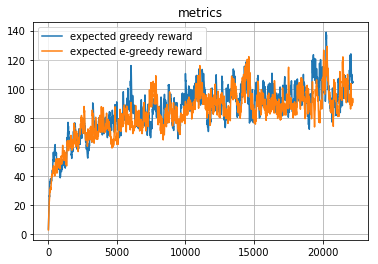

Random session examples


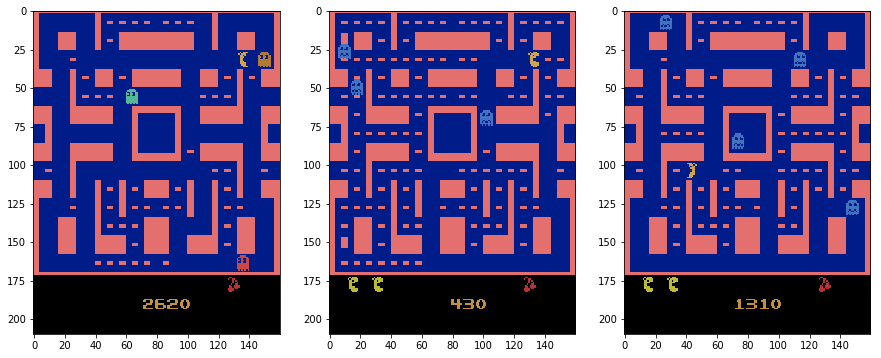

epoch 22210,loss 1103.93828, epsilon 0.05000, rewards: ( e-greedy 89.86882, greedy 103.15593) 
rec 1094.966 reg 8.972
epoch 22220,loss 8752.47455, epsilon 0.05000, rewards: ( e-greedy 103.88194, greedy 105.52784) 
rec 8743.509 reg 8.966
epoch 22230,loss 507.92198, epsilon 0.05000, rewards: ( e-greedy 100.11875, greedy 106.72506) 
rec 498.963 reg 8.959
epoch 22240,loss 945.59518, epsilon 0.05000, rewards: ( e-greedy 97.10687, greedy 104.11505) 
rec 936.633 reg 8.962
epoch 22250,loss 1040.40381, epsilon 0.05000, rewards: ( e-greedy 98.89618, greedy 100.70354) 
rec 1031.444 reg 8.960
epoch 22260,loss 6627.40413, epsilon 0.05000, rewards: ( e-greedy 105.31907, greedy 103.88319) 
rec 6618.448 reg 8.956
epoch 22270,loss 2414.65379, epsilon 0.05000, rewards: ( e-greedy 106.16216, greedy 99.11987) 
rec 2405.697 reg 8.957
epoch 22280,loss 850.79043, epsilon 0.05000, rewards: ( e-greedy 103.48344, greedy 100.39538) 
rec 841.832 reg 8.958
epoch 22290,loss 1065.55061, epsilon 0.05000, rewards: ( e

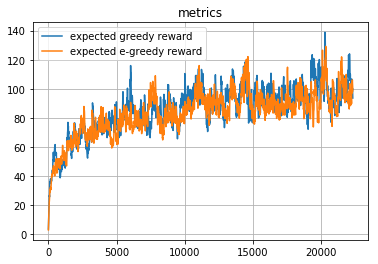

Random session examples


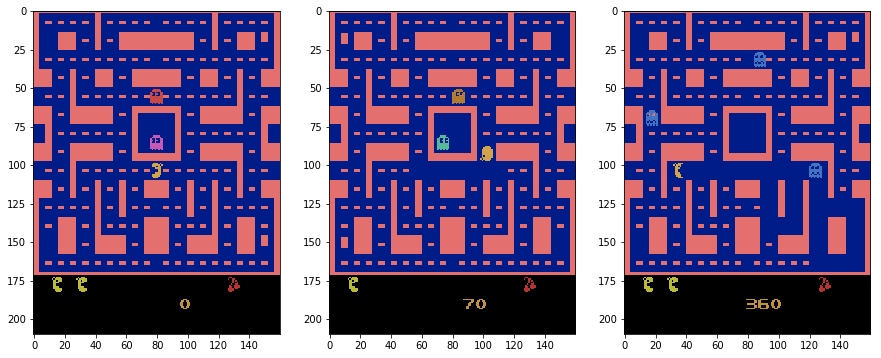

epoch 22310,loss 2399.54565, epsilon 0.05000, rewards: ( e-greedy 103.15756, greedy 89.38261) 
rec 2390.553 reg 8.992
epoch 22320,loss 1717.40323, epsilon 0.05000, rewards: ( e-greedy 102.52930, greedy 95.38185) 
rec 1708.397 reg 9.006
epoch 22330,loss 647.55752, epsilon 0.05000, rewards: ( e-greedy 99.08887, greedy 103.71866) 
rec 638.545 reg 9.012
epoch 22340,loss 2542.35980, epsilon 0.05000, rewards: ( e-greedy 100.99248, greedy 103.34680) 
rec 2533.346 reg 9.013
epoch 22350,loss 1004.39298, epsilon 0.05000, rewards: ( e-greedy 101.70573, greedy 99.94962) 
rec 995.380 reg 9.013
epoch 22360,loss 1151.45152, epsilon 0.05000, rewards: ( e-greedy 96.78516, greedy 94.57966) 
rec 1142.440 reg 9.011
epoch 22370,loss 1013.78665, epsilon 0.05000, rewards: ( e-greedy 98.60664, greedy 98.55919) 
rec 1004.777 reg 9.009
epoch 22380,loss 1290.35479, epsilon 0.05000, rewards: ( e-greedy 104.24598, greedy 96.76577) 
rec 1281.346 reg 9.009
epoch 22390,loss 530.94932, epsilon 0.05000, rewards: ( e-gr

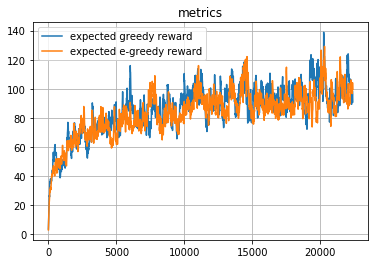

Random session examples


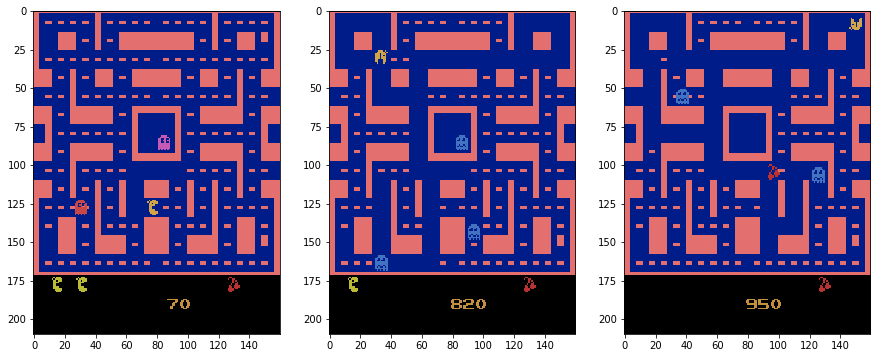

epoch 22410,loss 1714.74511, epsilon 0.05000, rewards: ( e-greedy 102.57282, greedy 96.48412) 
rec 1705.749 reg 8.996
epoch 22420,loss 6129.33451, epsilon 0.05000, rewards: ( e-greedy 104.56554, greedy 96.52321) 
rec 6120.344 reg 8.990
epoch 22430,loss 3169.74613, epsilon 0.05000, rewards: ( e-greedy 110.67148, greedy 97.24589) 
rec 3160.762 reg 8.984
epoch 22440,loss 453.90594, epsilon 0.05000, rewards: ( e-greedy 102.72934, greedy 92.95880) 
rec 444.926 reg 8.980
epoch 22450,loss 548.93705, epsilon 0.05000, rewards: ( e-greedy 99.45640, greedy 97.66292) 
rec 539.961 reg 8.976
epoch 22460,loss 747.94266, epsilon 0.05000, rewards: ( e-greedy 97.88576, greedy 98.58413) 
rec 738.972 reg 8.971
epoch 22470,loss 2286.86345, epsilon 0.05000, rewards: ( e-greedy 103.03469, greedy 96.22572) 
rec 2277.898 reg 8.966
epoch 22480,loss 2163.18752, epsilon 0.05000, rewards: ( e-greedy 107.23122, greedy 113.60314) 
rec 2154.227 reg 8.960
epoch 22490,loss 3310.94343, epsilon 0.05000, rewards: ( e-gree

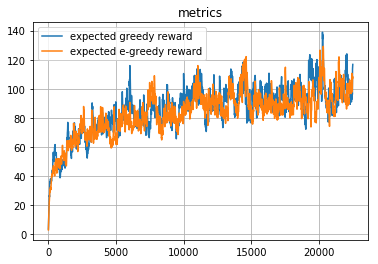

Random session examples


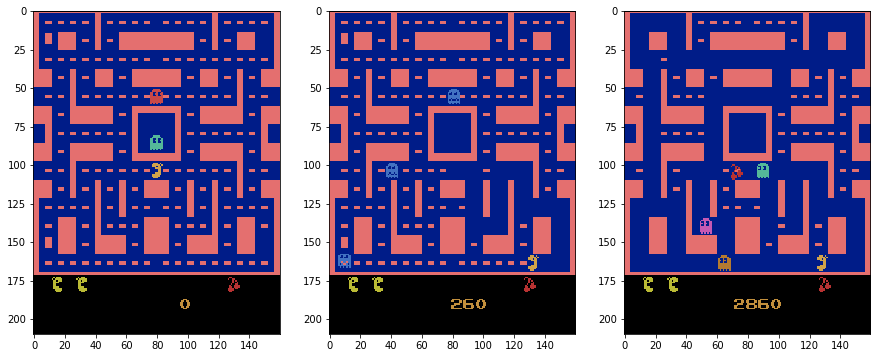

epoch 22510,loss 1733.62801, epsilon 0.05000, rewards: ( e-greedy 109.21656, greedy 119.06857) 
rec 1724.664 reg 8.964
epoch 22520,loss 684.49905, epsilon 0.05000, rewards: ( e-greedy 103.16990, greedy 113.41171) 
rec 675.528 reg 8.971
epoch 22530,loss 636.43323, epsilon 0.05000, rewards: ( e-greedy 98.60291, greedy 107.57054) 
rec 627.461 reg 8.972
epoch 22540,loss 1792.96417, epsilon 0.05000, rewards: ( e-greedy 101.11762, greedy 124.68849) 
rec 1783.985 reg 8.979
epoch 22550,loss 768.66571, epsilon 0.05000, rewards: ( e-greedy 96.81836, greedy 124.71964) 
rec 759.677 reg 8.988
epoch 22560,loss 1584.69337, epsilon 0.05000, rewards: ( e-greedy 99.01152, greedy 122.74767) 
rec 1575.702 reg 8.991
epoch 22570,loss 1209.64121, epsilon 0.05000, rewards: ( e-greedy 101.23537, greedy 131.53541) 
rec 1200.653 reg 8.988
epoch 22580,loss 1085.52250, epsilon 0.05000, rewards: ( e-greedy 99.67433, greedy 133.56937) 
rec 1076.540 reg 8.982
epoch 22590,loss 850.80387, epsilon 0.05000, rewards: ( e-

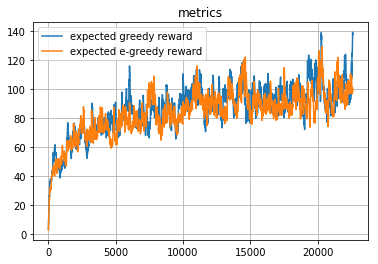

Random session examples


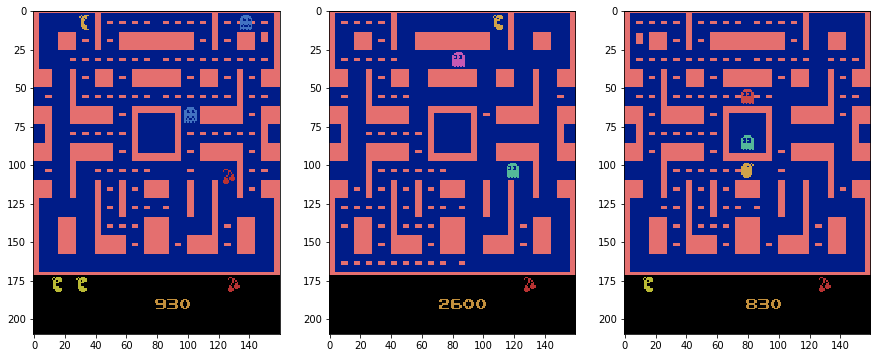

epoch 22610,loss 1946.61228, epsilon 0.05000, rewards: ( e-greedy 97.81134, greedy 130.20582) 
rec 1937.598 reg 9.015
epoch 22620,loss 2479.98213, epsilon 0.05000, rewards: ( e-greedy 101.96770, greedy 128.12274) 
rec 2470.957 reg 9.025
epoch 22630,loss 744.34204, epsilon 0.05000, rewards: ( e-greedy 101.83343, greedy 126.37296) 
rec 735.310 reg 9.032
epoch 22640,loss 724.62711, epsilon 0.05000, rewards: ( e-greedy 96.15009, greedy 118.73567) 
rec 715.593 reg 9.034
epoch 22650,loss 1389.87114, epsilon 0.05000, rewards: ( e-greedy 97.16008, greedy 113.11210) 
rec 1380.837 reg 9.034
epoch 22660,loss 1101.84059, epsilon 0.05000, rewards: ( e-greedy 98.56907, greedy 116.86339) 
rec 1092.808 reg 9.033
epoch 22670,loss 6937.26189, epsilon 0.05000, rewards: ( e-greedy 103.21217, greedy 111.55205) 
rec 6928.233 reg 9.028
epoch 22680,loss 4312.75256, epsilon 0.05000, rewards: ( e-greedy 107.95345, greedy 107.02185) 
rec 4303.725 reg 9.028
epoch 22690,loss 2717.37162, epsilon 0.05000, rewards: (

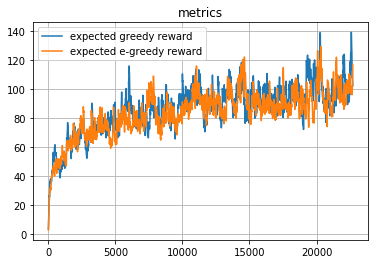

Random session examples


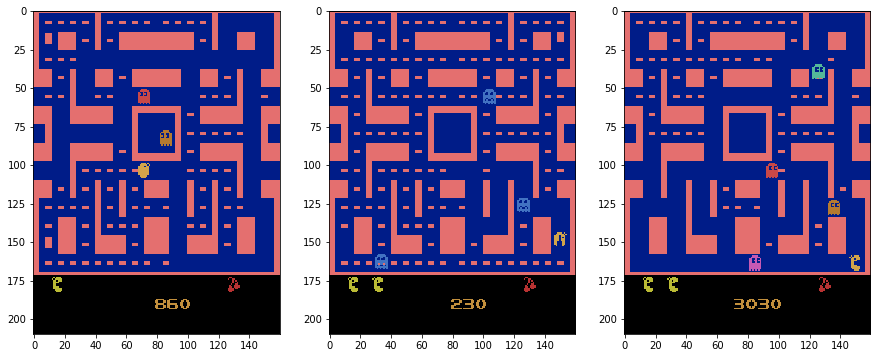

epoch 22710,loss 1249.67344, epsilon 0.05000, rewards: ( e-greedy 113.49119, greedy 98.99643) 
rec 1240.653 reg 9.021
epoch 22720,loss 1033.16529, epsilon 0.05000, rewards: ( e-greedy 112.07957, greedy 99.28428) 
rec 1024.142 reg 9.023
epoch 22730,loss 809.86881, epsilon 0.05000, rewards: ( e-greedy 112.62161, greedy 100.91835) 
rec 800.844 reg 9.025
epoch 22740,loss 477.88553, epsilon 0.05000, rewards: ( e-greedy 107.73445, greedy 99.82652) 
rec 468.858 reg 9.027
epoch 22750,loss 3574.78015, epsilon 0.05000, rewards: ( e-greedy 111.77351, greedy 107.15637) 
rec 3565.750 reg 9.030
epoch 22760,loss 805.83346, epsilon 0.05000, rewards: ( e-greedy 107.53366, greedy 102.81573) 
rec 796.794 reg 9.039
epoch 22770,loss 2076.64093, epsilon 0.05000, rewards: ( e-greedy 104.53029, greedy 97.28416) 
rec 2067.589 reg 9.052
epoch 22780,loss 2240.84405, epsilon 0.05000, rewards: ( e-greedy 108.38976, greedy 96.36824) 
rec 2231.773 reg 9.071
epoch 22790,loss 1280.84928, epsilon 0.05000, rewards: ( e-

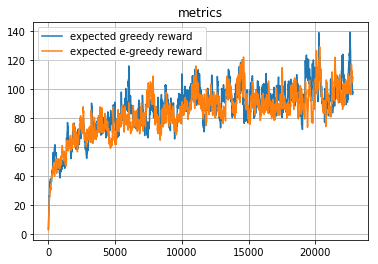

Random session examples


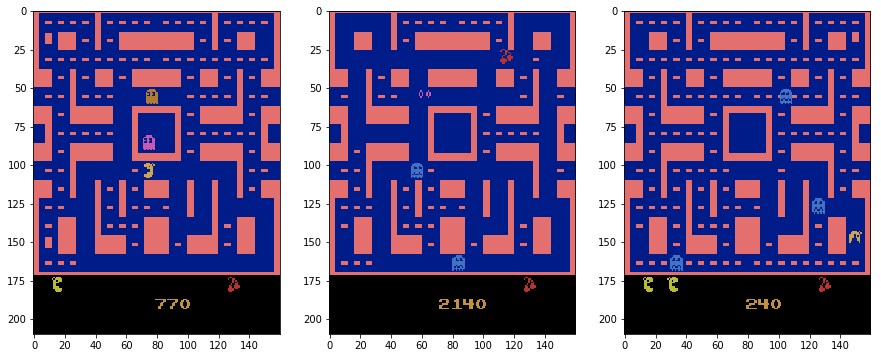

epoch 22810,loss 424.85941, epsilon 0.05000, rewards: ( e-greedy 100.54489, greedy 94.09245) 
rec 415.749 reg 9.111
epoch 22820,loss 711.09160, epsilon 0.05000, rewards: ( e-greedy 98.05290, greedy 99.74570) 
rec 701.980 reg 9.111
epoch 22830,loss 927.04523, epsilon 0.05000, rewards: ( e-greedy 100.06011, greedy 109.27113) 
rec 917.931 reg 9.114
epoch 22840,loss 788.21524, epsilon 0.05000, rewards: ( e-greedy 95.11660, greedy 104.34402) 
rec 779.098 reg 9.117
epoch 22850,loss 8056.67807, epsilon 0.05000, rewards: ( e-greedy 104.97994, greedy 100.22212) 
rec 8047.554 reg 9.124
epoch 22860,loss 6067.94231, epsilon 0.05000, rewards: ( e-greedy 110.23194, greedy 106.19991) 
rec 6058.810 reg 9.132
epoch 22870,loss 1078.81510, epsilon 0.05000, rewards: ( e-greedy 108.64625, greedy 110.20492) 
rec 1069.676 reg 9.139
epoch 22880,loss 486.22032, epsilon 0.05000, rewards: ( e-greedy 101.59412, greedy 102.87192) 
rec 477.083 reg 9.137
epoch 22890,loss 1060.55862, epsilon 0.05000, rewards: ( e-gre

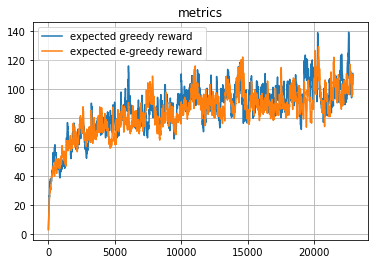

Random session examples


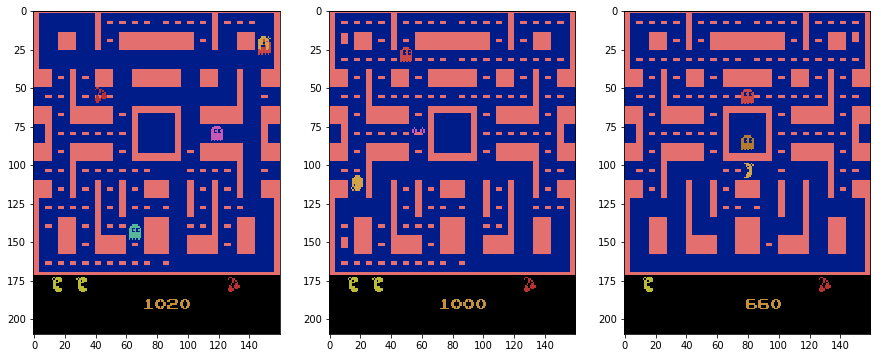

epoch 22910,loss 2123.57071, epsilon 0.05000, rewards: ( e-greedy 100.54524, greedy 108.99363) 
rec 2114.436 reg 9.135
epoch 22920,loss 433.62559, epsilon 0.05000, rewards: ( e-greedy 97.80322, greedy 112.21927) 
rec 424.491 reg 9.135
epoch 22930,loss 2731.66123, epsilon 0.05000, rewards: ( e-greedy 101.39790, greedy 112.80984) 
rec 2722.524 reg 9.137
epoch 22940,loss 1556.87962, epsilon 0.05000, rewards: ( e-greedy 104.19561, greedy 120.21636) 
rec 1547.738 reg 9.141
epoch 22950,loss 3221.07935, epsilon 0.05000, rewards: ( e-greedy 109.71355, greedy 117.56972) 
rec 3211.938 reg 9.141
epoch 22960,loss 795.47383, epsilon 0.05000, rewards: ( e-greedy 107.05469, greedy 116.12525) 
rec 786.336 reg 9.138
epoch 22970,loss 863.05088, epsilon 0.05000, rewards: ( e-greedy 105.22422, greedy 113.07523) 
rec 853.918 reg 9.133
epoch 22980,loss 459.34571, epsilon 0.05000, rewards: ( e-greedy 100.63930, greedy 107.08020) 
rec 450.216 reg 9.130
epoch 22990,loss 4131.14527, epsilon 0.05000, rewards: ( 

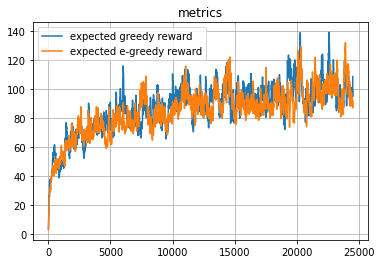

Random session examples


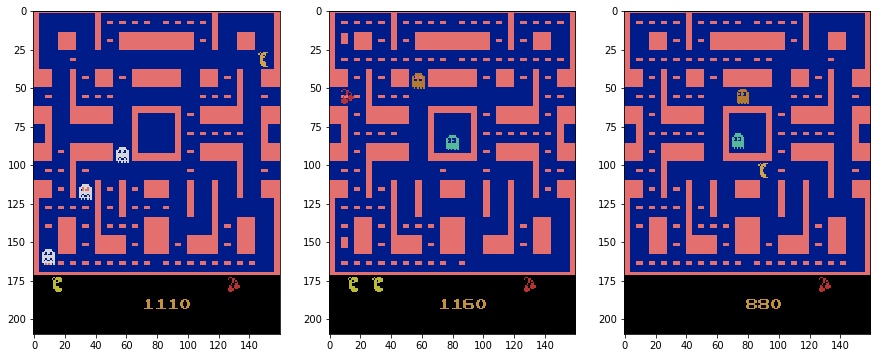

epoch 24510,loss 608.22704, epsilon 0.05000, rewards: ( e-greedy 91.69504, greedy 113.46139) 
rec 598.914 reg 9.313
epoch 24520,loss 1221.83981, epsilon 0.05000, rewards: ( e-greedy 93.40053, greedy 122.80275) 
rec 1212.534 reg 9.306
epoch 24530,loss 328.55502, epsilon 0.05000, rewards: ( e-greedy 89.74798, greedy 123.64747) 
rec 319.256 reg 9.299
epoch 24540,loss 413.01325, epsilon 0.05000, rewards: ( e-greedy 86.27318, greedy 116.28273) 
rec 403.711 reg 9.302
epoch 24550,loss 3140.03845, epsilon 0.05000, rewards: ( e-greedy 95.02086, greedy 119.09195) 
rec 3130.737 reg 9.302
epoch 24560,loss 1048.53345, epsilon 0.05000, rewards: ( e-greedy 94.83128, greedy 125.99526) 
rec 1039.233 reg 9.300
epoch 24570,loss 1338.69480, epsilon 0.05000, rewards: ( e-greedy 92.66065, greedy 119.14573) 
rec 1329.394 reg 9.301
epoch 24580,loss 536.98137, epsilon 0.05000, rewards: ( e-greedy 89.45709, greedy 113.60616) 
rec 527.683 reg 9.299
epoch 24590,loss 927.46390, epsilon 0.05000, rewards: ( e-greedy

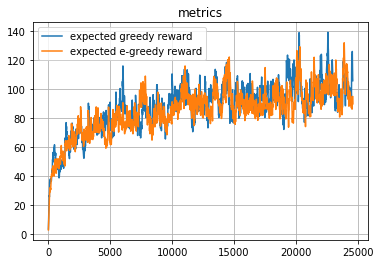

Random session examples


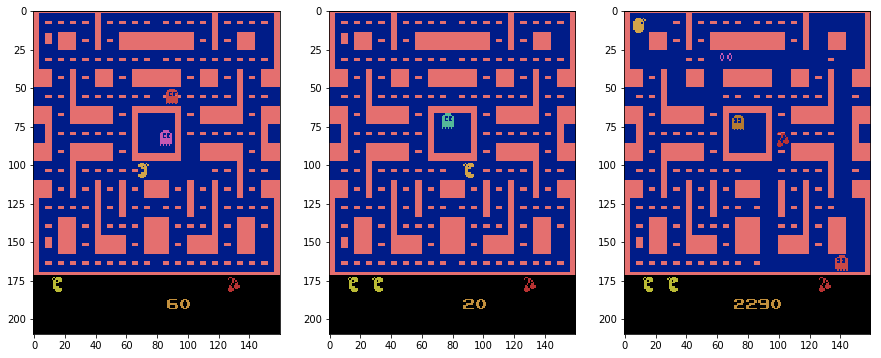

epoch 24610,loss 2759.18505, epsilon 0.05000, rewards: ( e-greedy 101.66984, greedy 109.34639) 
rec 2749.900 reg 9.285
epoch 24620,loss 916.06407, epsilon 0.05000, rewards: ( e-greedy 101.56536, greedy 112.22425) 
rec 906.784 reg 9.281
epoch 24630,loss 4709.06601, epsilon 0.05000, rewards: ( e-greedy 106.34632, greedy 108.31433) 
rec 4699.786 reg 9.280
epoch 24640,loss 1436.90275, epsilon 0.05000, rewards: ( e-greedy 104.77419, greedy 108.23289) 
rec 1427.617 reg 9.286
epoch 24650,loss 412.47136, epsilon 0.05000, rewards: ( e-greedy 98.29677, greedy 105.53460) 
rec 403.177 reg 9.294
epoch 24660,loss 2209.19916, epsilon 0.05000, rewards: ( e-greedy 103.02959, greedy 112.35614) 
rec 2199.900 reg 9.299
epoch 24670,loss 1005.27941, epsilon 0.05000, rewards: ( e-greedy 100.97663, greedy 109.12053) 
rec 995.972 reg 9.307
epoch 24680,loss 722.25865, epsilon 0.05000, rewards: ( e-greedy 96.56647, greedy 108.52098) 
rec 712.934 reg 9.324
epoch 24690,loss 1465.64840, epsilon 0.05000, rewards: ( 

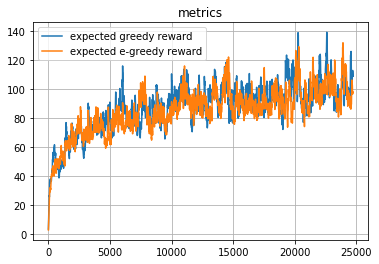

Random session examples


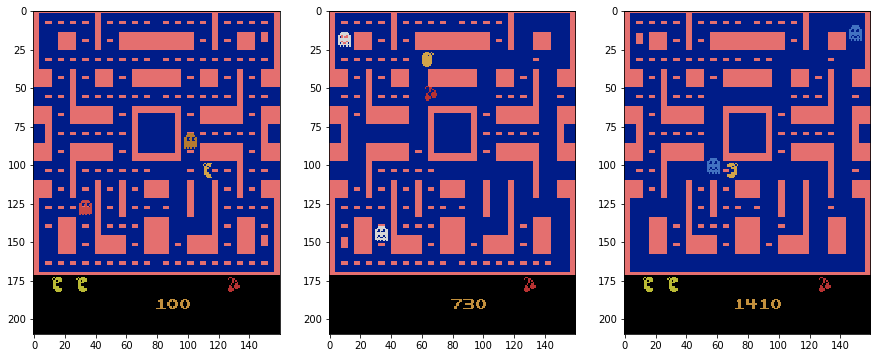

epoch 24710,loss 572.66660, epsilon 0.05000, rewards: ( e-greedy 94.42508, greedy 106.23304) 
rec 563.345 reg 9.322
epoch 24720,loss 648.15152, epsilon 0.05000, rewards: ( e-greedy 91.85757, greedy 104.29724) 
rec 638.833 reg 9.319
epoch 24730,loss 1786.61729, epsilon 0.05000, rewards: ( e-greedy 92.35932, greedy 101.93001) 
rec 1777.299 reg 9.318
epoch 24740,loss 471.00390, epsilon 0.05000, rewards: ( e-greedy 89.99838, greedy 103.04951) 
rec 461.683 reg 9.321


In [ ]:
%%time

n_epochs = 30000

for i in range(n_epochs):    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==0:
        
        save_path = 'fat_videos/MSPacman-v0_' + str(epoch_counter)

        subm_env = gym.make(GAME_TITLE)
        subm_env = gym.wrappers.Monitor(subm_env, 'fat_videos/', force=True)

        rws = []

        for i_episode in xrange(20):

            #initial observation
            observation = subm_env.reset()
            #initial memory
            prev_memories = "zeros"

            s_reward =0.
            t = 0
            while True:

                action,new_memories = step([observation],prev_memories,batch_size=1)
                observation, reward, done, info = subm_env.step(action[0])

                s_reward += reward

                prev_memories = new_memories
                if done:
                    print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
                    rws.append(s_reward)
                    break
                t+=1

        subm_env.close()

        rws = np.array(rws)
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_fat_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

## Record videos

In [ ]:
save_path = 'sarsa1_videos/MSPacman-v0_' + str(epoch_counter-1)

subm_env = gym.make(GAME_TITLE)
subm_env = gym.wrappers.Monitor(subm_env, 'sarsa1_videos/')

rws = []

for i_episode in xrange(220):

    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"

    s_reward =0.
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])

        s_reward += reward

        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
            rws.append(s_reward)
            break
        t+=1

subm_env.close()

rws = np.array(rws)
np.savez(open('rws5hist_sarsa_'+str(epoch_counter-1)+'.npz', 'wb'), rws=rws)

In [ ]:
np.save(open('greedy_sarsa_log.pcl', 'wb'), score_log['expected greedy reward'])
np.save(open('egreedy_sarsa_log.pcl', 'wb'), score_log['expected e-greedy reward'])

###### Patially used code: Aleksey Grinchuk (AlexGrinch), Mariya Popova (Mariewelt) ... and some hedgehog